# GCN in a transductive setting for Node betweenness
This notebook shows how a GCN/GraphSAGE model is trained to compute Node betweenness centrality on different graphs

# 1. Codebase

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *

# 2. Selected graphs for HP search

Graphs with higher number of node betweenness.

In [2]:
import os.path as osp

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T


def get_planetoid_dataset(root,name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Planetoid(root, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset

#dataset1 = TUDataset(root='temp/'+thename, name='REDDIT-BINARY')
dataset = get_planetoid_dataset(root='temp/planetoid',name='Cora', normalize_features=True)
#inspectGraphDataset(dataset, thename)

In [3]:
dataset.num_classes

7

# 2. Benchmark train

## 1. modified dataset splits 
(40*7,750,750) instead of (20*7,500,500)

In [7]:
from __future__ import division

import time

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:40] for i in indices], dim=0)

    rest_index = torch.cat([i[40:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:750], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[750:1500], size=data.num_nodes)

    return data


def run(dataset,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data, dataset.num_classes)
        data = data.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data)
            eval_info = evaluate(model, data)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
run(dataset, Net(dataset), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 0.7756, Test Accuracy: 0.824 ± 0.016, Duration: 0.937


In [ ]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
run(dataset, Net(dataset), 100, 200, 0.01, 0.0005,
    10, permute_masks)

In [65]:
#SGConv
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = SGConv(
            dataset.num_features, dataset.num_classes, K=3, cached=True)

    def reset_parameters(self):
        self.conv1.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)
    

permute_masks = random_planetoid_splits 
run(dataset, Net(dataset), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.7587, Test Accuracy: 0.790 ± 0.018, Duration: 0.585


## 2. modify epochs 20 and 2 instead of 200

In [20]:
from __future__ import division

import time

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)

    return data


def run(dataset,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data, dataset.num_classes)
        data = data.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data)
            eval_info = evaluate(model, data)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
run(dataset, Net(dataset), 100, 10, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.8995, Test Accuracy: 0.628 ± 0.095, Duration: 0.060


## 3. modify gnn params

In [14]:
from __future__ import division

import time

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)

    return data


def run(dataset,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data, dataset.num_classes)
        data = data.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data)
            eval_info = evaluate(model, data)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 5)
        self.conv2 = GCNConv(5, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
run(dataset, Net(dataset), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.0457, Test Accuracy: 0.729 ± 0.036, Duration: 1.140


## 4. modify arch.

In [17]:
from __future__ import division

import time

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)

    return data


def run(dataset,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data, dataset.num_classes)
        data = data.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data)
            eval_info = evaluate(model, data)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
run(dataset, Net(dataset), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 0.7199, Test Accuracy: 0.779 ± 0.019, Duration: 0.696


### Conclusion:
Seems very stable and resilient to perturbations on gnn arch, params, epochs and even splits!

## 6. IDEA: compute node betweenness of this graph

Train for node betweenness, pagerank and then use MetaLayer for edge betweenness

In [51]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 6.1 load graph as nx and compute betweenness

In [6]:
# get dataset, see data.y is classess
data = dataset[0]
#data.y

# transform to nx
#g = pyTorchGeometricDatasetToNx(data)
g = pytorch_geometric_dataset_to_Nx2(data)

# compute node betweenness
#eb = nx.edge_betweenness_centrality(g,normalized=True)
nb = nx.betweenness_centrality(g,normalized=True)
#pr = nx.pagerank(g)


# modify data.y with node betweenness
# how to make sure that each data[i] corresponds to the node_betweenness?
# maybe that was the problem in the other dataset?

# train model, remove softmax

### 6.2 verifying correspondence between original node id's and betweenness result ids

In [8]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [9]:
nb


{0: 9.76615354875872e-07,
 633: 0.0002693989045288987,
 1862: 0.0011993778752248804,
 2582: 0.0001559457789812771,
 1: 0.0010804767055205456,
 2: 0.004050816272459742,
 652: 0.00014618801144164465,
 654: 0.0,
 332: 0.0018375836036892694,
 1454: 0.0,
 1666: 0.001395900033677452,
 1986: 0.12610085690638276,
 3: 0.0,
 2544: 0.0,
 4: 0.0005511761538211194,
 1016: 0.0006780300868797721,
 1256: 0.001888451863504897,
 1761: 0.00494783711120103,
 2175: 0.0005511761538211173,
 2176: 0.0016241906184409547,
 5: 7.501561061887952e-06,
 1629: 0.000972124782066507,
 1659: 0.0,
 2546: 0.0011402633255662526,
 6: 0.0006987223189870195,
 373: 2.619285296909853e-05,
 1042: 0.013314980942513915,
 1416: 0.014367443938934224,
 1602: 0.002907496089650532,
 7: 0.0,
 208: 0.0,
 8: 0.002698394441118153,
 269: 0.0021664438898384383,
 281: 0.006243450242569817,
 1996: 0.005024090889563333,
 9: 0.0,
 723: 0.0,
 2614: 0.0020426566851337374,
 10: 0.0006779390761298553,
 476: 0.005713005205151189,
 2545: 0.0,
 11: 0.

In [88]:
data.y=torch.ones(len(list(nb.keys())))
for k,v in nb.items():
    data.y[int(k)]=v

### 6.3 train the model


In [89]:
data.x # instead of ones, the nodes have a 0!!! maybe that's the difference!

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [90]:
data.y = data.y.float()
data.y = torch.FloatTensor(data.y)
data.y = data.y.reshape(-1,1)
data.y

tensor([[9.7662e-07],
        [1.0805e-03],
        [4.0508e-03],
        ...,
        [0.0000e+00],
        [3.9635e-05],
        [1.6776e-04]])

In [91]:
dataset[0].y = data.y
dataset[0].y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [93]:
data.y

tensor([[9.7662e-07],
        [1.0805e-03],
        [4.0508e-03],
        ...,
        [0.0000e+00],
        [3.9635e-05],
        [1.6776e-04]])

In [77]:
dataset.num_classes

7

In [148]:
from __future__ import division

import time
from pprint import pprint

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)

    return data


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)

def run(dataset,
        y,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    
    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            
            #data = permute_masks(data, dataset.num_classes)
        
            data = permute_masks(data, 1)
        data = data.to(device)

        # parameters are reset before each run
        model.to(device).reset_parameters()
        model.apply(weights_init)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data, y.to(device))
            eval_info = evaluate(model, data, y.to(device))
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    #pprint(val_losses)
    #pprint(accs)
    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('node_betwenness_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            
    return model(data), val_loss_history, accs, val_losses 
            

def train(model, optimizer, data, y):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    #print(tensor.type((out), out[0],tensor.type((out[0]),tensor.type((data.y))
    criterion = torch.nn.MSELoss(size_average = False)
    loss = criterion(out[data.train_mask].float(), y[data.train_mask].float())
    #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data,y):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        criterion = torch.nn.MSELoss(size_average = False) 
        #print(logits.shape)
        #print("logits",logits[mask].shape)
        #print(data.y.shape)
        #print(logits)
        #print("data.y",y[mask].reshape(-1,1))
        loss = criterion(logits[mask].float(), y[mask].reshape(-1,1).float()).item()
        #loss = F.nll_loss(logits[mask], data.y[mask]).item()
        #pred = logits[mask].max(1)[1]
        #acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        acc = np.sqrt(loss)
        
        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc  # rmse
        
    #print("evaluate result dict keys",outs.keys())

    return outs


def reporting_quick(prediction,target, val_loss_history):
    newt = target.to('cpu').detach().numpy()
    newy = prediction.to('cpu').detach().numpy()
    
    gs = gridspec.GridSpec(1, 2) # scatter and 2 boxplots
    fig=plt.figure(figsize=(16, 8), dpi= 60, facecolor='w', edgecolor='k')
    n = 0
    ax = fig.add_subplot(gs[n])
    n+=1
    ax.plot(newt, newy,'o', color='black')
    plt.xlabel('target')
    plt.ylabel('prediction');
    ax.plot(newt, newt, color = 'red', linewidth = 2)
    # ranges
    #ax.xlim(0, 1)
    #ax.ylim(0, 1)
    # title
    ax.set_title('pred val for each target')

    # subplots - boxplot
    ax = fig.add_subplot(gs[n])
    n+=1
    newy.shape = newt.shape
    ax.boxplot([newt.flatten(),newy.flatten() ])
    ax.set_title('summary stats on traget and pred')
    
    fig.tight_layout()
    plt.show()
    
    
    
    plt.plot(
        val_loss_history
        )
    plt.xlabel('epochs')
    plt.ylabel('rmse')
    plt.title('validation performance by epoch')
    plt.show()
    

seed:  0
Val Loss: 0.0144, Test Accuracy: 0.000 ± nan, Duration: 0.031


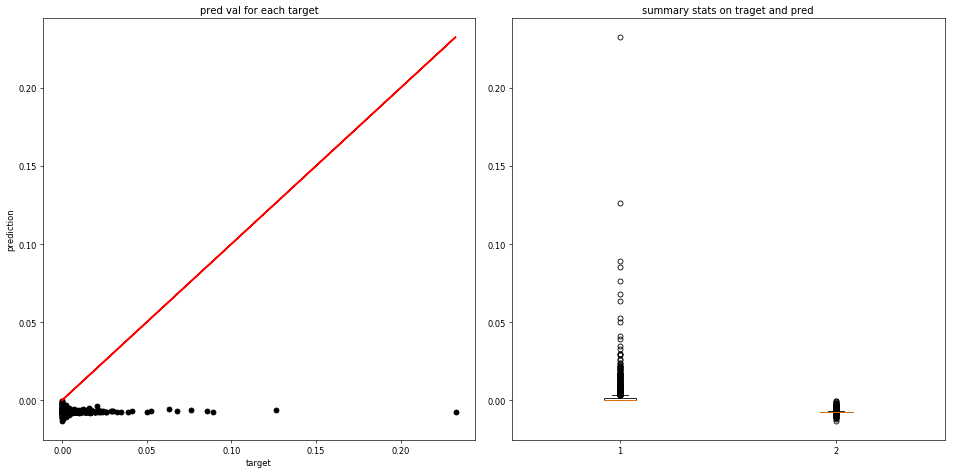

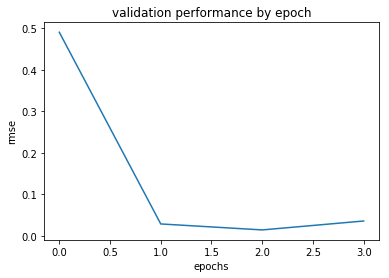

seed:  1
Val Loss: 0.0177, Test Accuracy: 0.000 ± nan, Duration: 0.026


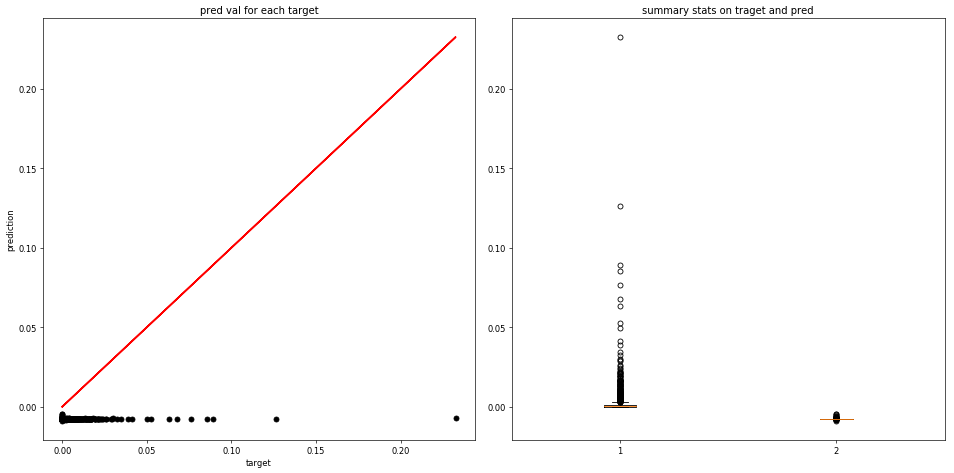

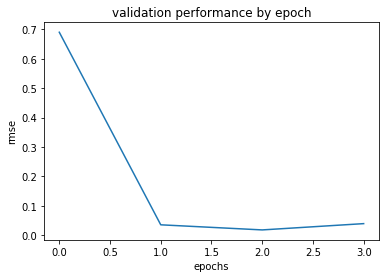

seed:  2
Val Loss: 0.0134, Test Accuracy: 0.000 ± nan, Duration: 0.033


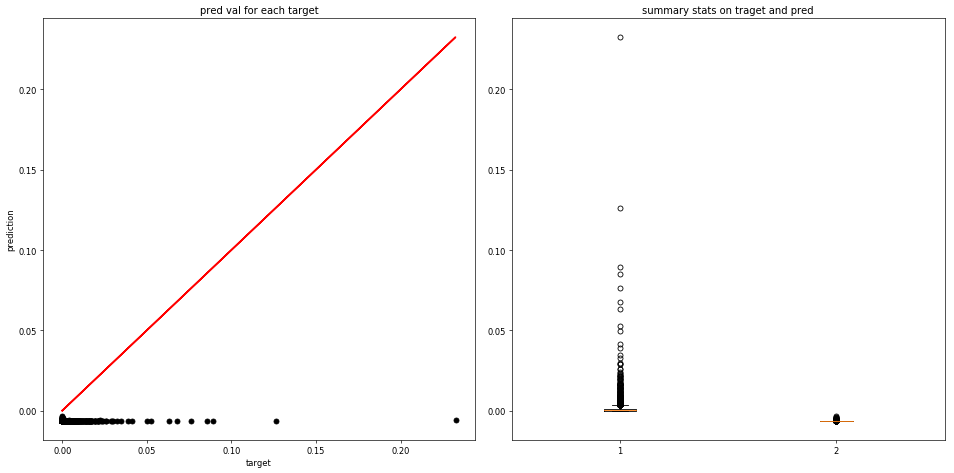

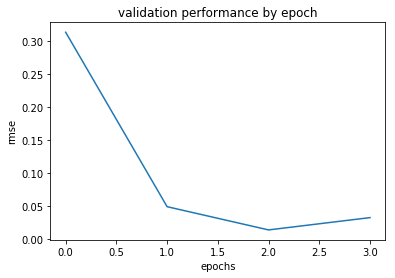

seed:  3
Val Loss: 0.0111, Test Accuracy: 0.000 ± nan, Duration: 0.026


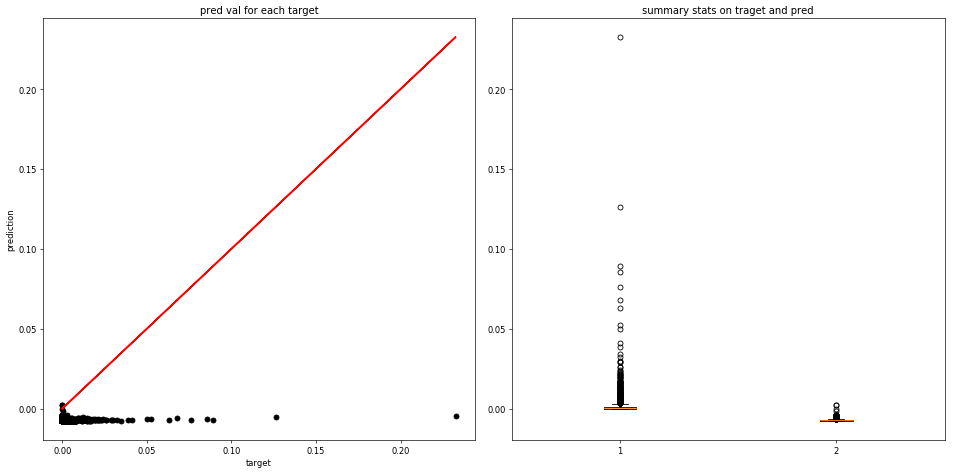

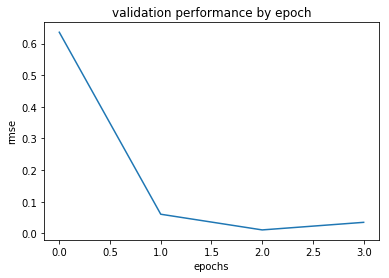

seed:  4
Val Loss: 0.0162, Test Accuracy: 0.000 ± nan, Duration: 0.027


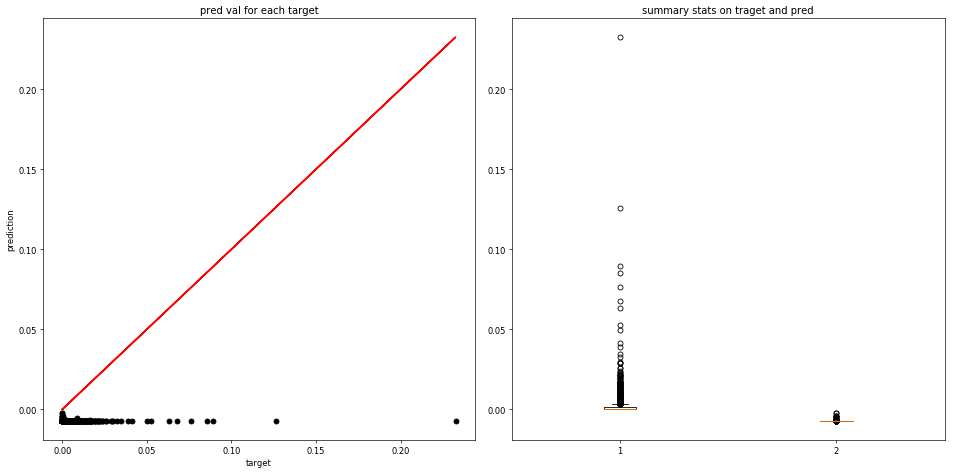

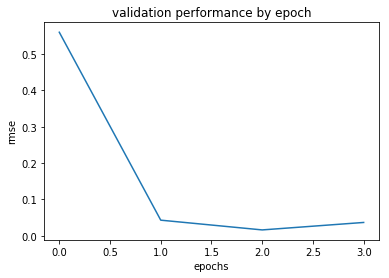

seed:  5
Val Loss: 0.0061, Test Accuracy: 0.000 ± nan, Duration: 0.029


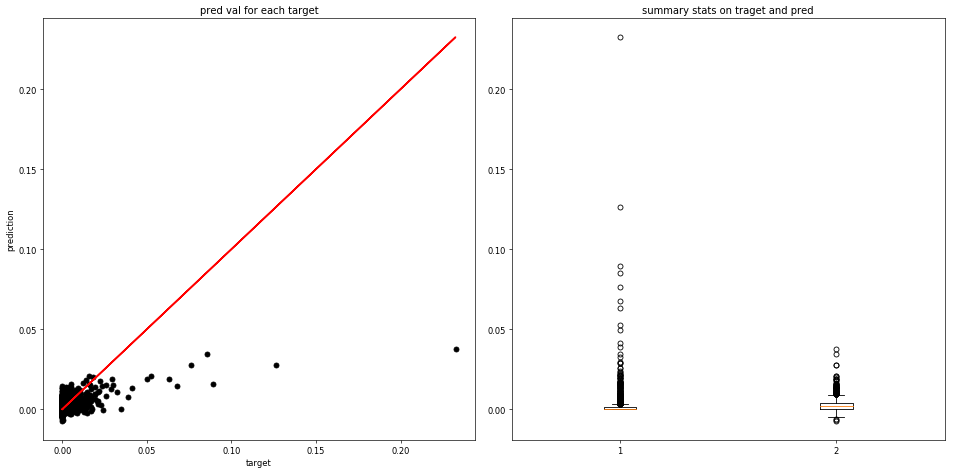

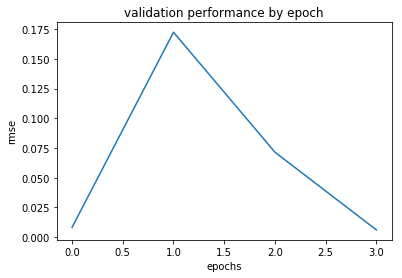

seed:  6
Val Loss: 0.0170, Test Accuracy: 0.000 ± nan, Duration: 0.026


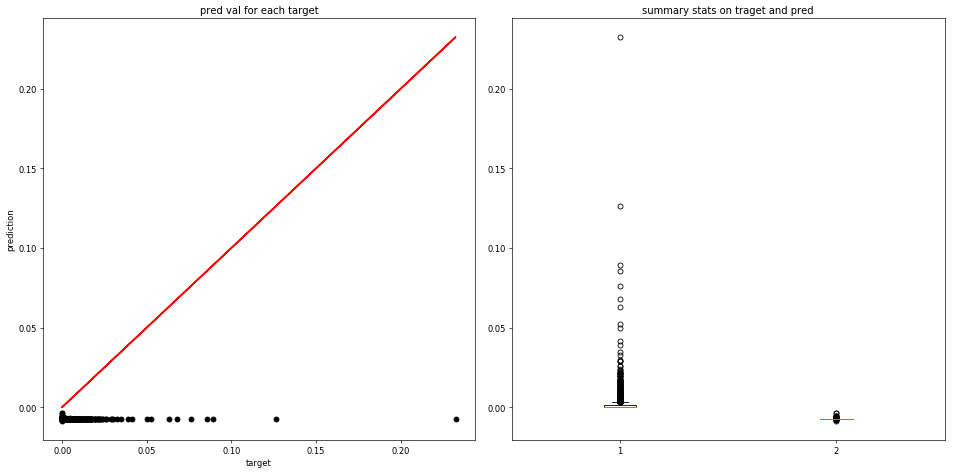

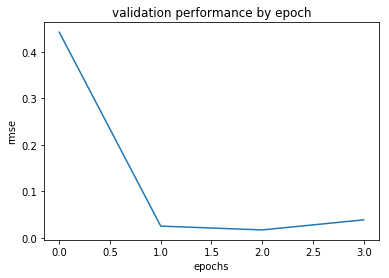

seed:  7
Val Loss: 0.0131, Test Accuracy: 0.000 ± nan, Duration: 0.026


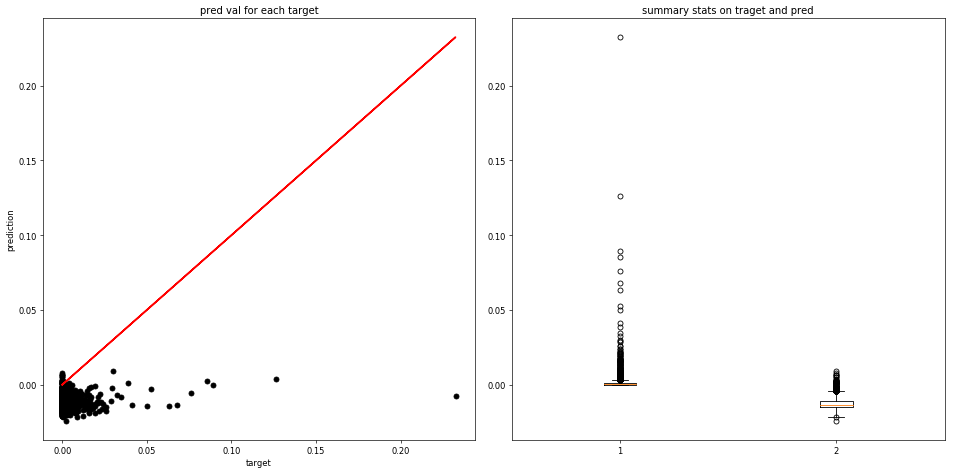

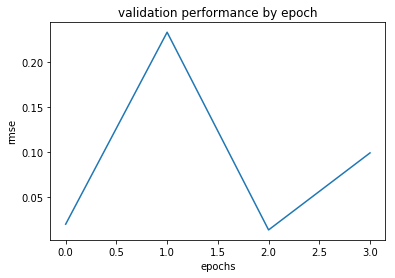

seed:  8
Val Loss: 0.0156, Test Accuracy: 0.000 ± nan, Duration: 0.029


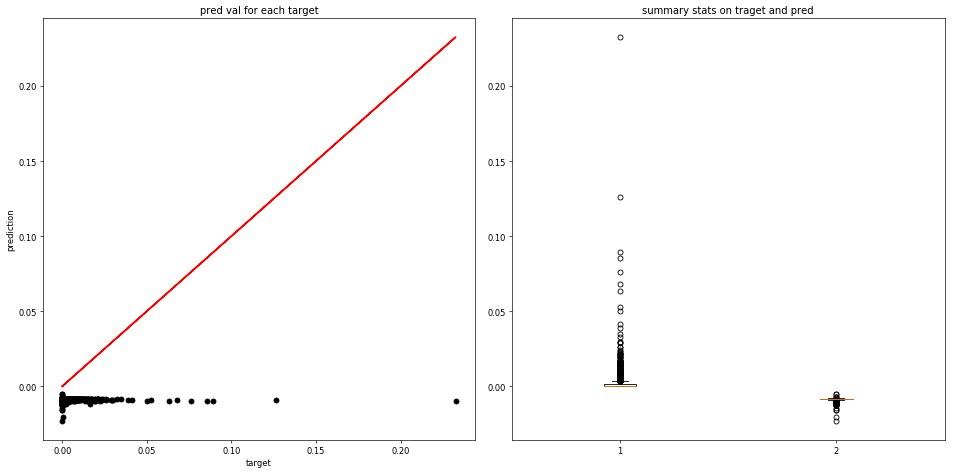

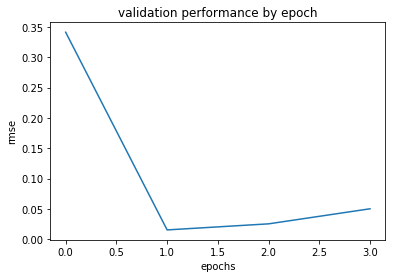

seed:  9
Val Loss: 0.0165, Test Accuracy: 0.000 ± nan, Duration: 0.026


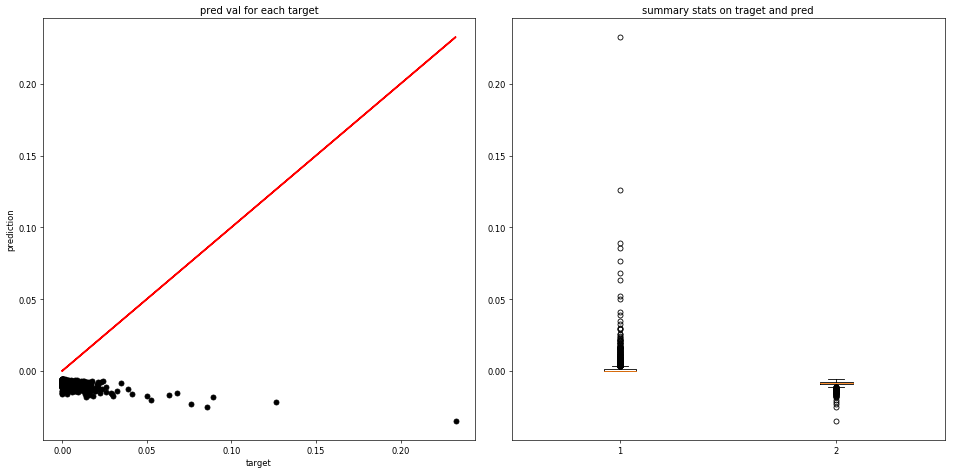

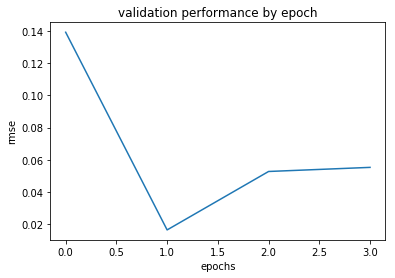

seed:  10
Val Loss: 0.0123, Test Accuracy: 0.000 ± nan, Duration: 0.036


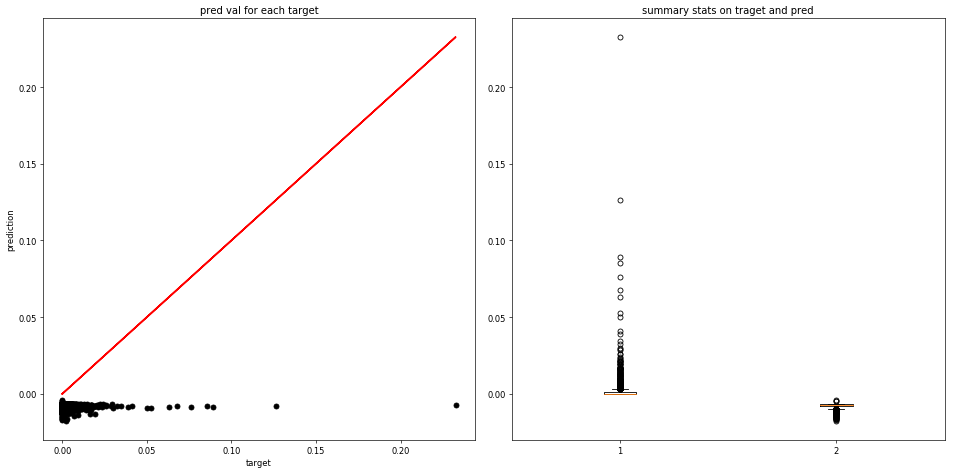

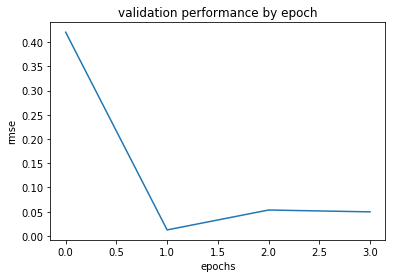

seed:  11
Val Loss: 0.0200, Test Accuracy: 0.000 ± nan, Duration: 0.029


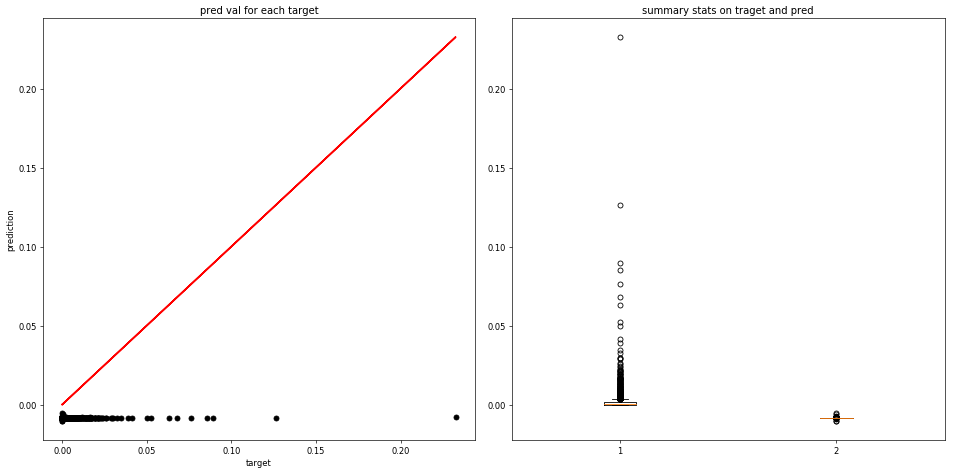

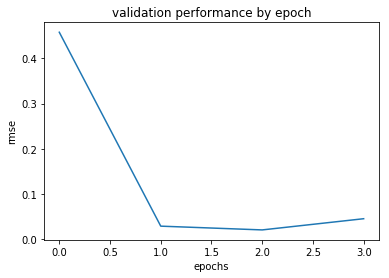

seed:  12
Val Loss: 0.0106, Test Accuracy: 0.000 ± nan, Duration: 0.036


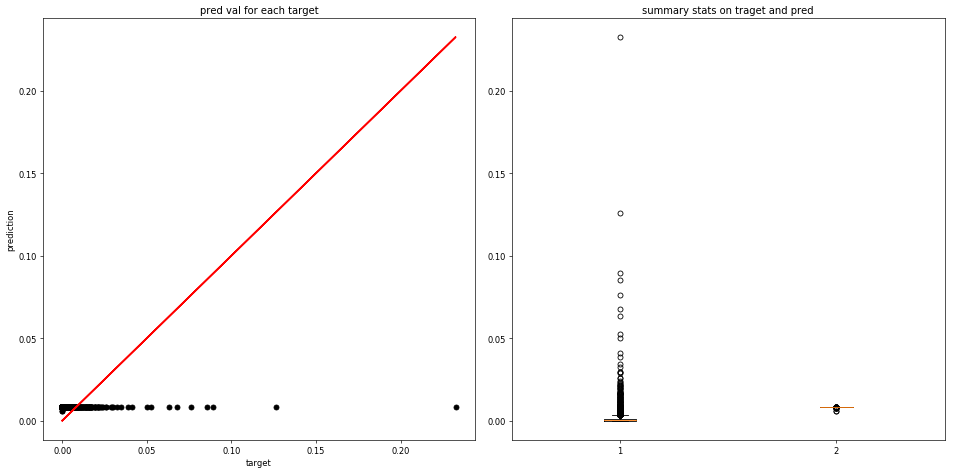

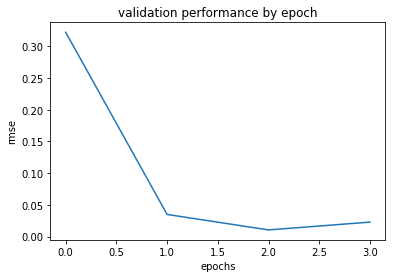

seed:  13
Val Loss: 0.0189, Test Accuracy: 0.000 ± nan, Duration: 0.026


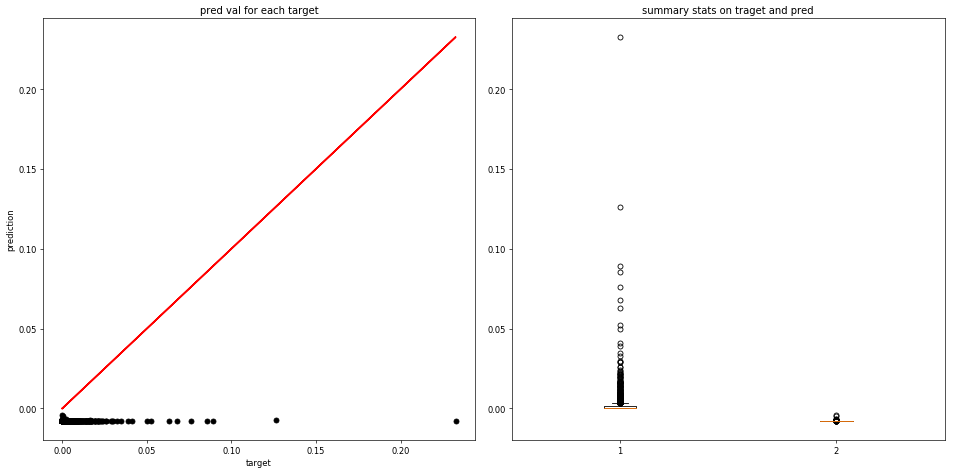

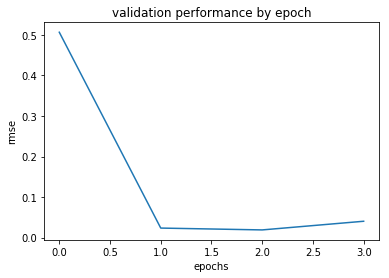

seed:  14
Val Loss: 0.0122, Test Accuracy: 0.000 ± nan, Duration: 0.028


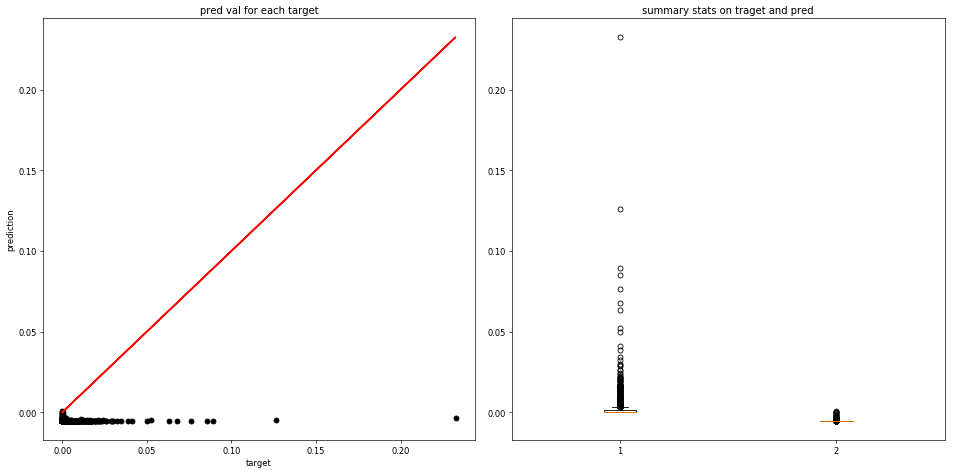

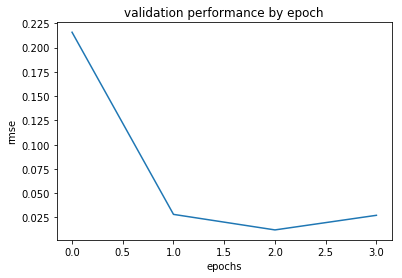

seed:  15
Val Loss: 0.0198, Test Accuracy: 0.000 ± nan, Duration: 0.032


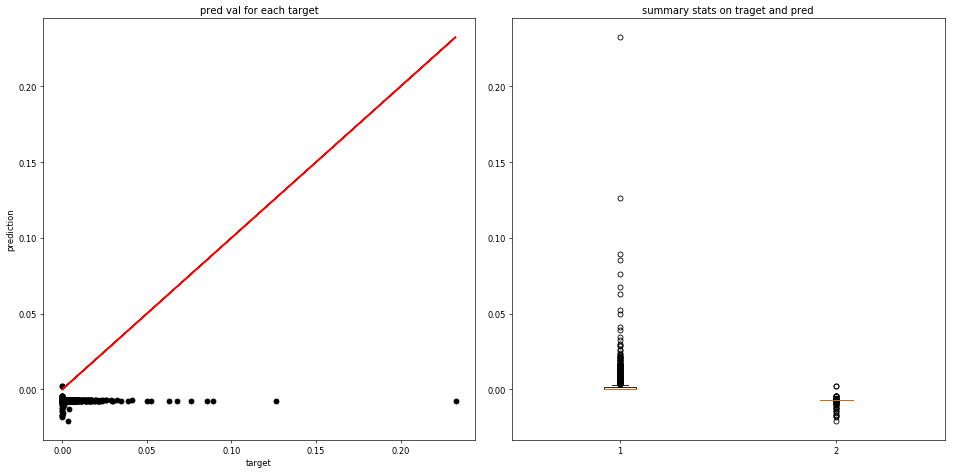

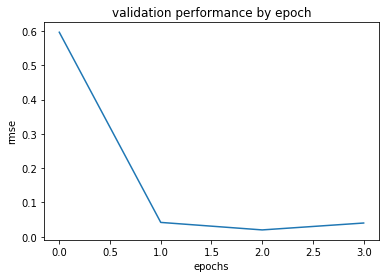

seed:  16
Val Loss: 0.0143, Test Accuracy: 0.000 ± nan, Duration: 0.033


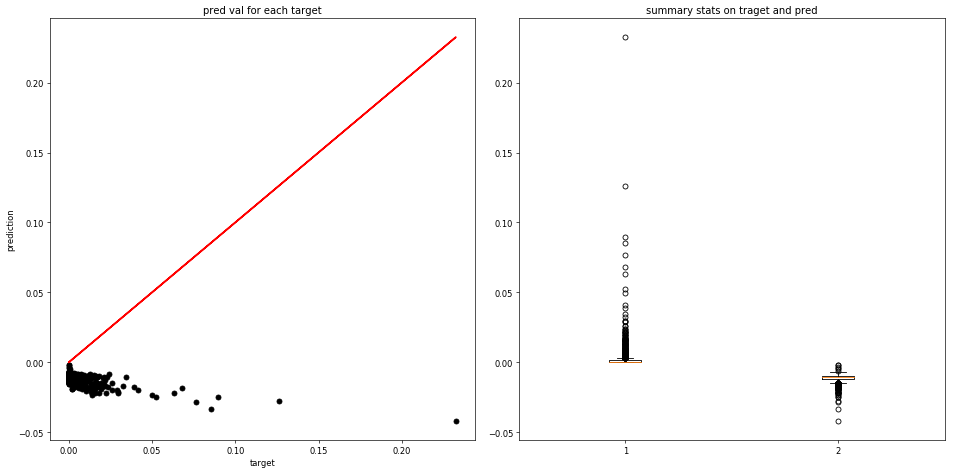

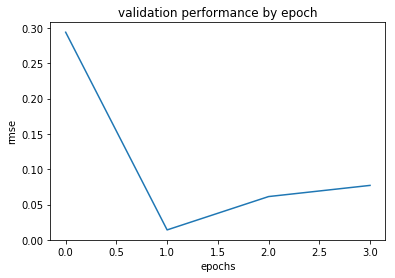

seed:  17
Val Loss: 0.0102, Test Accuracy: 0.000 ± nan, Duration: 0.032


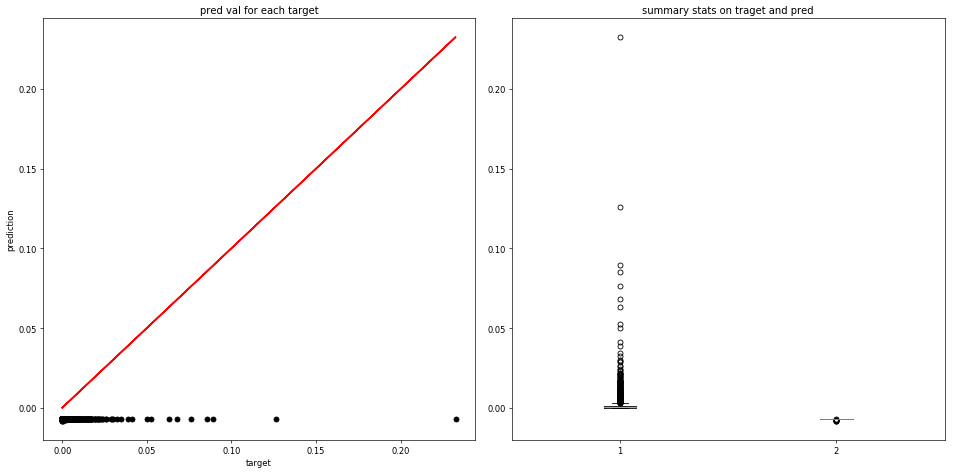

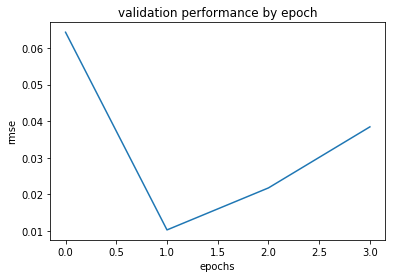

seed:  18
Val Loss: 0.0246, Test Accuracy: 0.000 ± nan, Duration: 0.032


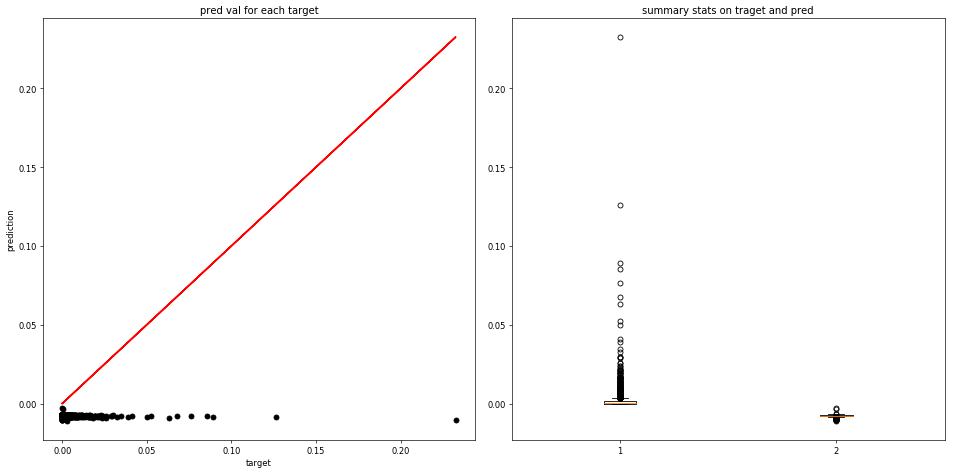

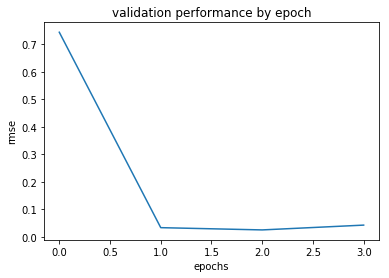

seed:  19
Val Loss: 0.0074, Test Accuracy: 0.000 ± nan, Duration: 0.031


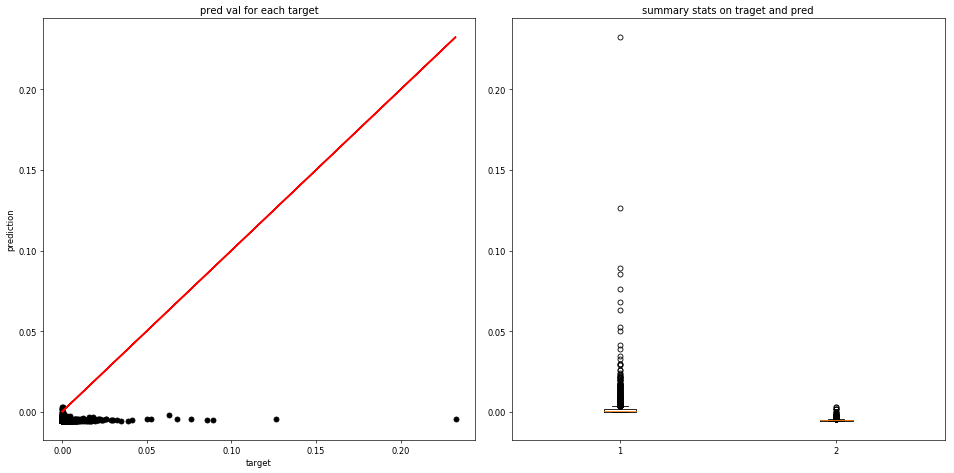

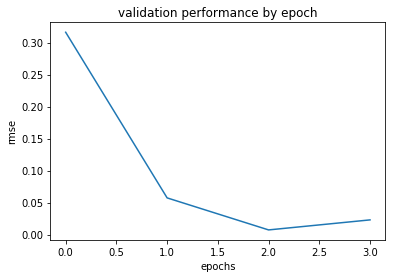

seed:  20
Val Loss: 0.0113, Test Accuracy: 0.000 ± nan, Duration: 0.029


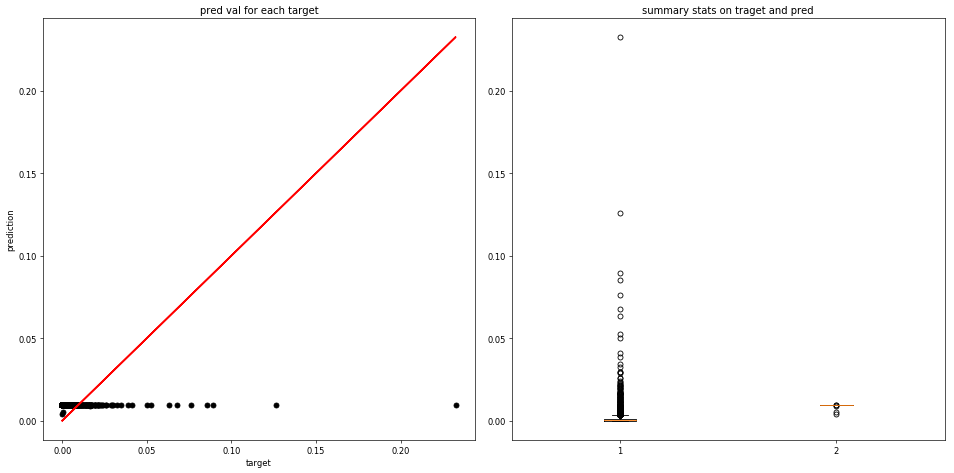

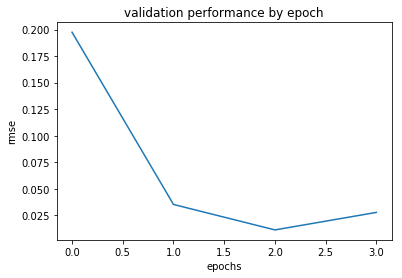

seed:  21
Val Loss: 0.0095, Test Accuracy: 0.000 ± nan, Duration: 0.029


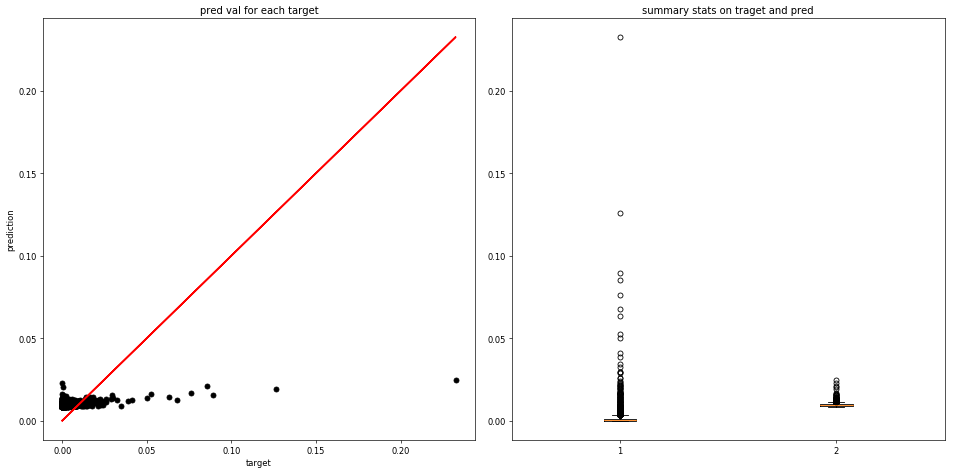

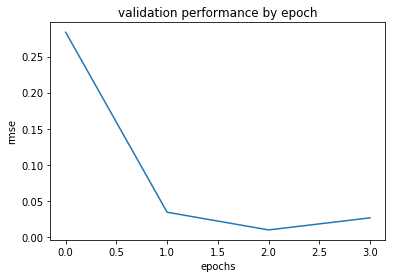

seed:  22
Val Loss: 0.0174, Test Accuracy: 0.000 ± nan, Duration: 0.041


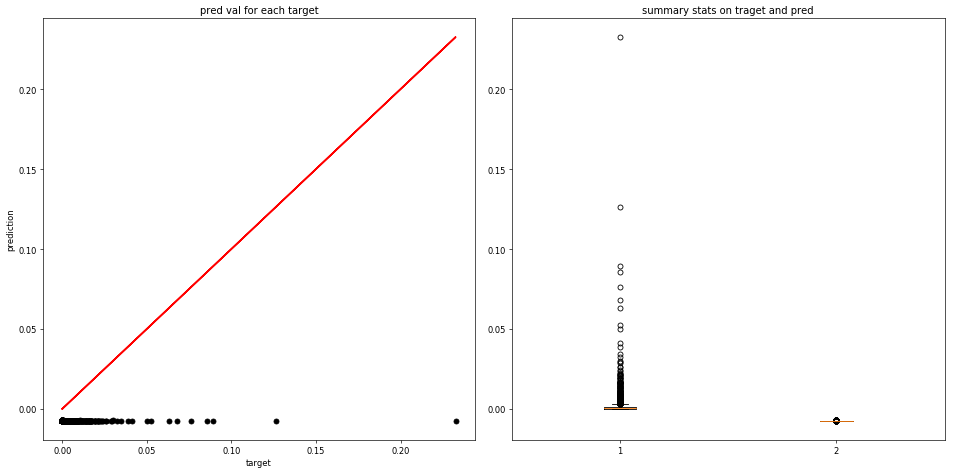

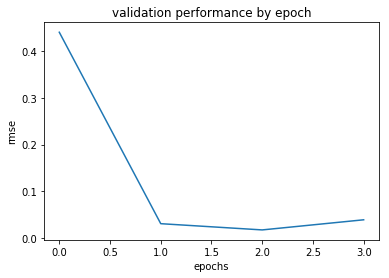

seed:  23
Val Loss: 0.0163, Test Accuracy: 0.000 ± nan, Duration: 0.030


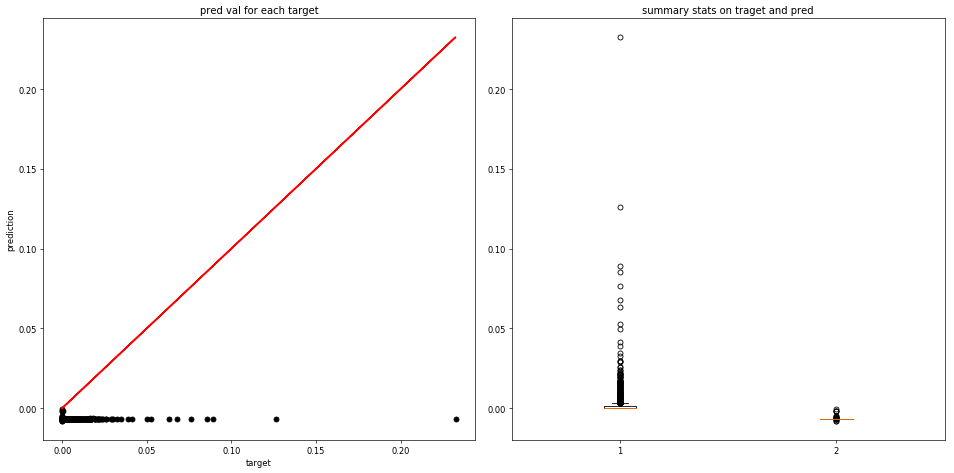

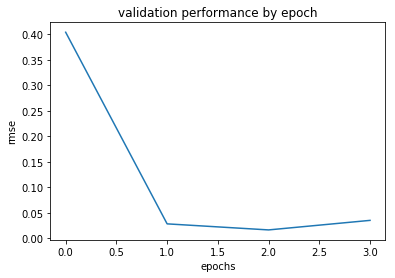

seed:  24
Val Loss: 0.0107, Test Accuracy: 0.000 ± nan, Duration: 0.031


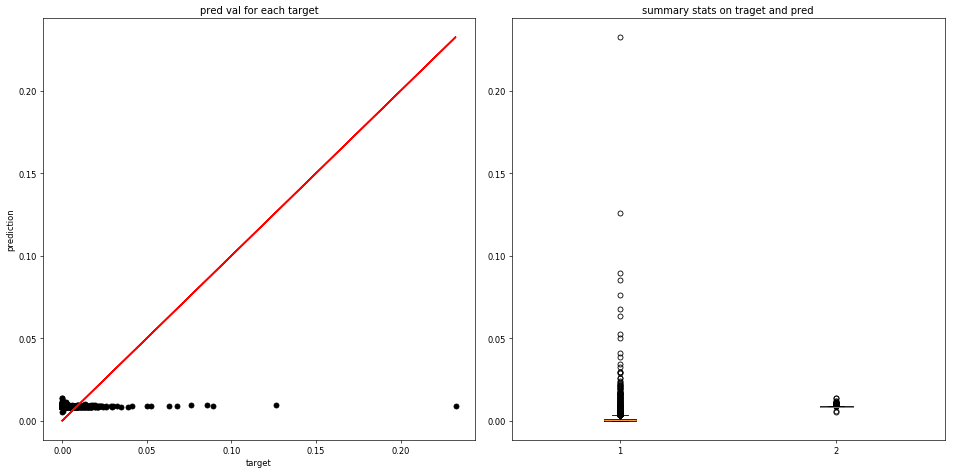

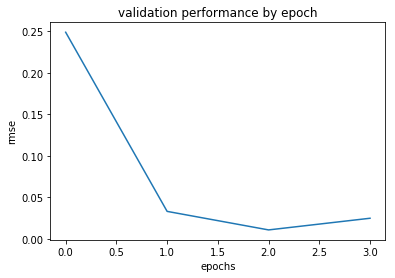

seed:  25
Val Loss: 0.0106, Test Accuracy: 0.000 ± nan, Duration: 0.034


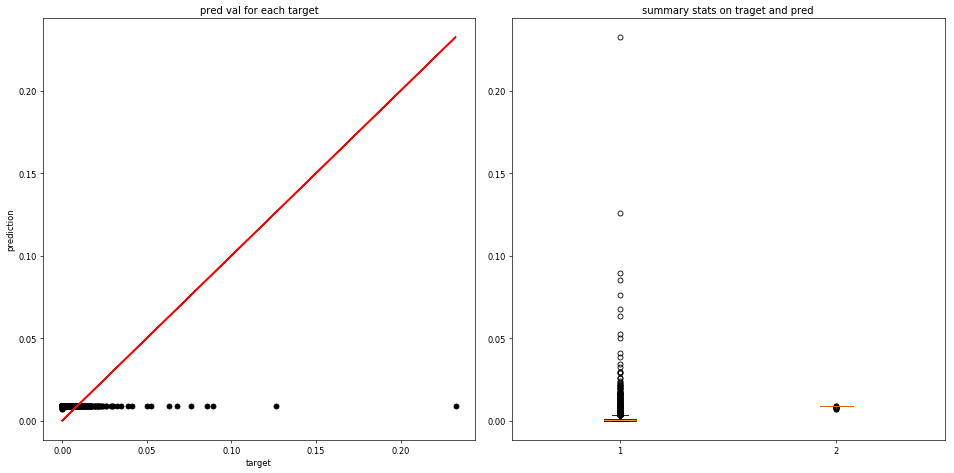

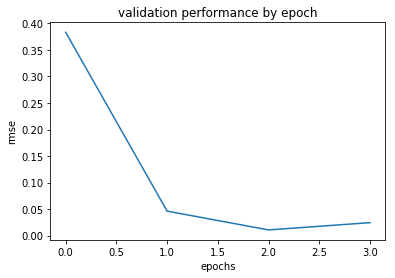

seed:  26
Val Loss: 0.0104, Test Accuracy: 0.000 ± nan, Duration: 0.032


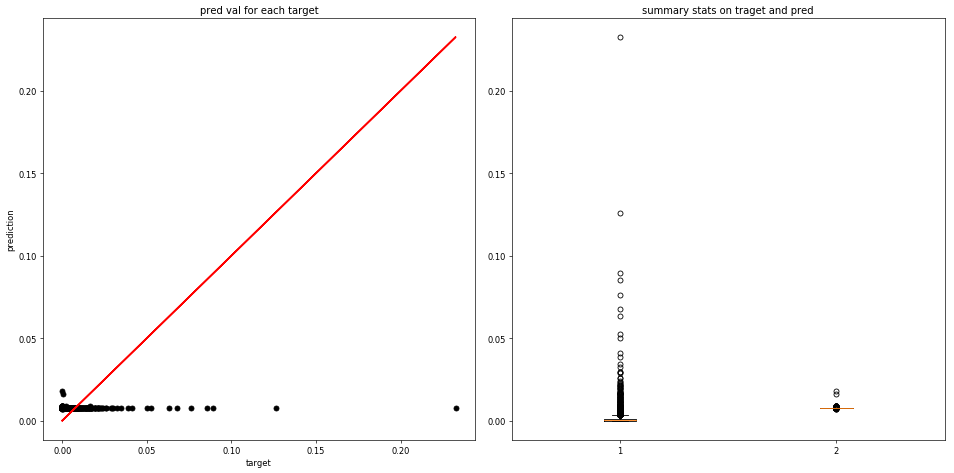

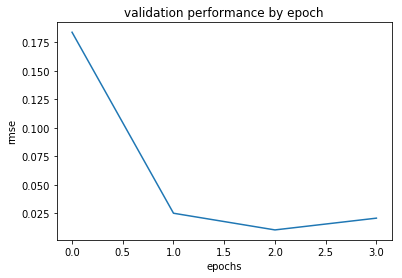

seed:  27
Val Loss: 0.0156, Test Accuracy: 0.000 ± nan, Duration: 0.030


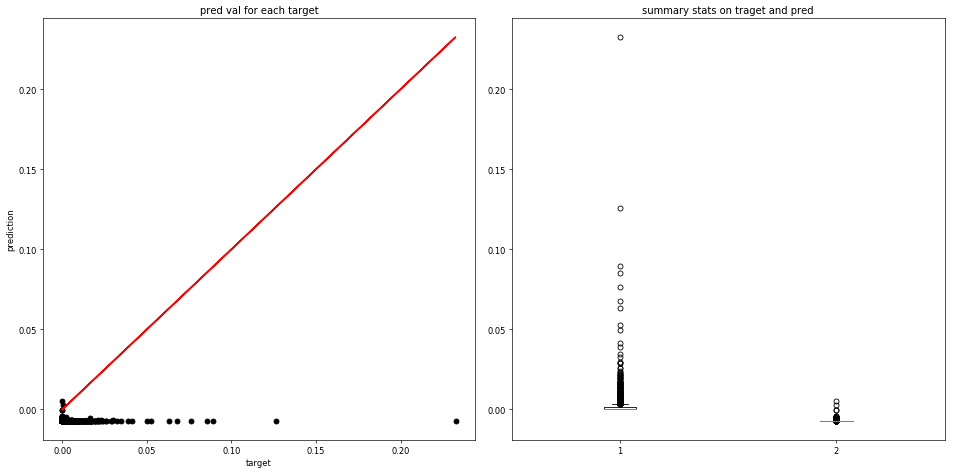

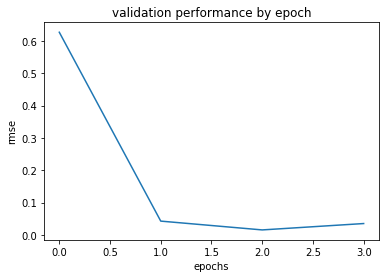

seed:  28
Val Loss: 0.0196, Test Accuracy: 0.000 ± nan, Duration: 0.025


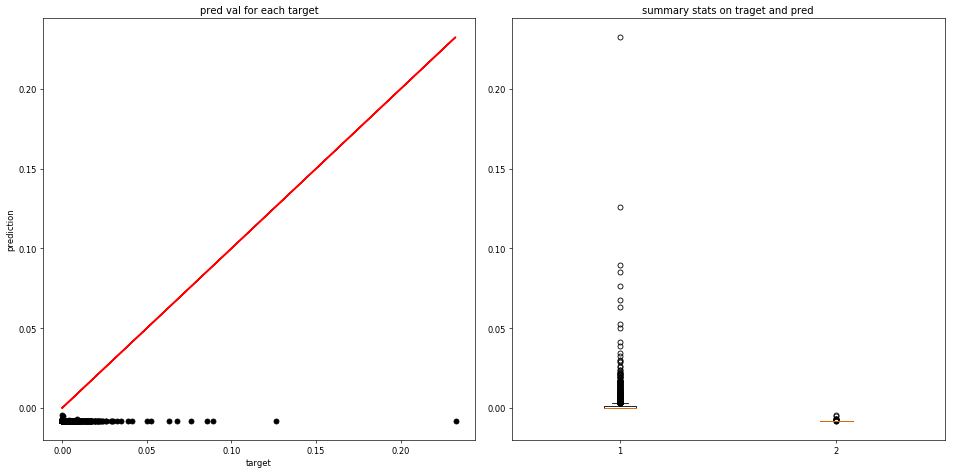

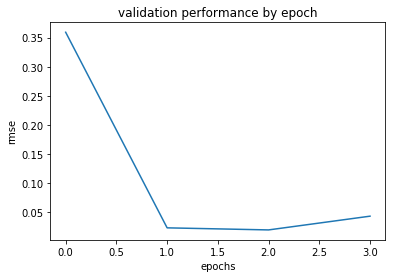

seed:  29
Val Loss: 0.0168, Test Accuracy: 0.000 ± nan, Duration: 0.027


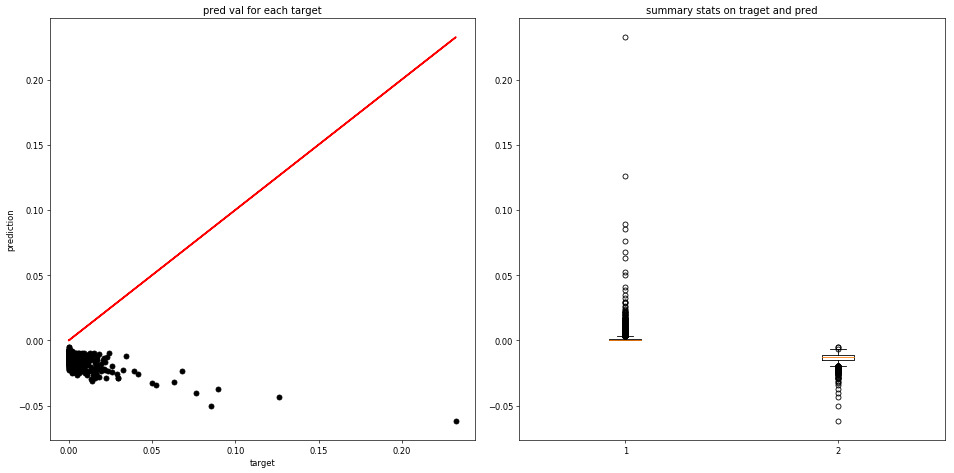

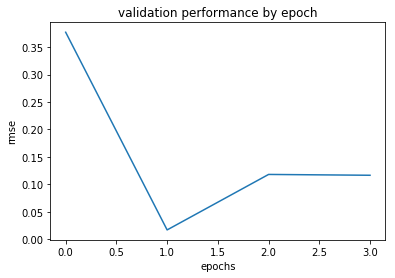

seed:  30
Val Loss: 0.0153, Test Accuracy: 0.000 ± nan, Duration: 0.032


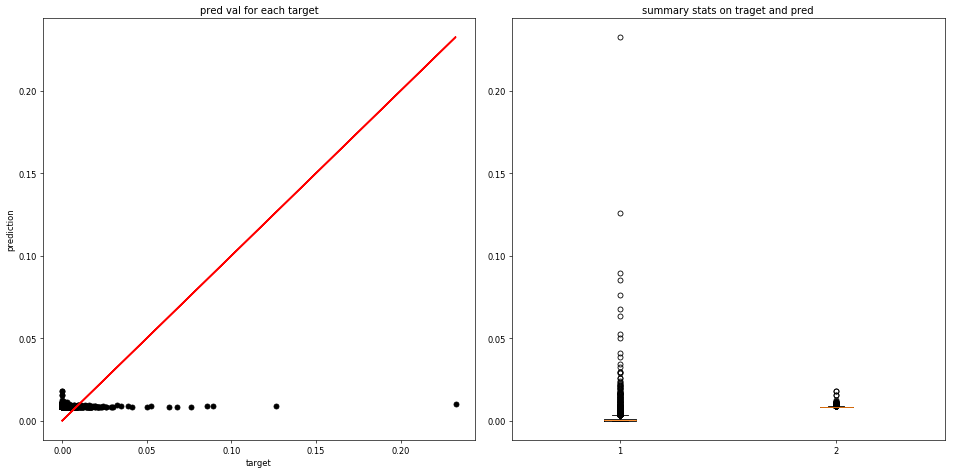

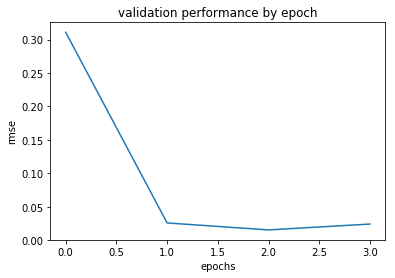

seed:  31
Val Loss: 0.0059, Test Accuracy: 0.000 ± nan, Duration: 0.025


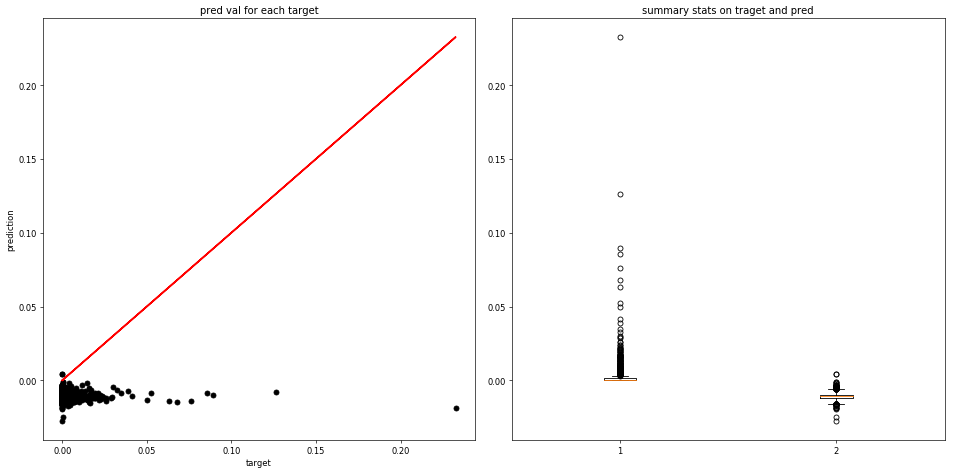

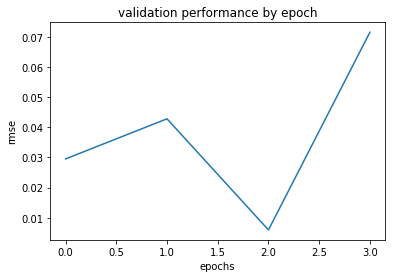

seed:  32
Val Loss: 0.0045, Test Accuracy: 0.000 ± nan, Duration: 0.027


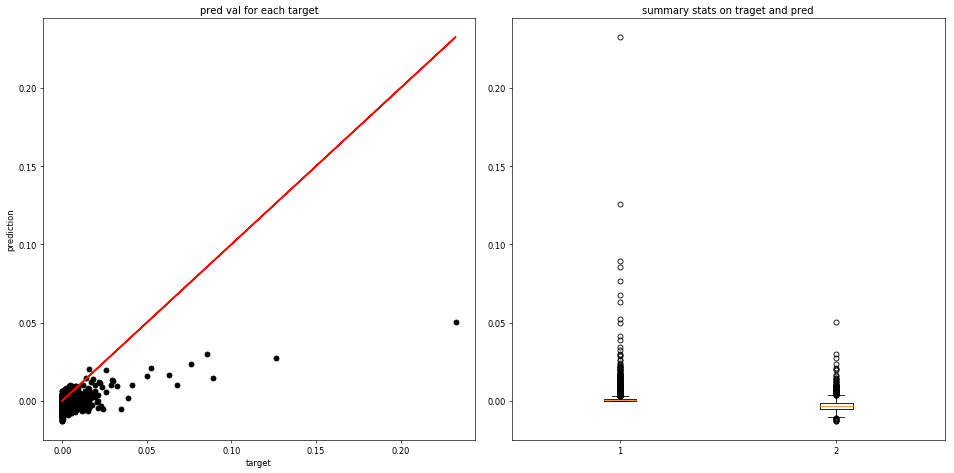

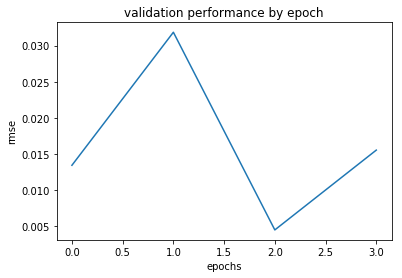

seed:  33
Val Loss: 0.0113, Test Accuracy: 0.000 ± nan, Duration: 0.041


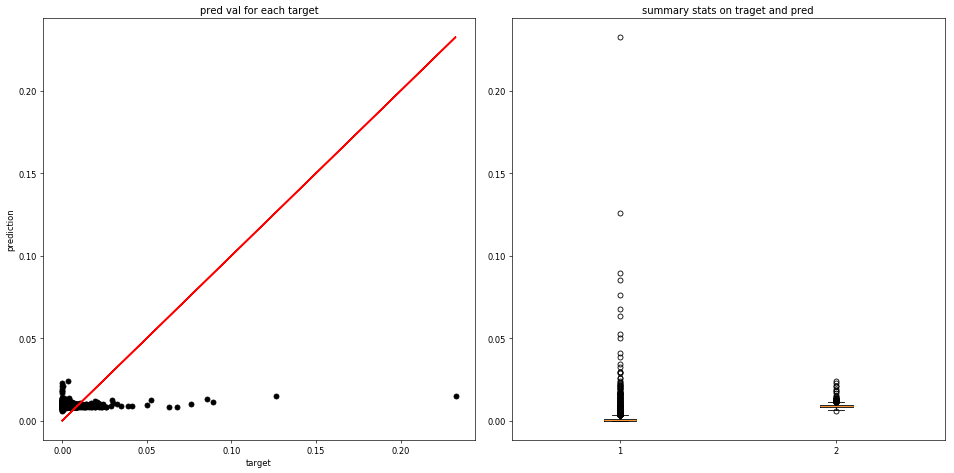

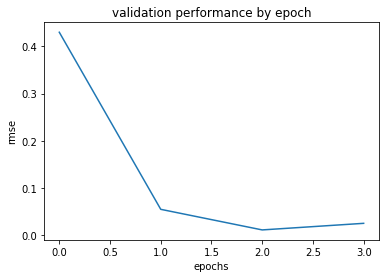

seed:  34
Val Loss: 0.0131, Test Accuracy: 0.000 ± nan, Duration: 0.035


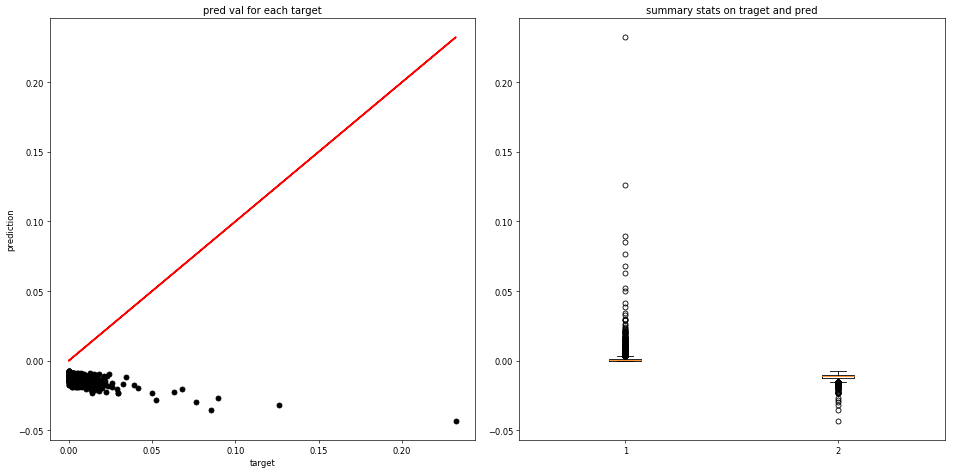

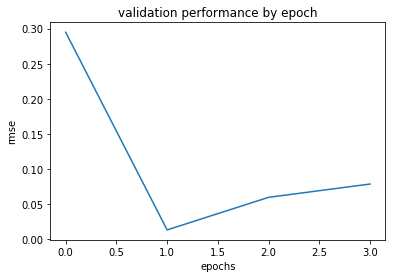

seed:  35
Val Loss: 0.0109, Test Accuracy: 0.000 ± nan, Duration: 0.027


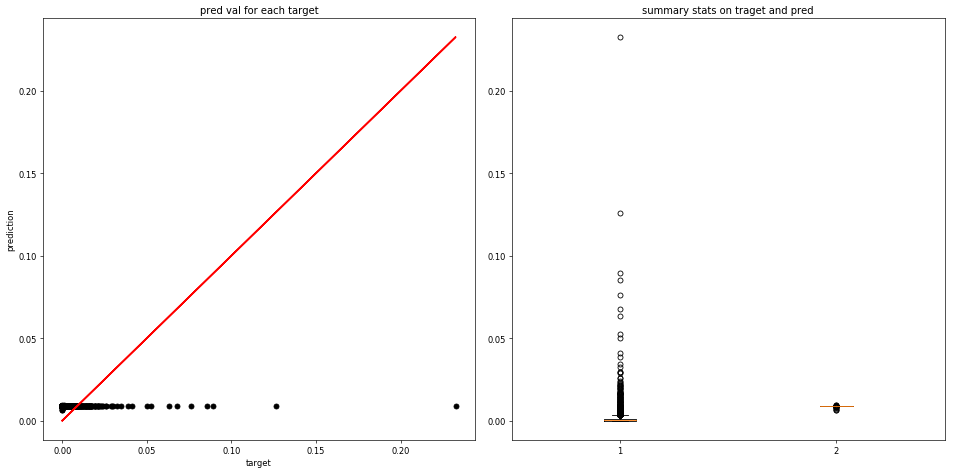

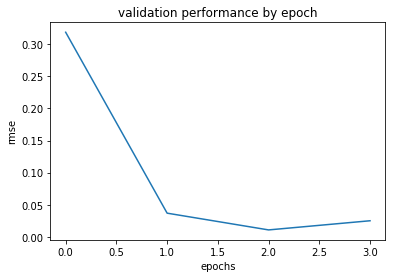

seed:  36
Val Loss: 0.0125, Test Accuracy: 0.000 ± nan, Duration: 0.034


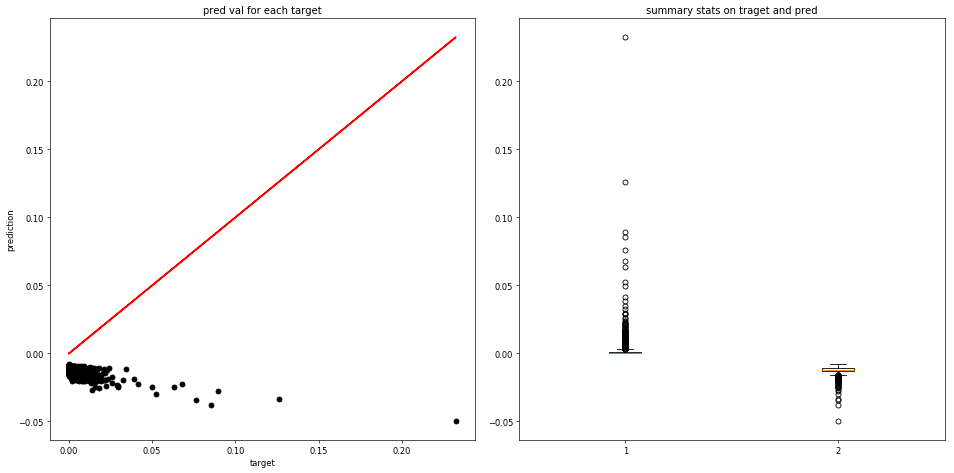

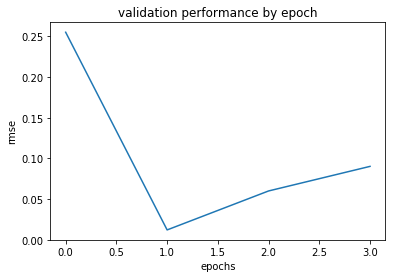

seed:  37
Val Loss: 0.0180, Test Accuracy: 0.000 ± nan, Duration: 0.028


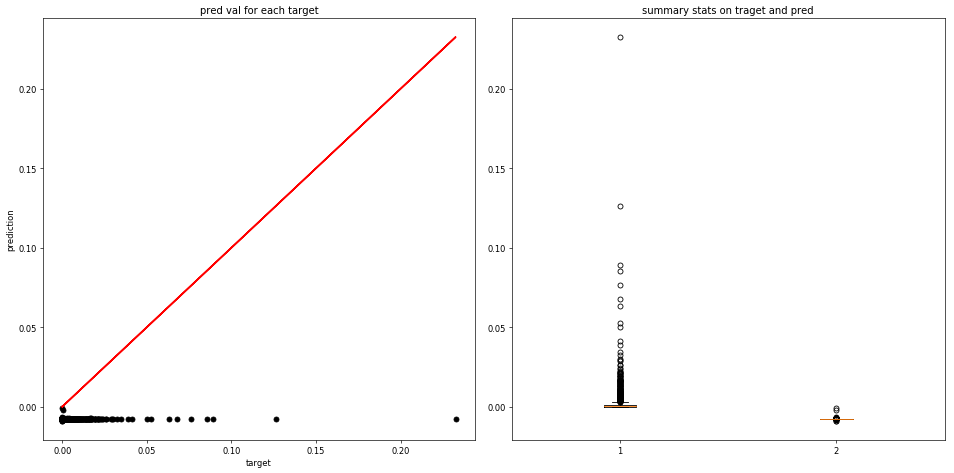

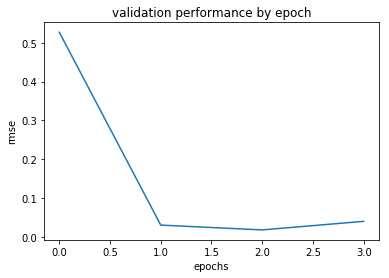

seed:  38
Val Loss: 0.0110, Test Accuracy: 0.000 ± nan, Duration: 0.051


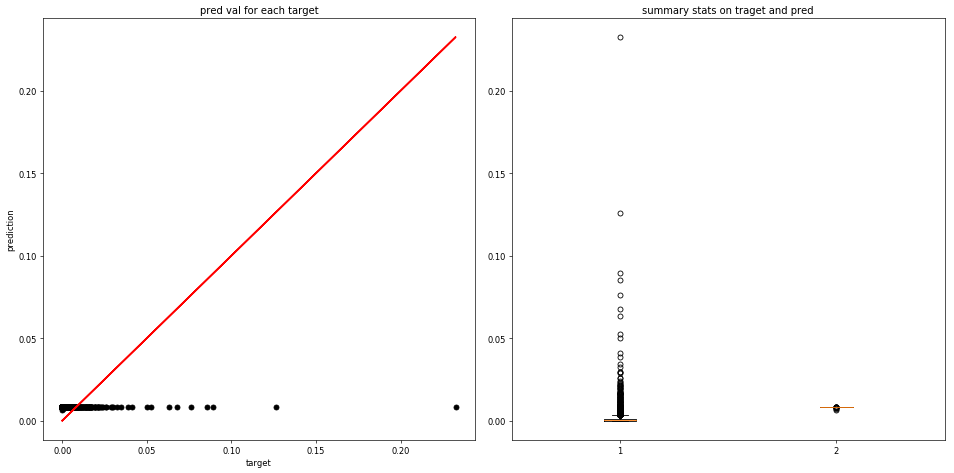

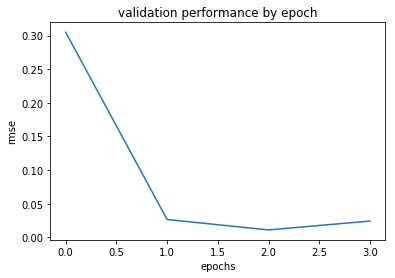

seed:  39
Val Loss: 0.0119, Test Accuracy: 0.000 ± nan, Duration: 0.026


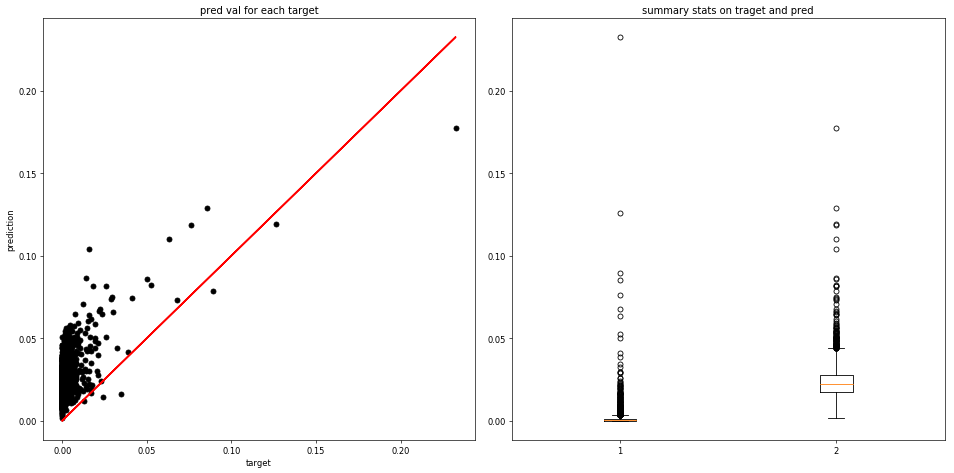

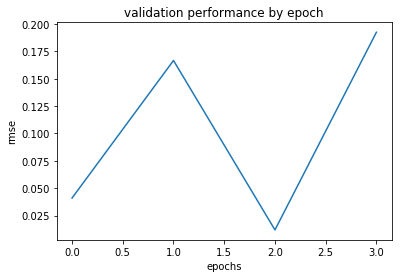

seed:  40
Val Loss: 0.0222, Test Accuracy: 0.000 ± nan, Duration: 0.027


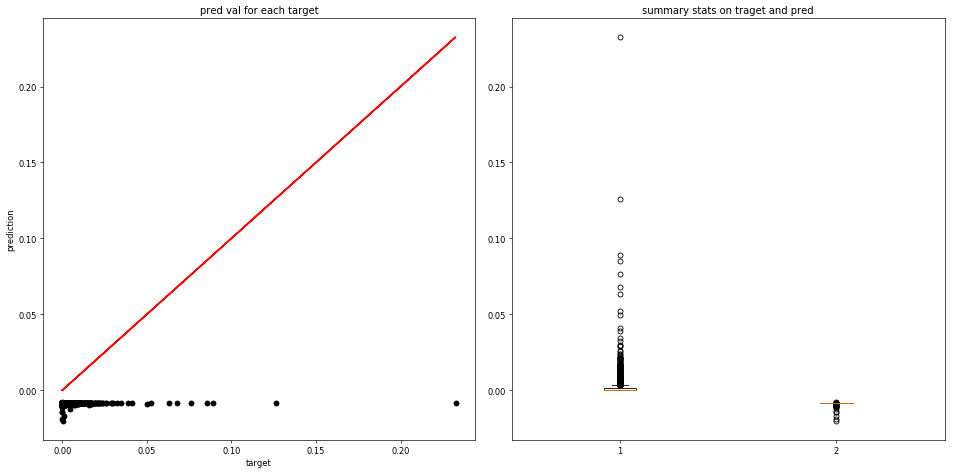

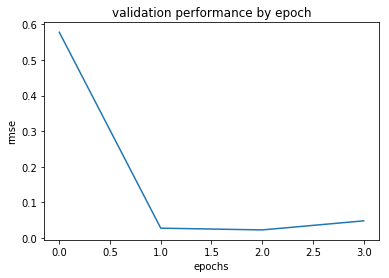

seed:  41
Val Loss: 0.0168, Test Accuracy: 0.000 ± nan, Duration: 0.027


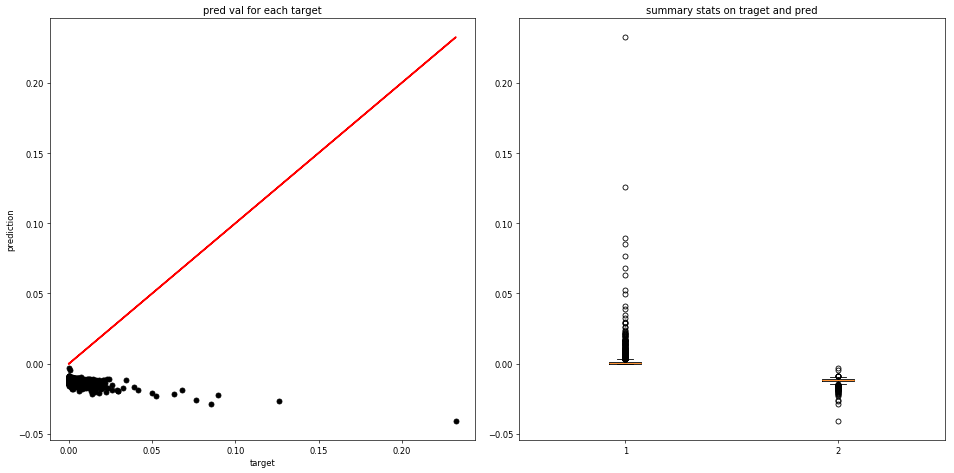

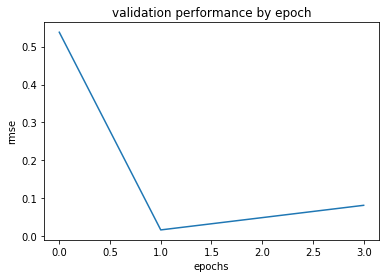

seed:  42
Val Loss: 0.0152, Test Accuracy: 0.000 ± nan, Duration: 0.041


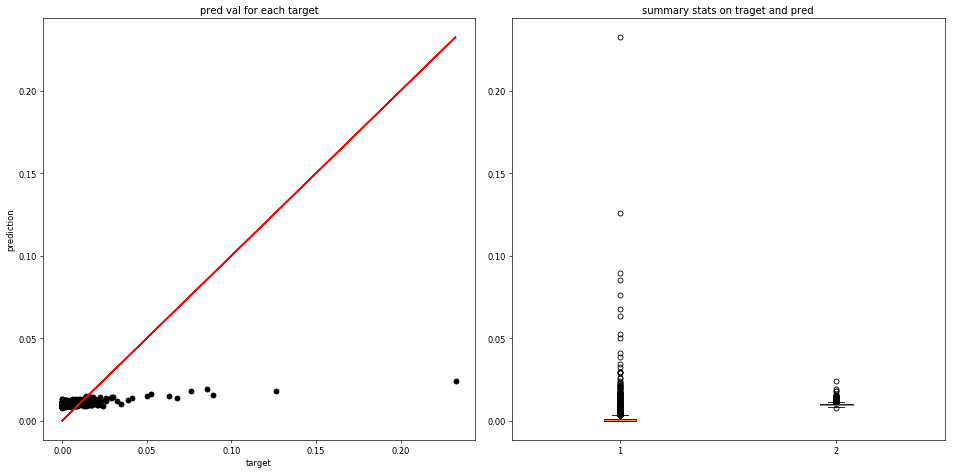

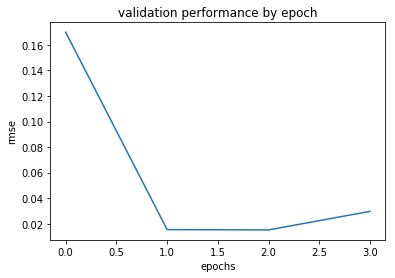

seed:  43
Val Loss: 0.0183, Test Accuracy: 0.000 ± nan, Duration: 0.037


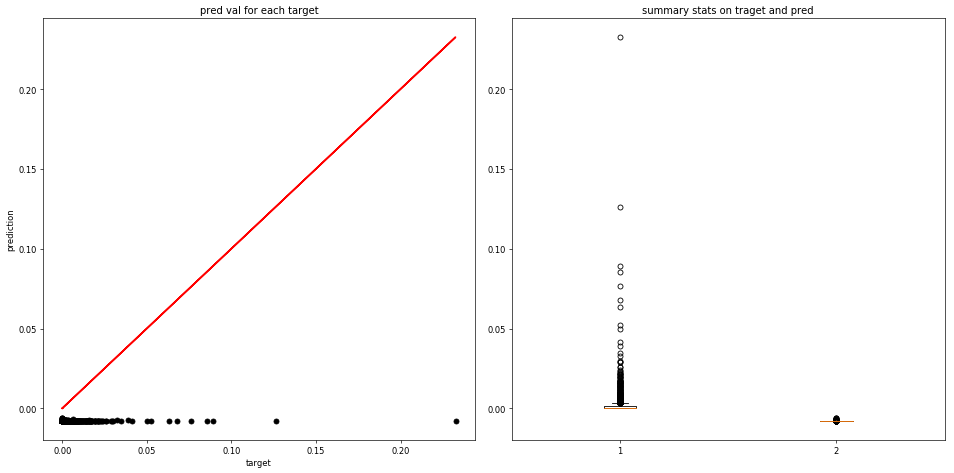

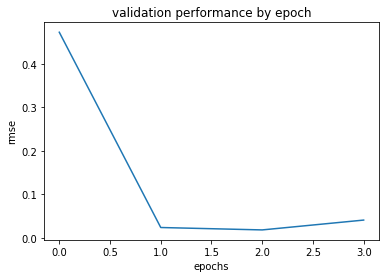

seed:  44
Val Loss: 0.0148, Test Accuracy: 0.000 ± nan, Duration: 0.025


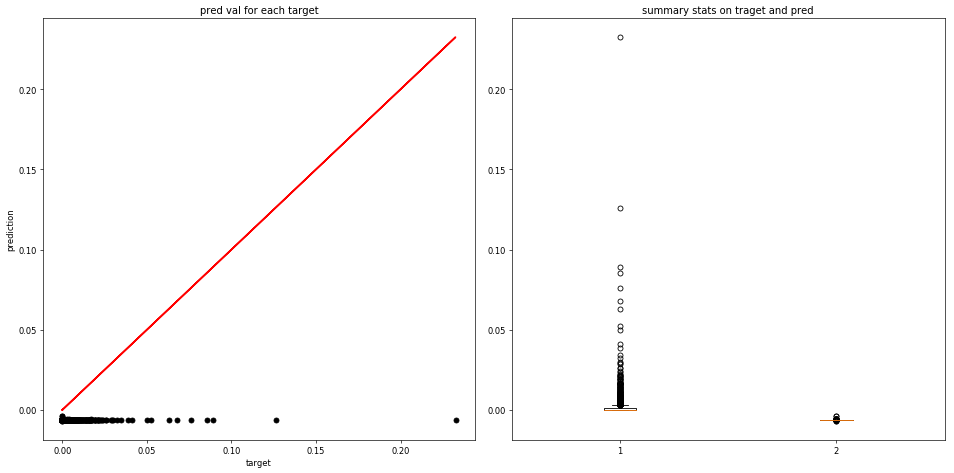

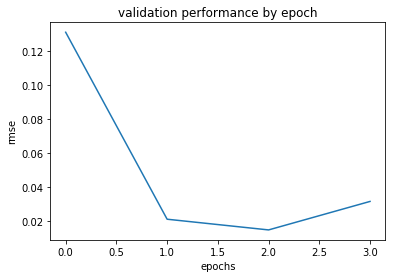

seed:  45
Val Loss: 0.0097, Test Accuracy: 0.000 ± nan, Duration: 0.048


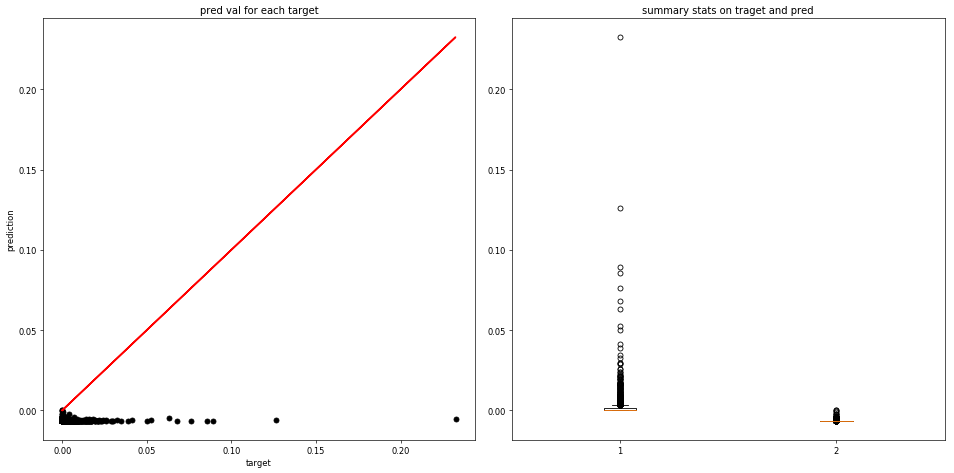

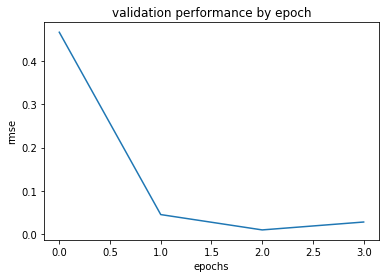

seed:  46
Val Loss: 0.0209, Test Accuracy: 0.000 ± nan, Duration: 0.033


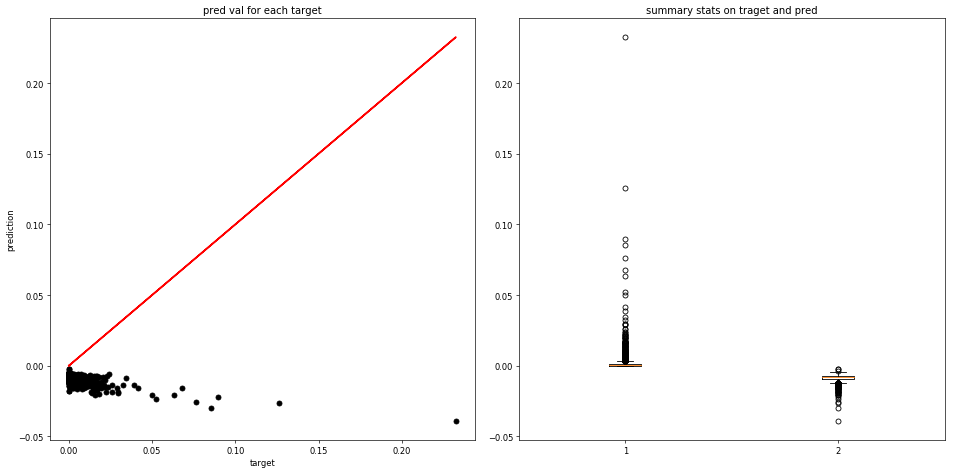

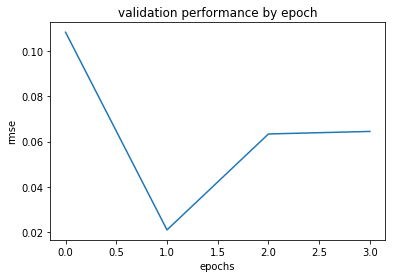

seed:  47
Val Loss: 0.0195, Test Accuracy: 0.000 ± nan, Duration: 0.035


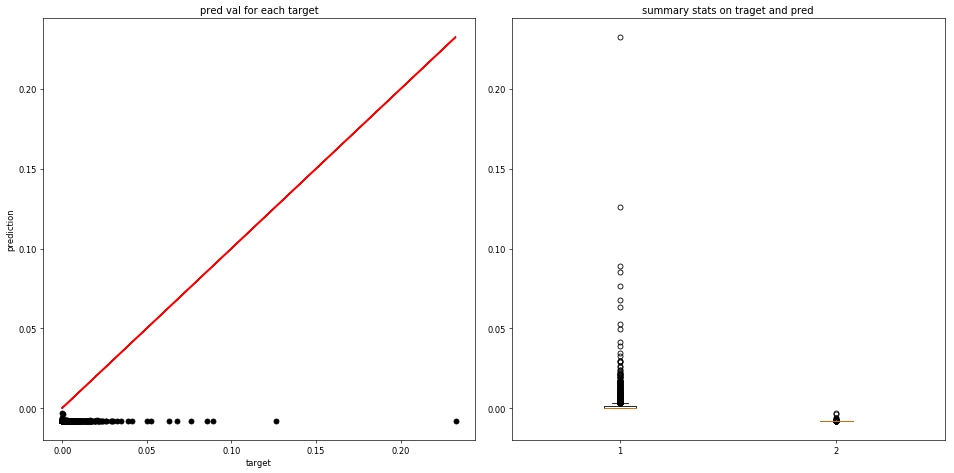

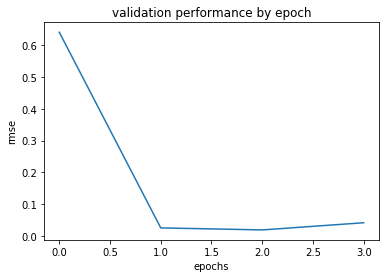

seed:  48
Val Loss: 0.0086, Test Accuracy: 0.000 ± nan, Duration: 0.025


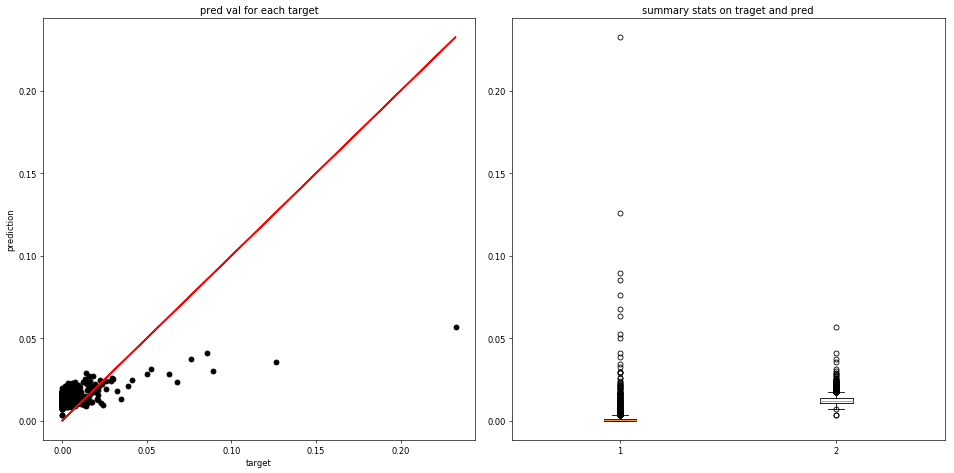

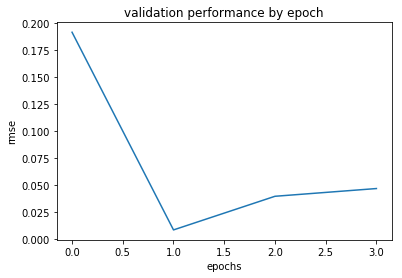

seed:  49
Val Loss: 0.0058, Test Accuracy: 0.000 ± nan, Duration: 0.026


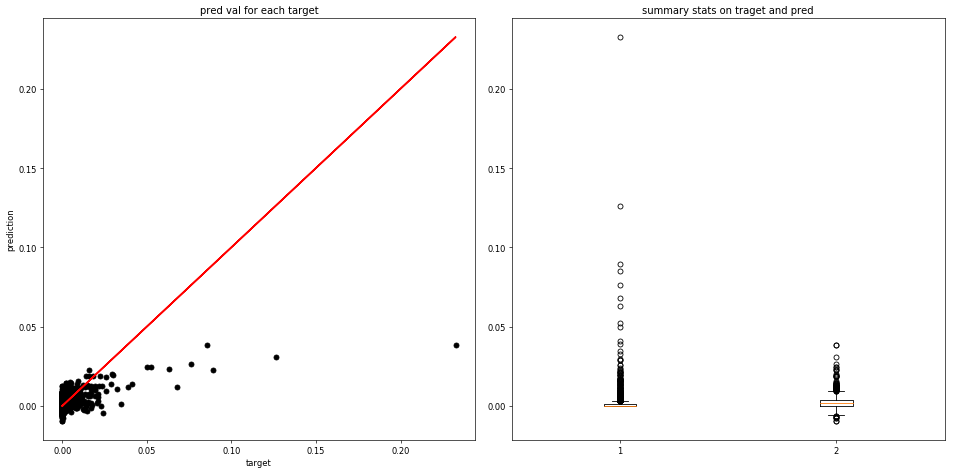

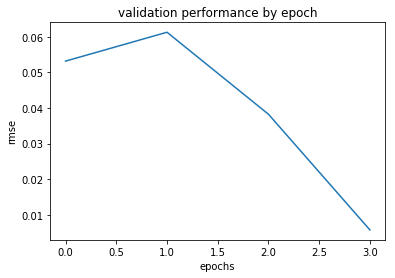

seed:  50
Val Loss: 0.0087, Test Accuracy: 0.000 ± nan, Duration: 0.042


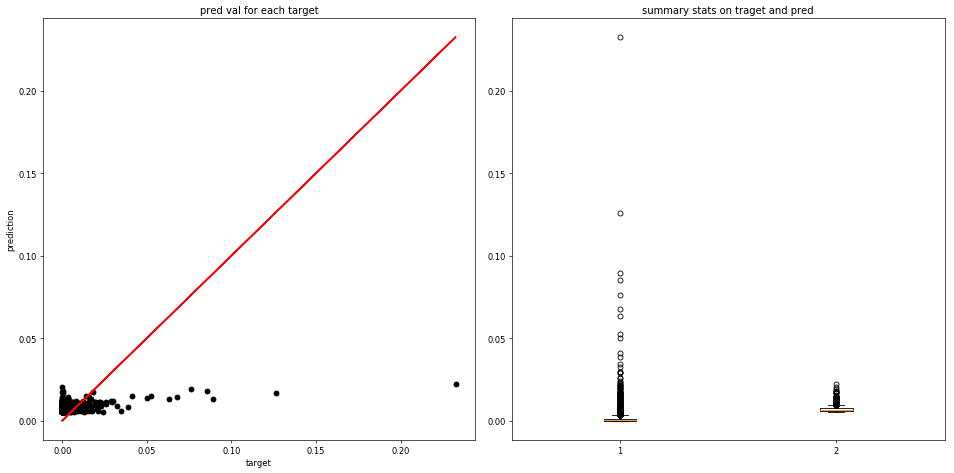

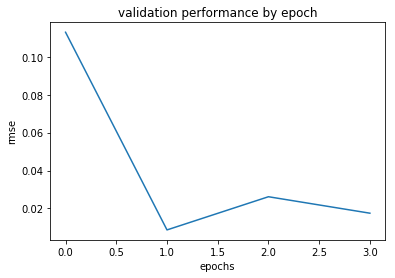

seed:  51
Val Loss: 0.0129, Test Accuracy: 0.000 ± nan, Duration: 0.026


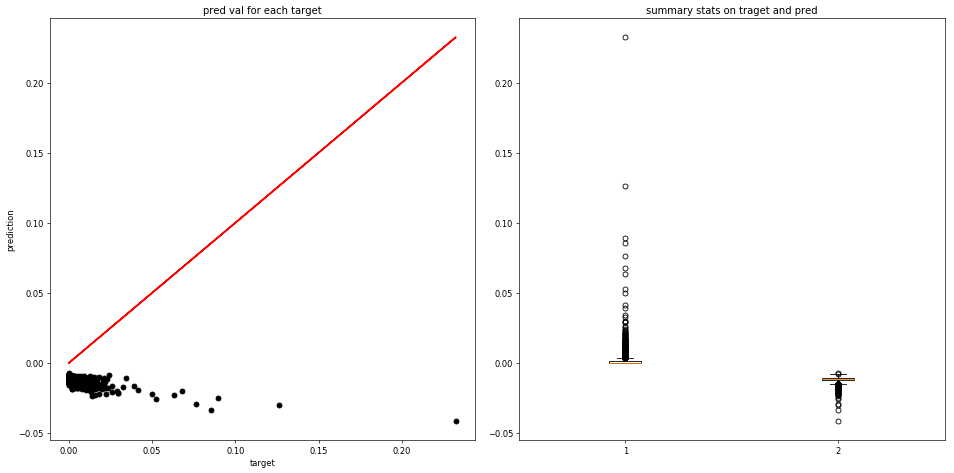

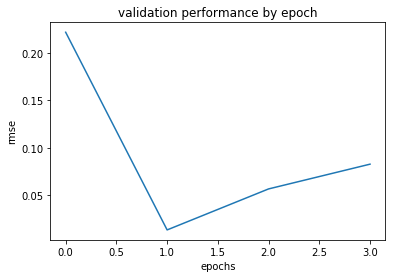

seed:  52
Val Loss: 0.0111, Test Accuracy: 0.000 ± nan, Duration: 0.031


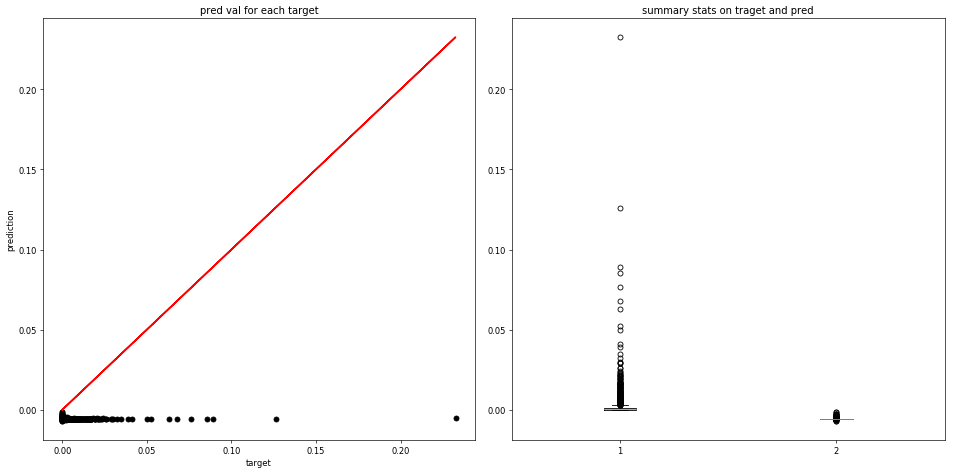

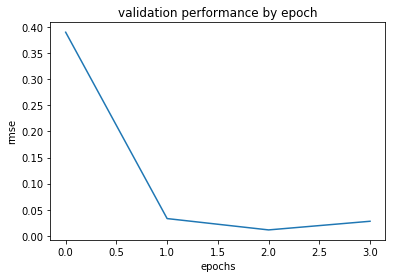

seed:  53
Val Loss: 0.0200, Test Accuracy: 0.000 ± nan, Duration: 0.033


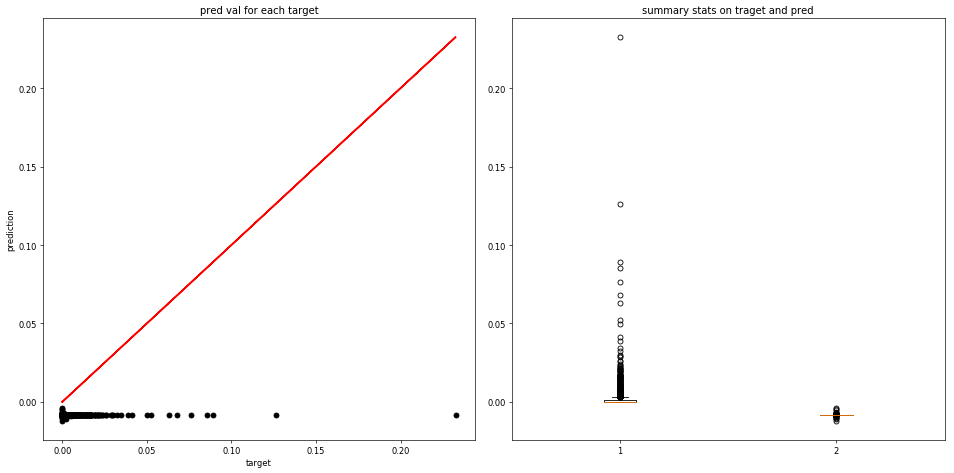

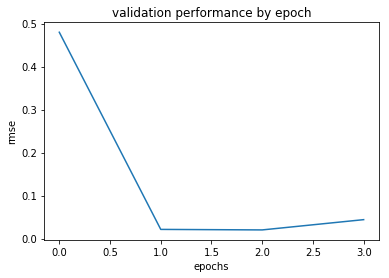

seed:  54
Val Loss: 0.0210, Test Accuracy: 0.000 ± nan, Duration: 0.026


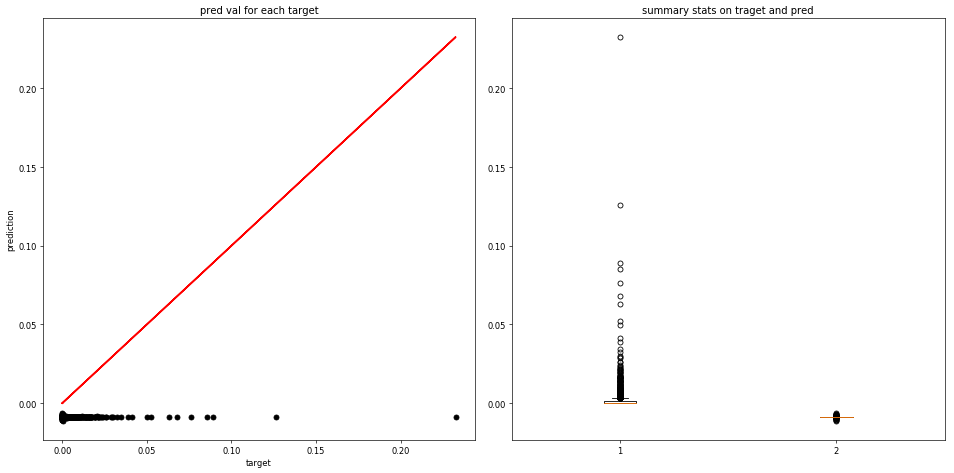

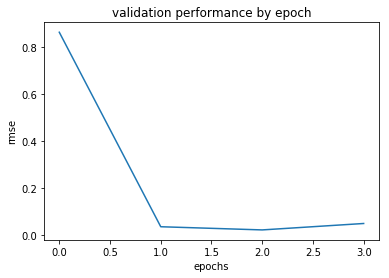

seed:  55
Val Loss: 0.0090, Test Accuracy: 0.000 ± nan, Duration: 0.028


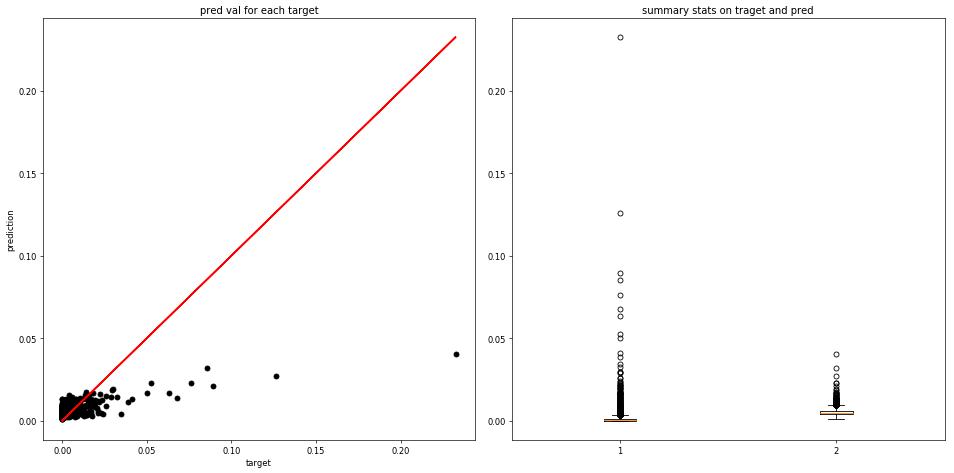

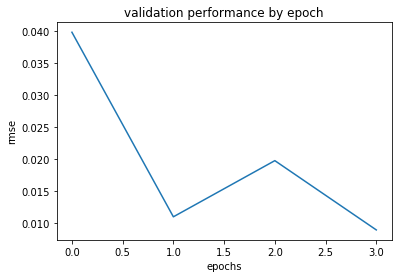

seed:  56
Val Loss: 0.0112, Test Accuracy: 0.000 ± nan, Duration: 0.025


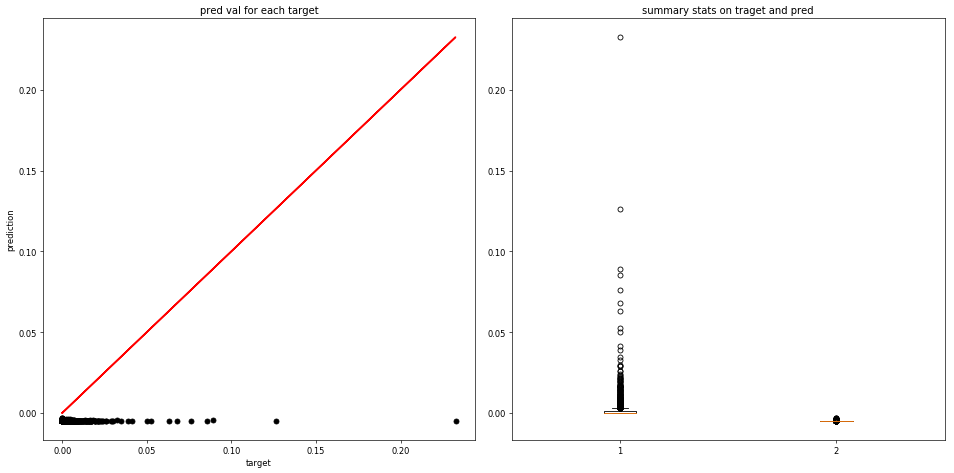

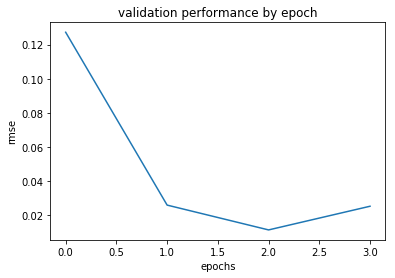

seed:  57
Val Loss: 0.0125, Test Accuracy: 0.000 ± nan, Duration: 0.036


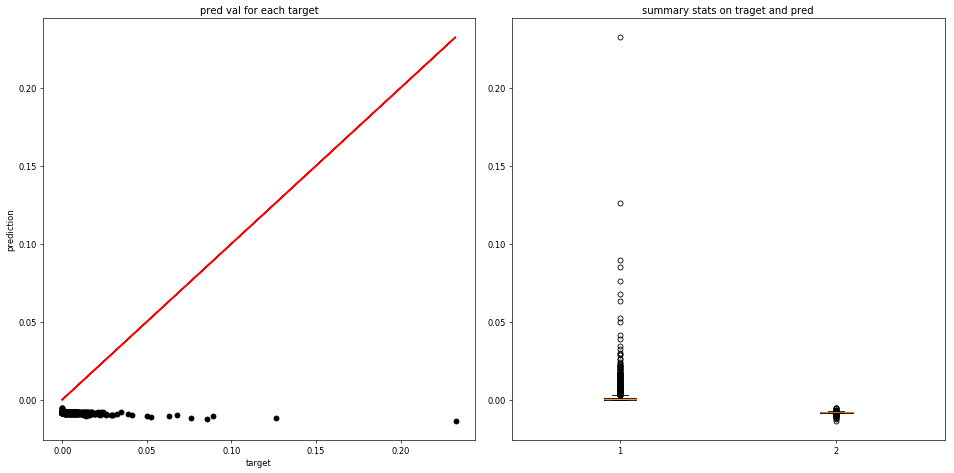

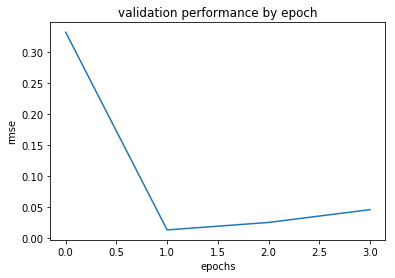

seed:  58
Val Loss: 0.0136, Test Accuracy: 0.000 ± nan, Duration: 0.042


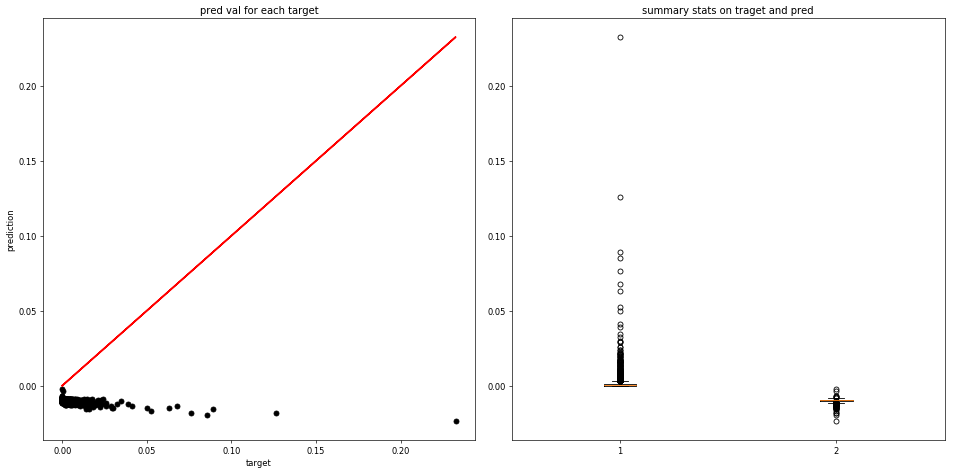

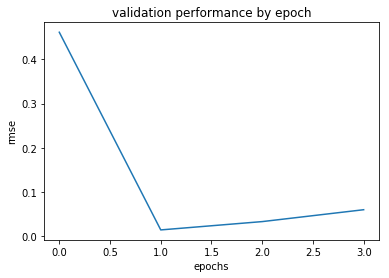

seed:  59
Val Loss: 0.0140, Test Accuracy: 0.000 ± nan, Duration: 0.034


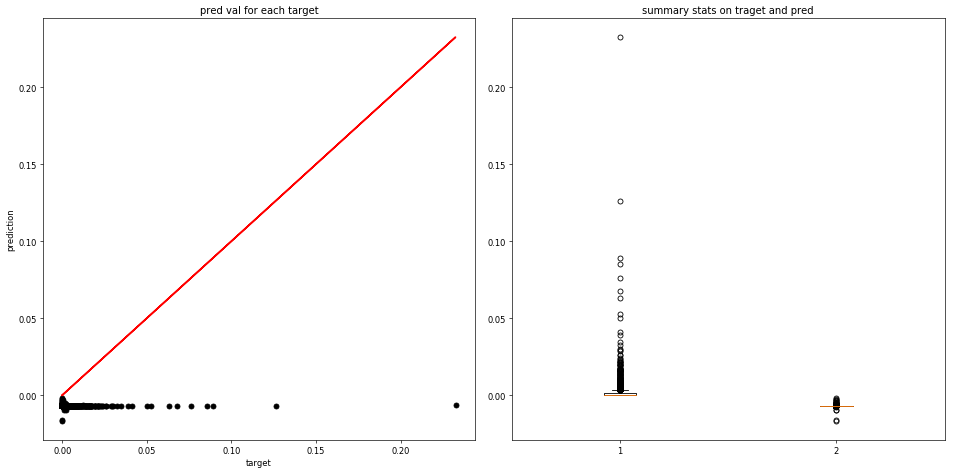

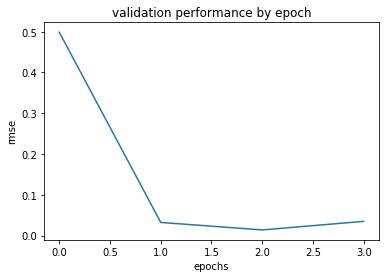

seed:  60
Val Loss: 0.0111, Test Accuracy: 0.000 ± nan, Duration: 0.032


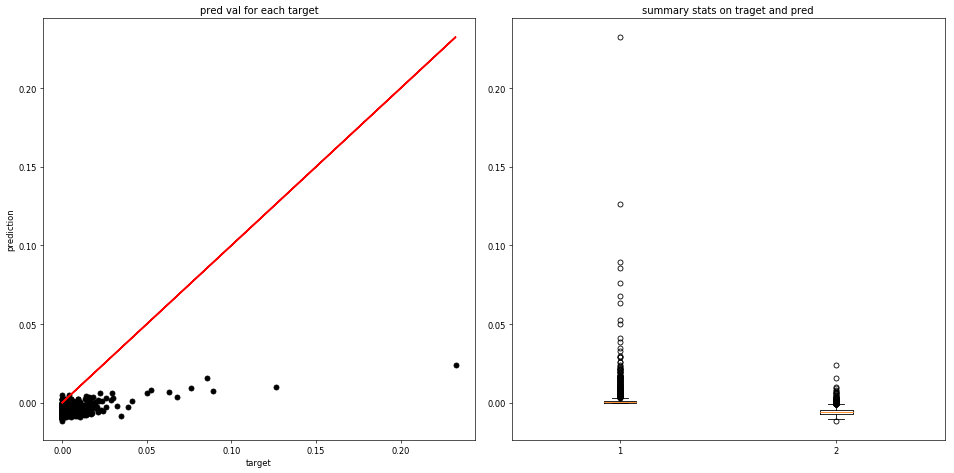

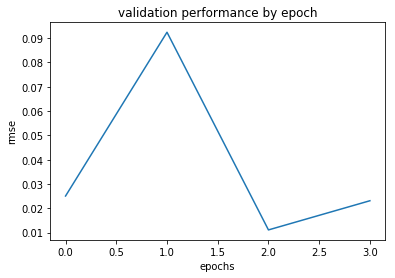

seed:  61
Val Loss: 0.0152, Test Accuracy: 0.000 ± nan, Duration: 0.025


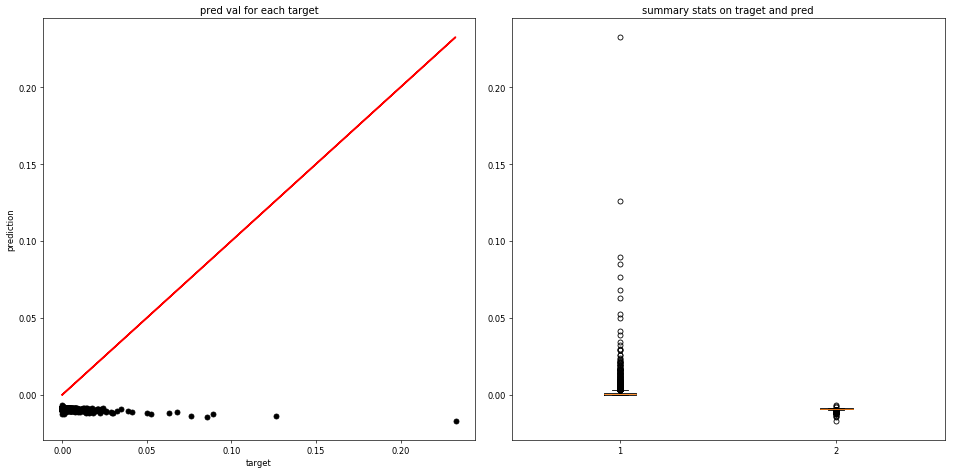

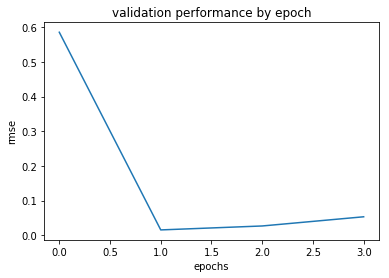

seed:  62
Val Loss: 0.0105, Test Accuracy: 0.000 ± nan, Duration: 0.025


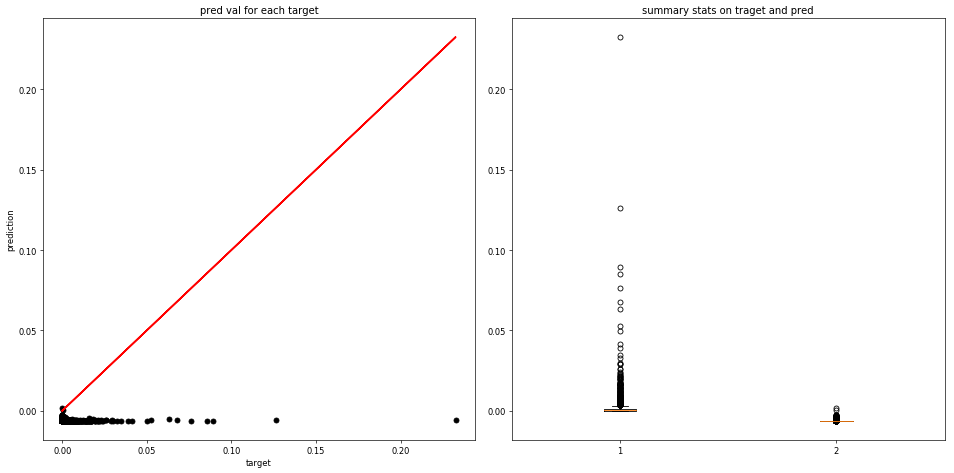

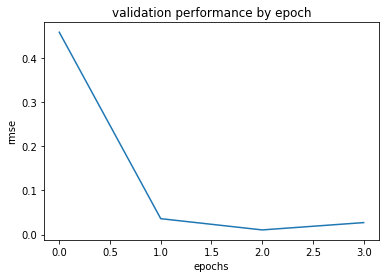

seed:  63
Val Loss: 0.0113, Test Accuracy: 0.000 ± nan, Duration: 0.044


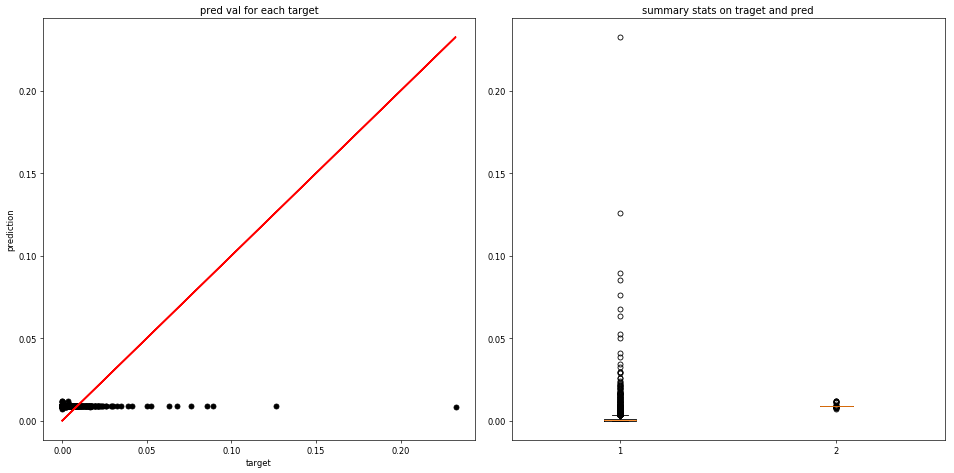

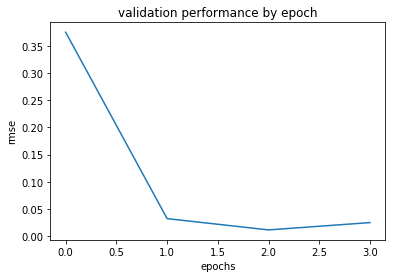

seed:  64
Val Loss: 0.0110, Test Accuracy: 0.000 ± nan, Duration: 0.036


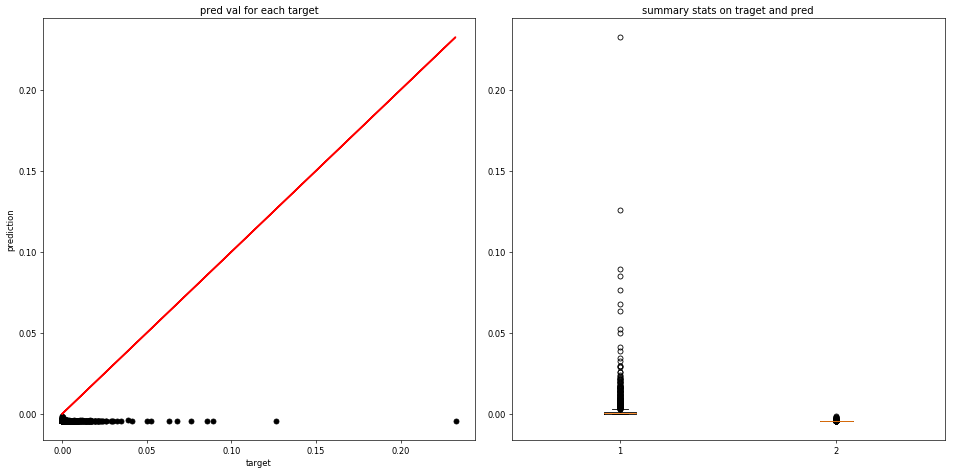

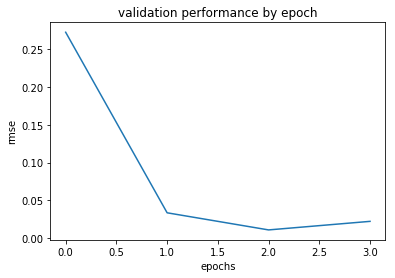

seed:  65
Val Loss: 0.0106, Test Accuracy: 0.000 ± nan, Duration: 0.044


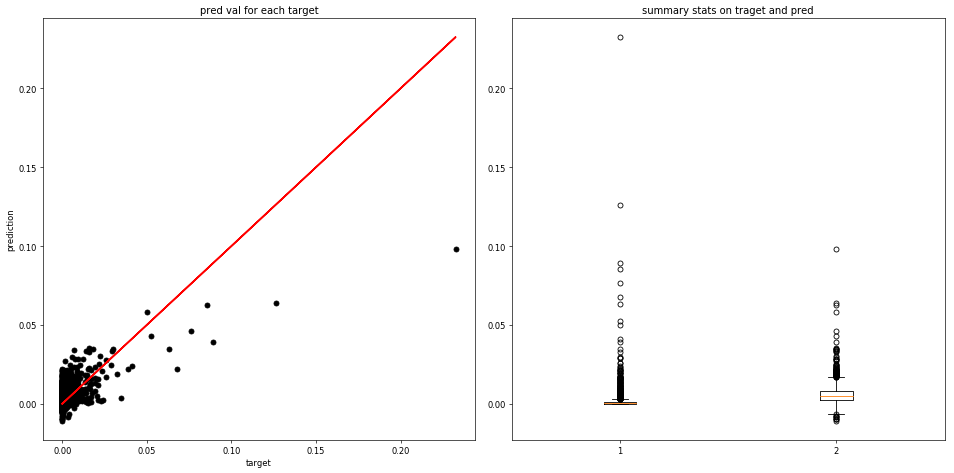

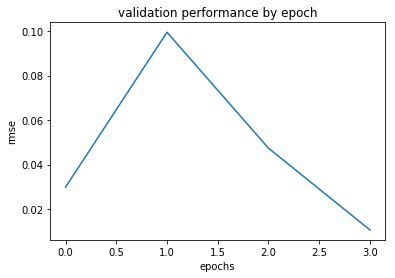

seed:  66
Val Loss: 0.0188, Test Accuracy: 0.000 ± nan, Duration: 0.028


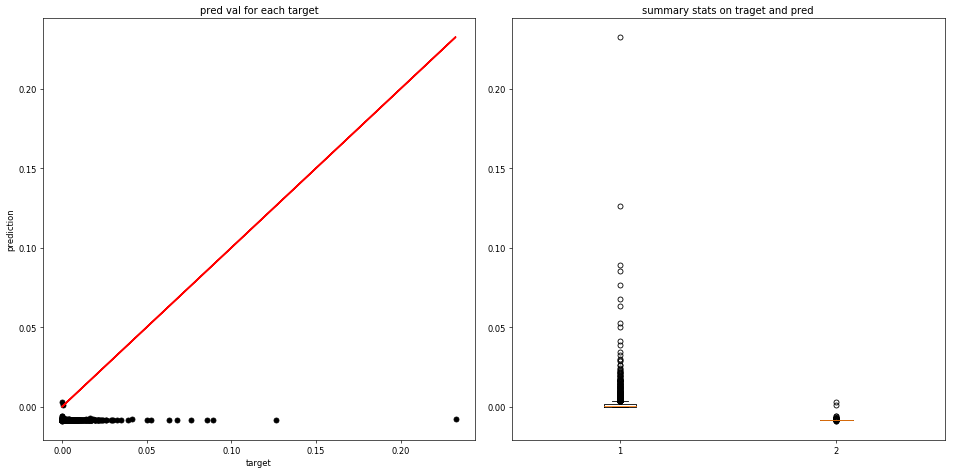

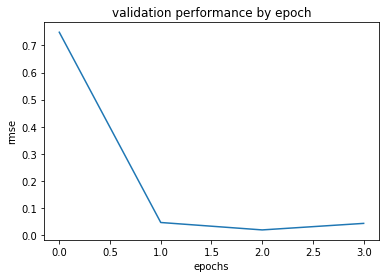

seed:  67
Val Loss: 0.0113, Test Accuracy: 0.000 ± nan, Duration: 0.028


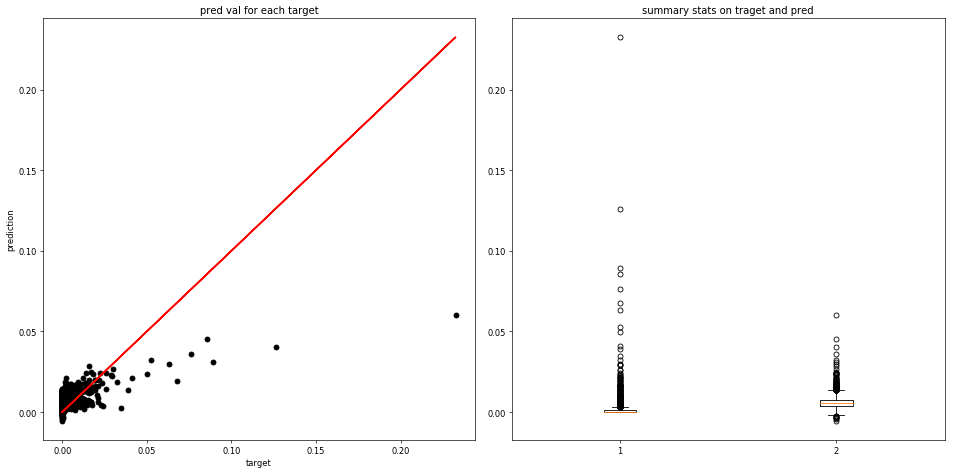

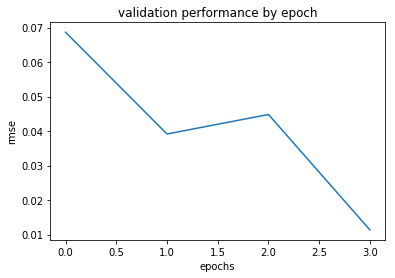

seed:  68
Val Loss: 0.0157, Test Accuracy: 0.000 ± nan, Duration: 0.038


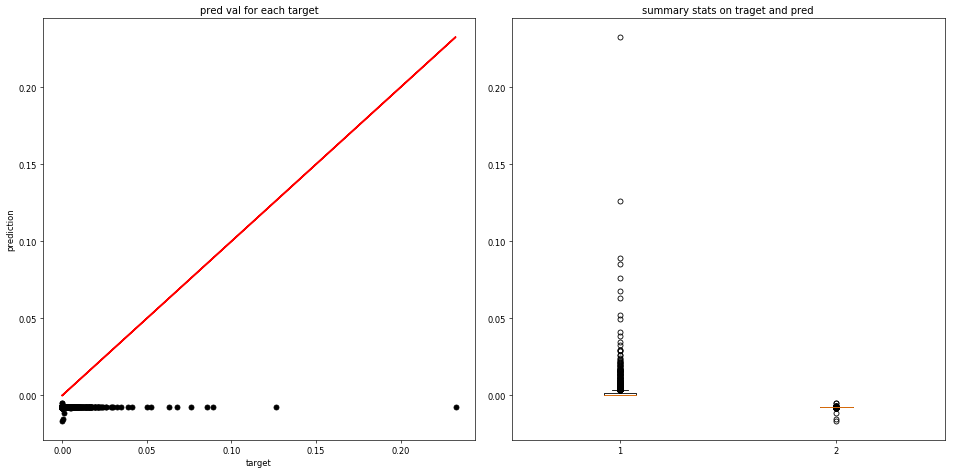

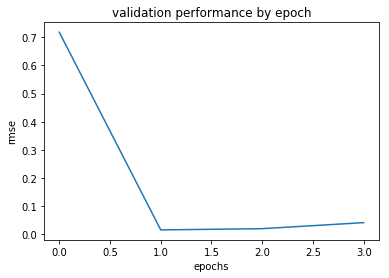

seed:  69
Val Loss: 0.0070, Test Accuracy: 0.000 ± nan, Duration: 0.027


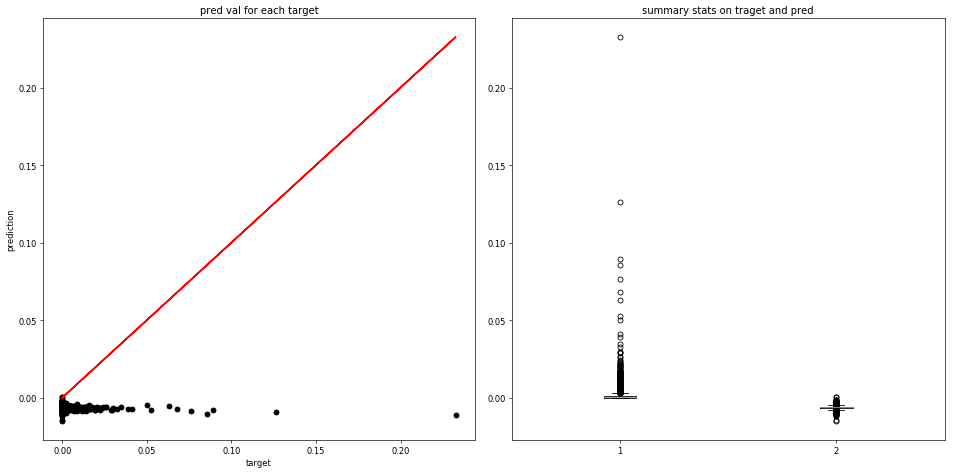

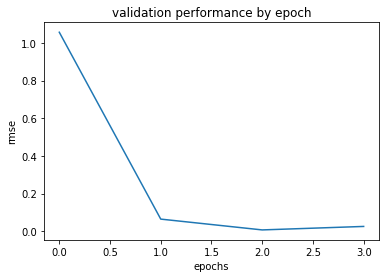

seed:  70
Val Loss: 0.0145, Test Accuracy: 0.000 ± nan, Duration: 0.040


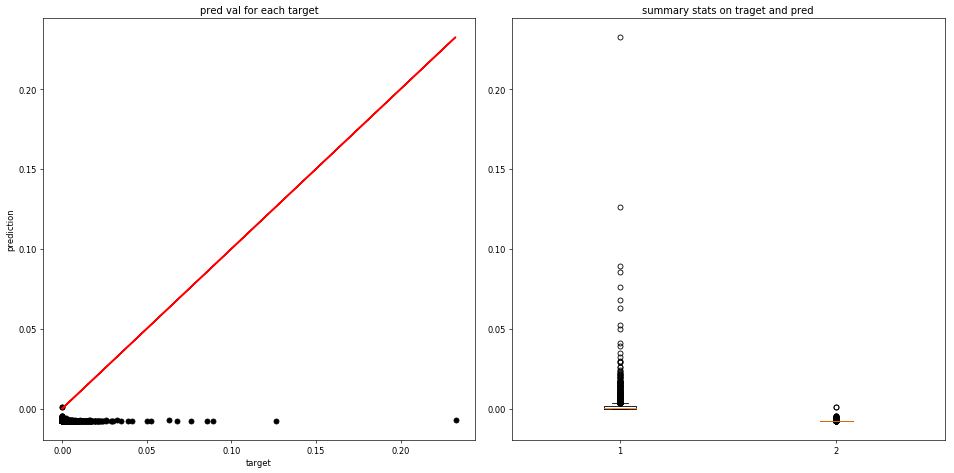

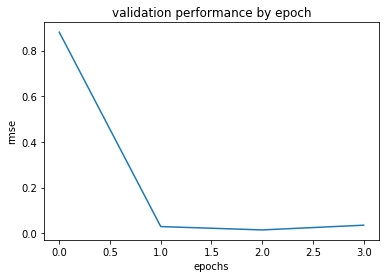

seed:  71
Val Loss: 0.0070, Test Accuracy: 0.000 ± nan, Duration: 0.035


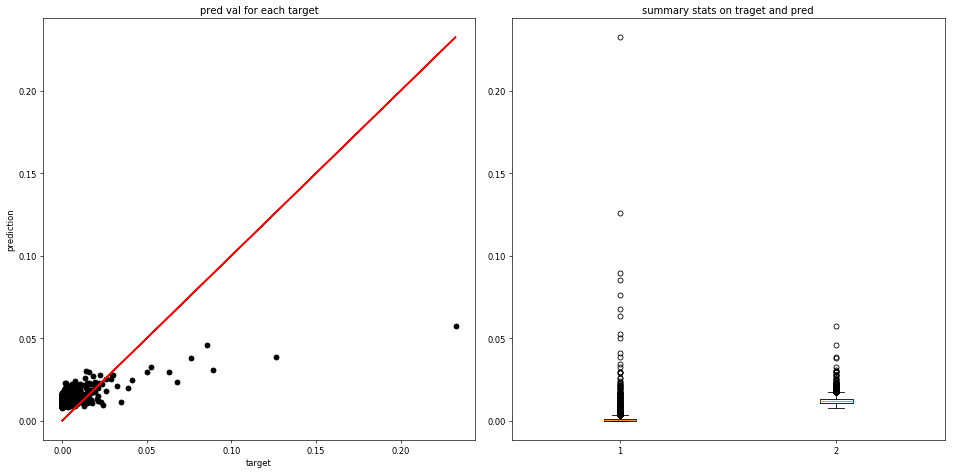

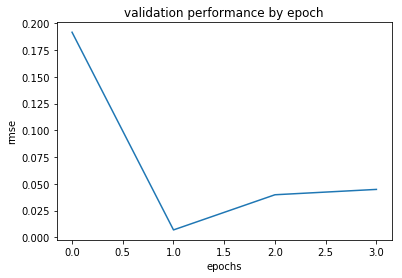

seed:  72
Val Loss: 0.0173, Test Accuracy: 0.000 ± nan, Duration: 0.026


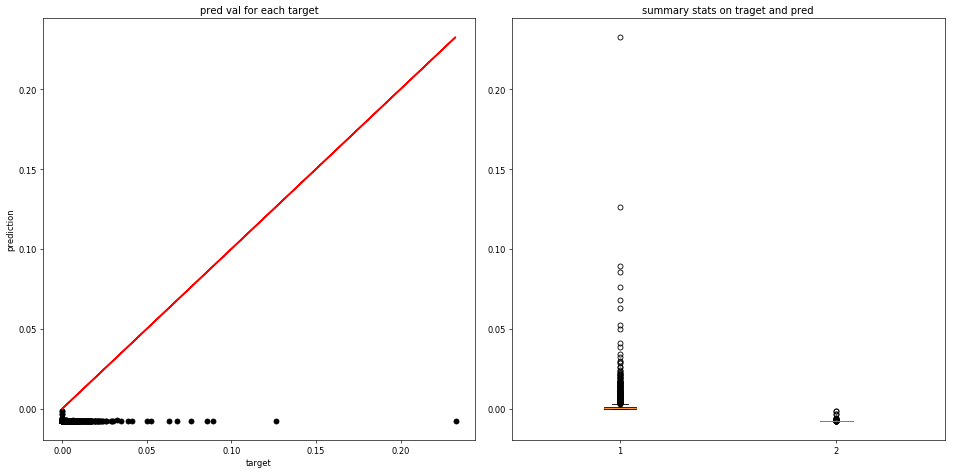

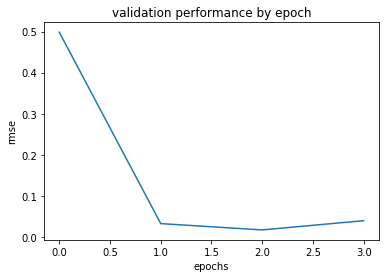

seed:  73
Val Loss: 0.0128, Test Accuracy: 0.000 ± nan, Duration: 0.042


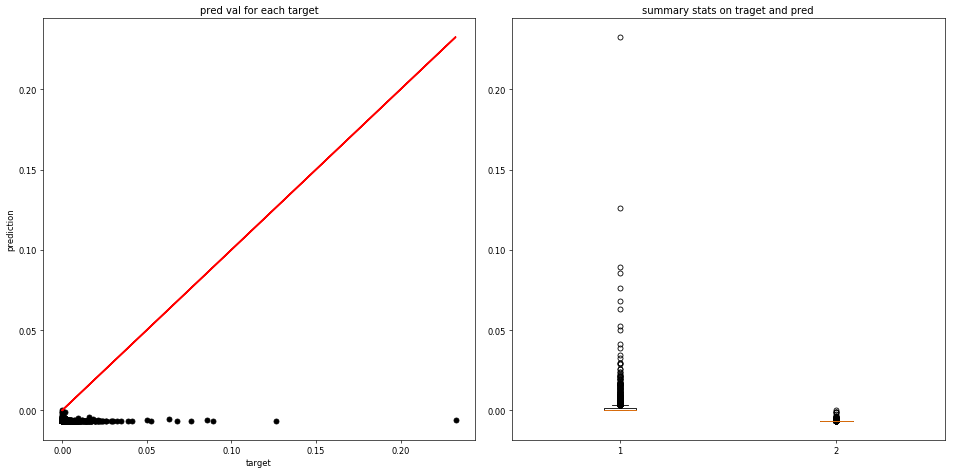

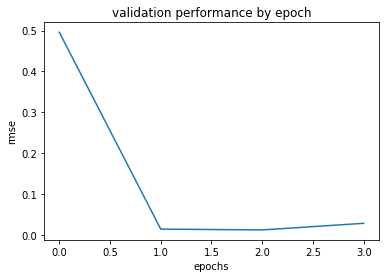

seed:  74
Val Loss: 0.0103, Test Accuracy: 0.000 ± nan, Duration: 0.027


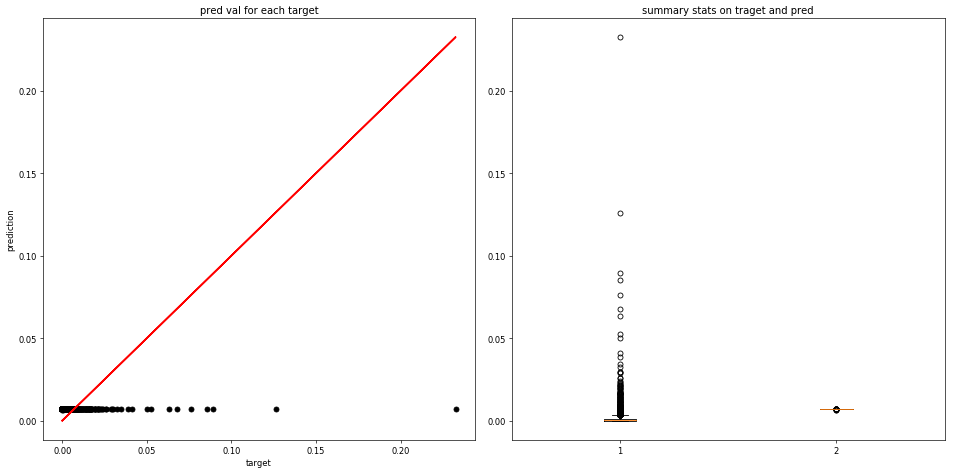

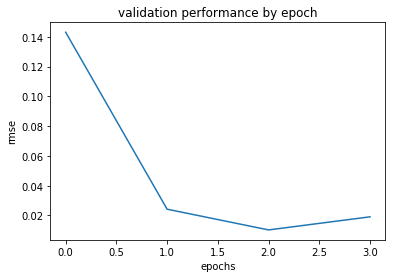

seed:  75
Val Loss: 0.0197, Test Accuracy: 0.000 ± nan, Duration: 0.029


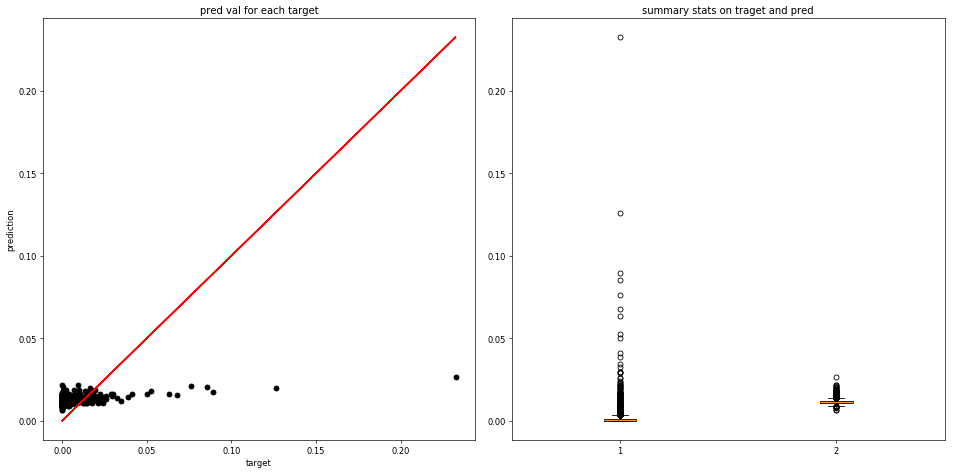

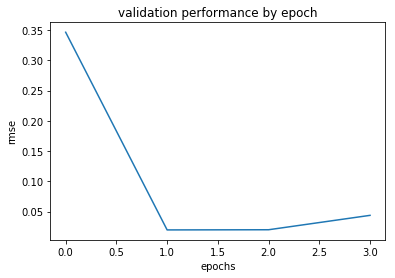

seed:  76
Val Loss: 0.0154, Test Accuracy: 0.000 ± nan, Duration: 0.031


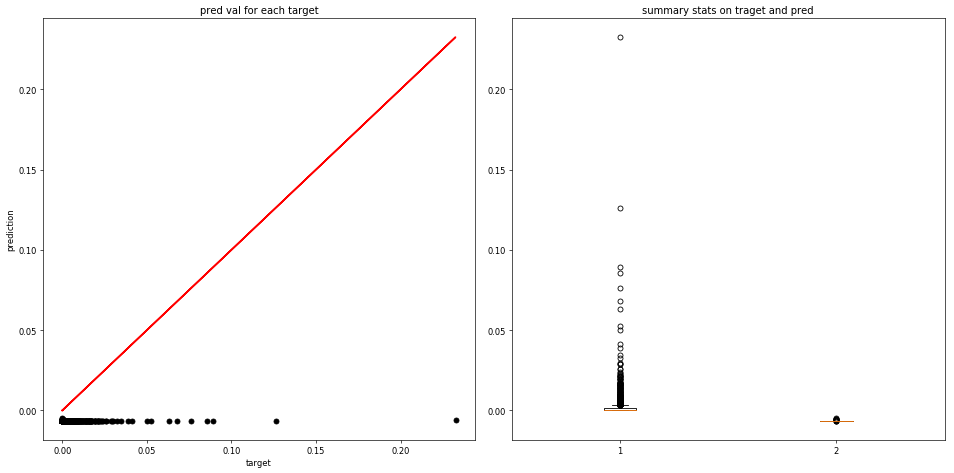

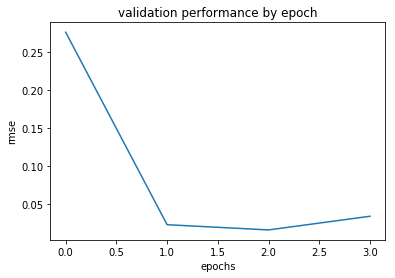

seed:  77
Val Loss: 0.0136, Test Accuracy: 0.000 ± nan, Duration: 0.025


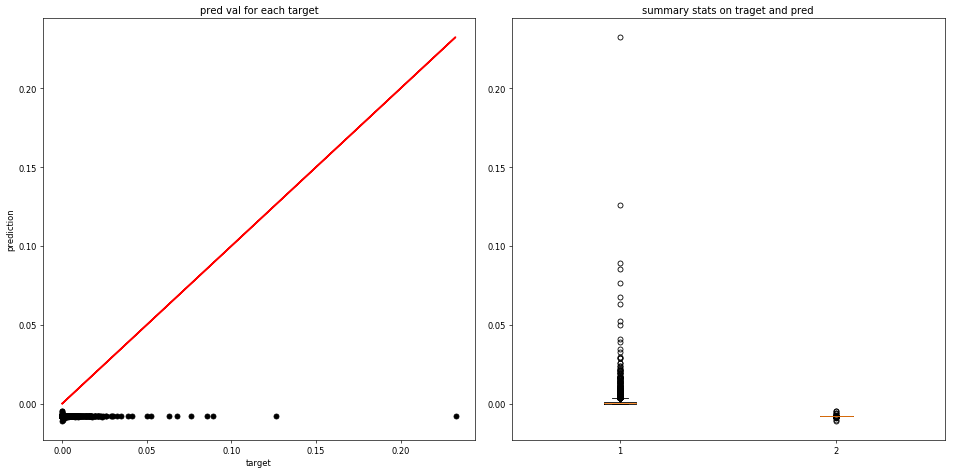

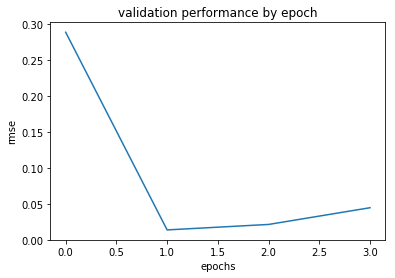

seed:  78
Val Loss: 0.0163, Test Accuracy: 0.000 ± nan, Duration: 0.026


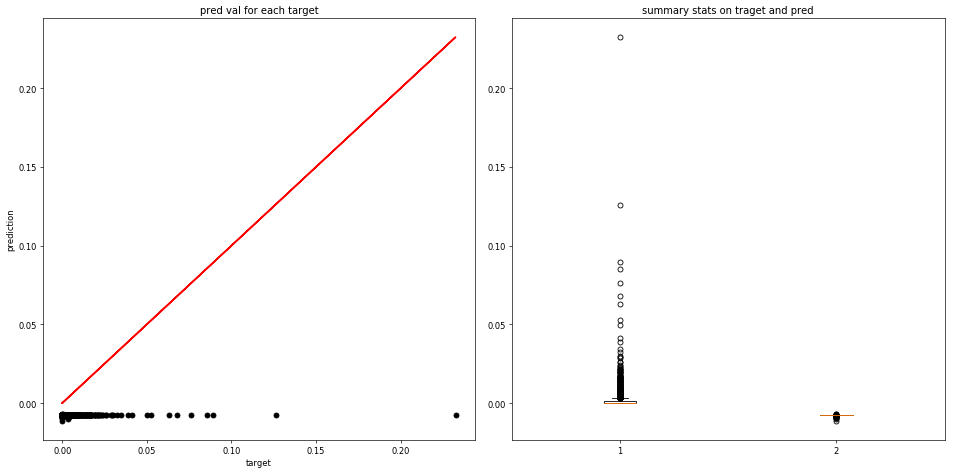

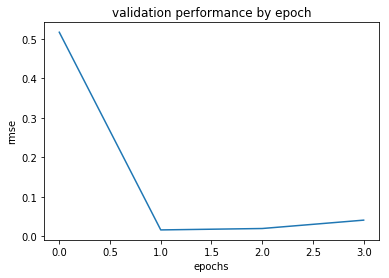

seed:  79
Val Loss: 0.0186, Test Accuracy: 0.000 ± nan, Duration: 0.027


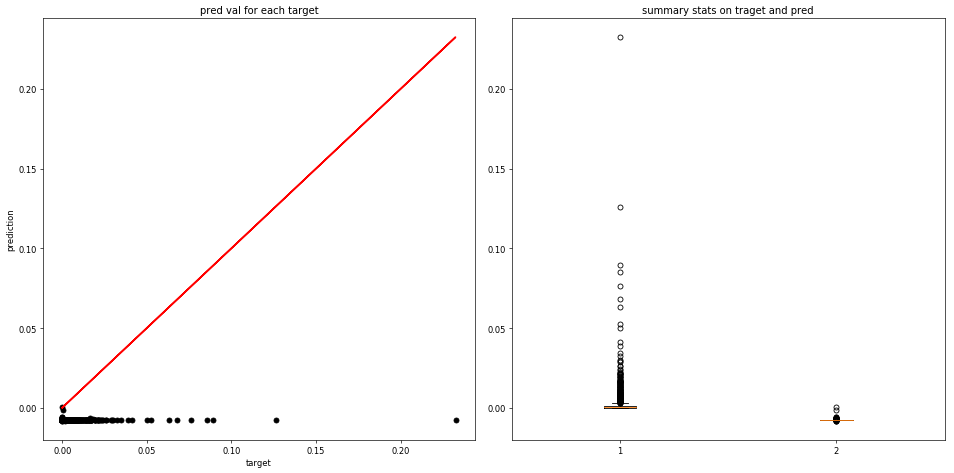

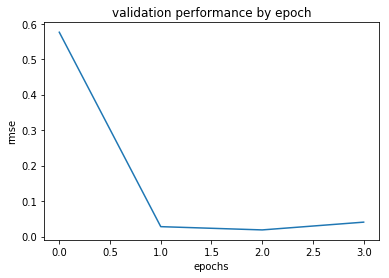

seed:  80
Val Loss: 0.0150, Test Accuracy: 0.000 ± nan, Duration: 0.025


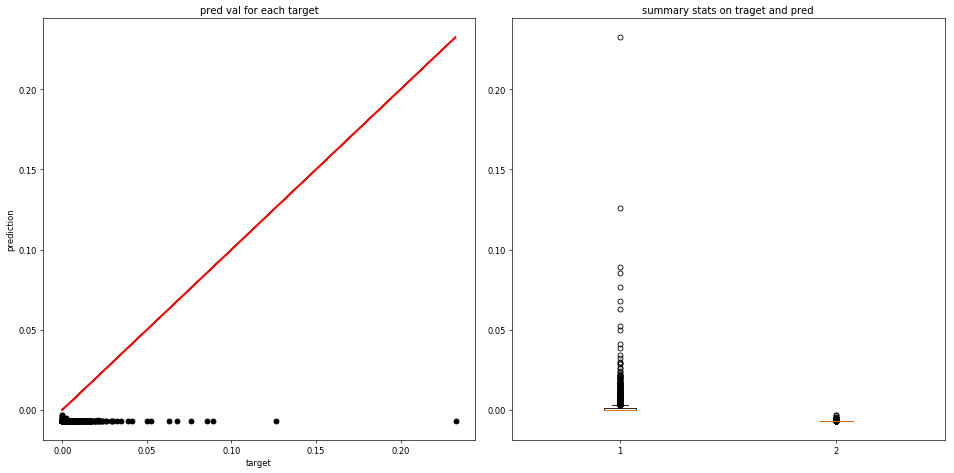

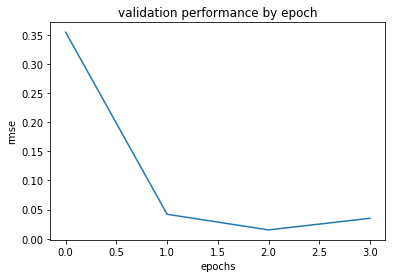

seed:  81
Val Loss: 0.0161, Test Accuracy: 0.000 ± nan, Duration: 0.028


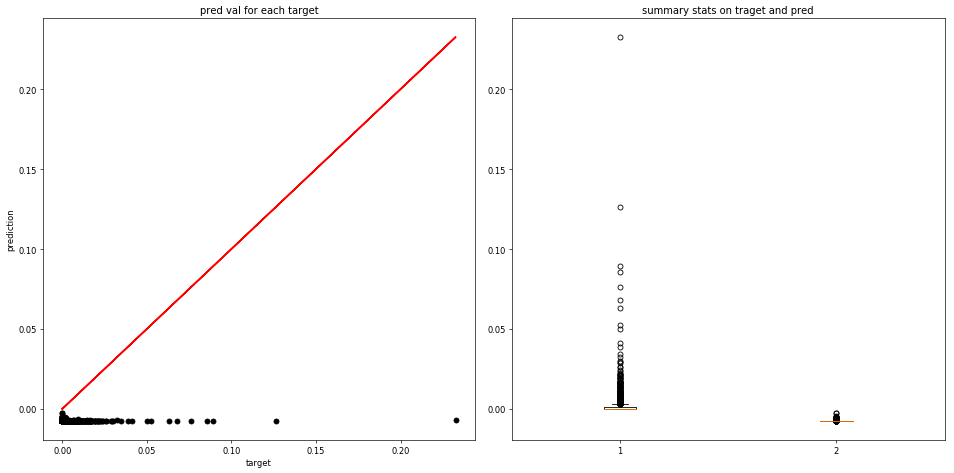

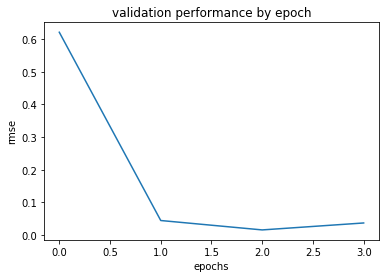

seed:  82
Val Loss: 0.0151, Test Accuracy: 0.000 ± nan, Duration: 0.036


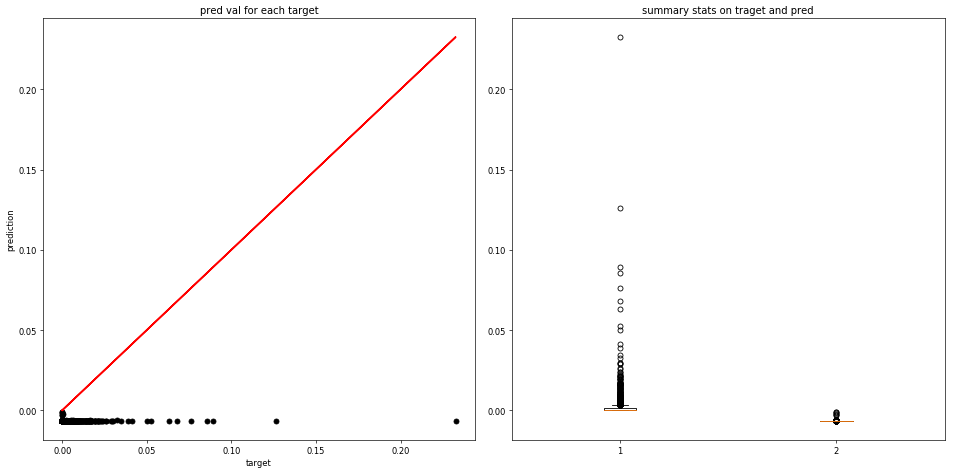

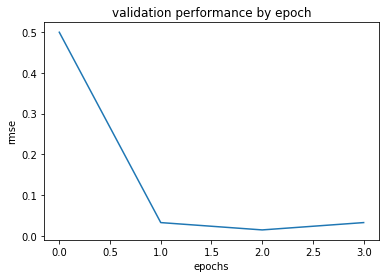

seed:  83
Val Loss: 0.0201, Test Accuracy: 0.000 ± nan, Duration: 0.036


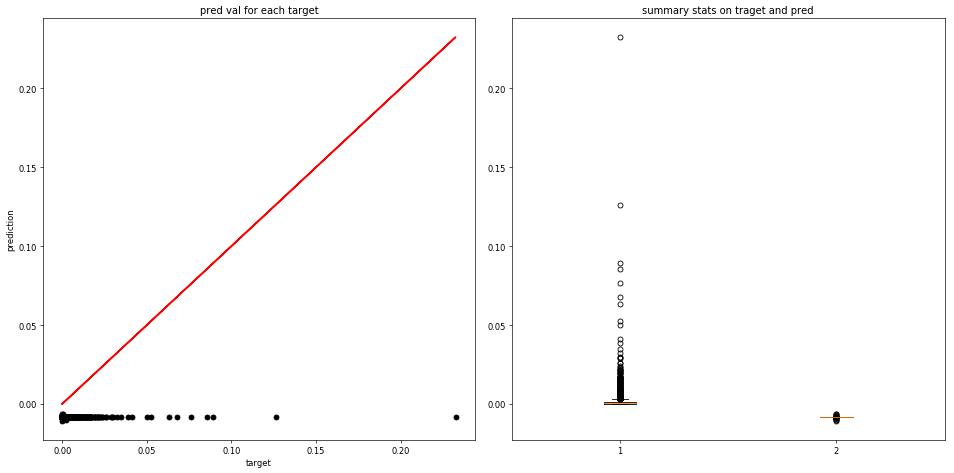

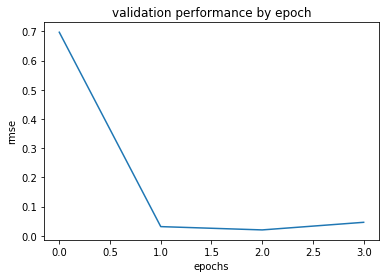

seed:  84
Val Loss: 0.0195, Test Accuracy: 0.000 ± nan, Duration: 0.027


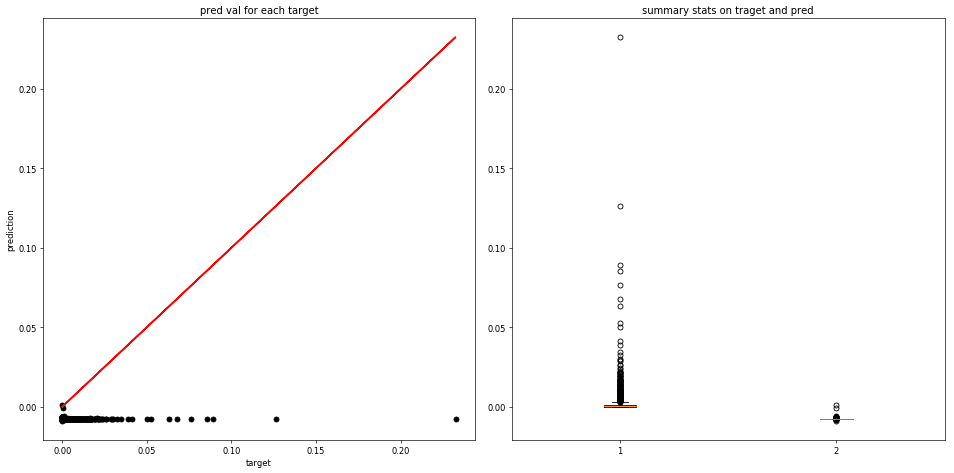

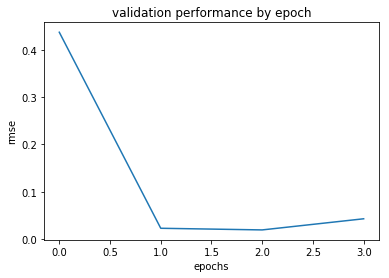

seed:  85
Val Loss: 0.0085, Test Accuracy: 0.000 ± nan, Duration: 0.033


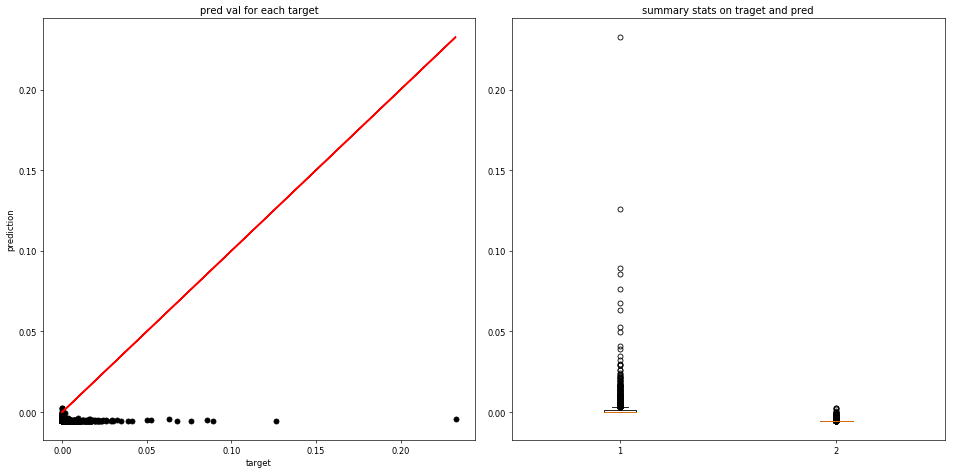

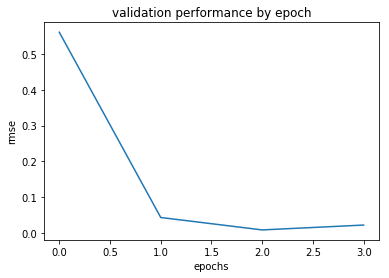

seed:  86
Val Loss: 0.0113, Test Accuracy: 0.000 ± nan, Duration: 0.041


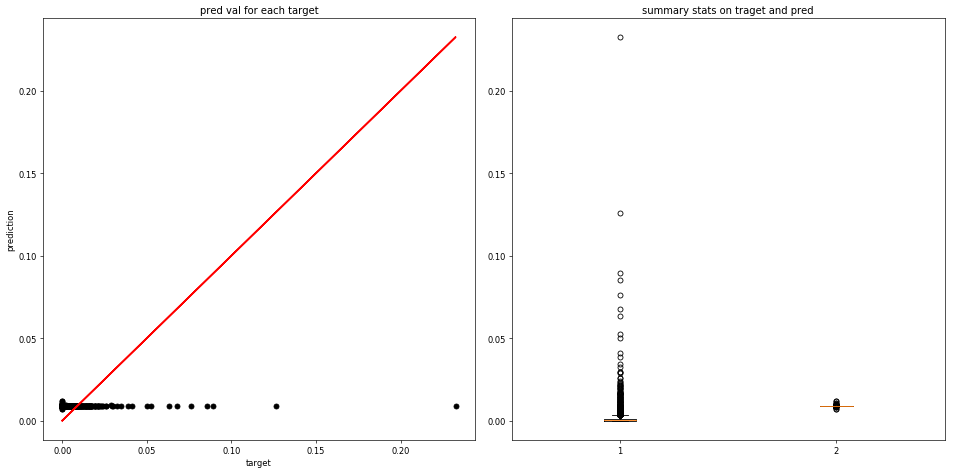

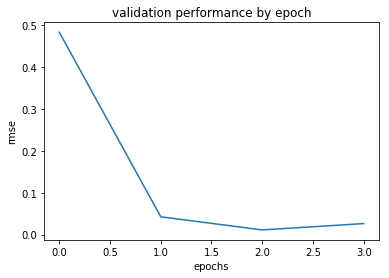

seed:  87
Val Loss: 0.0201, Test Accuracy: 0.000 ± nan, Duration: 0.025


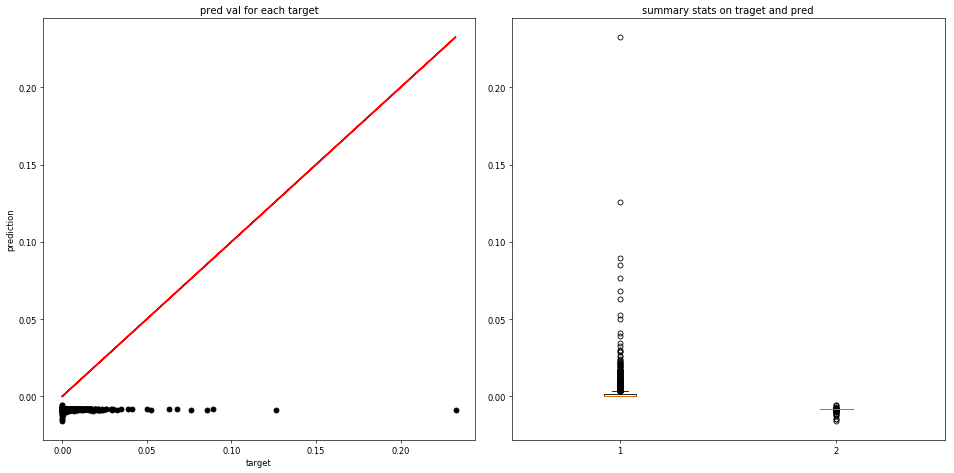

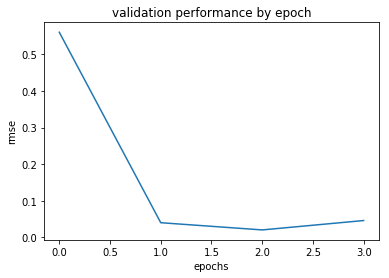

seed:  88
Val Loss: 0.0227, Test Accuracy: 0.000 ± nan, Duration: 0.028


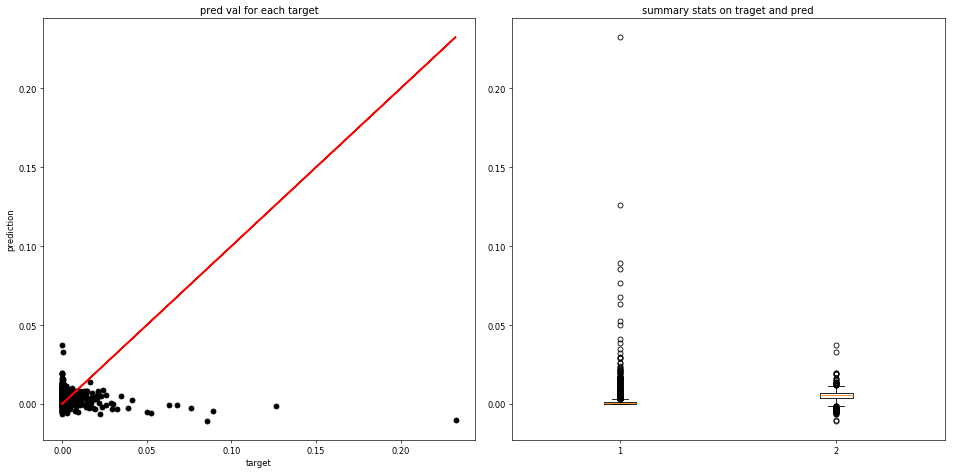

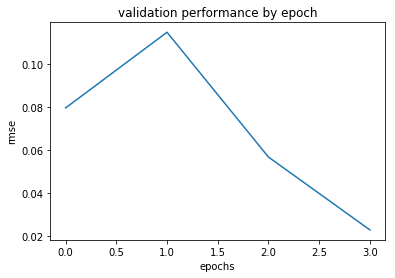

seed:  89
Val Loss: 0.0305, Test Accuracy: 0.000 ± nan, Duration: 0.026


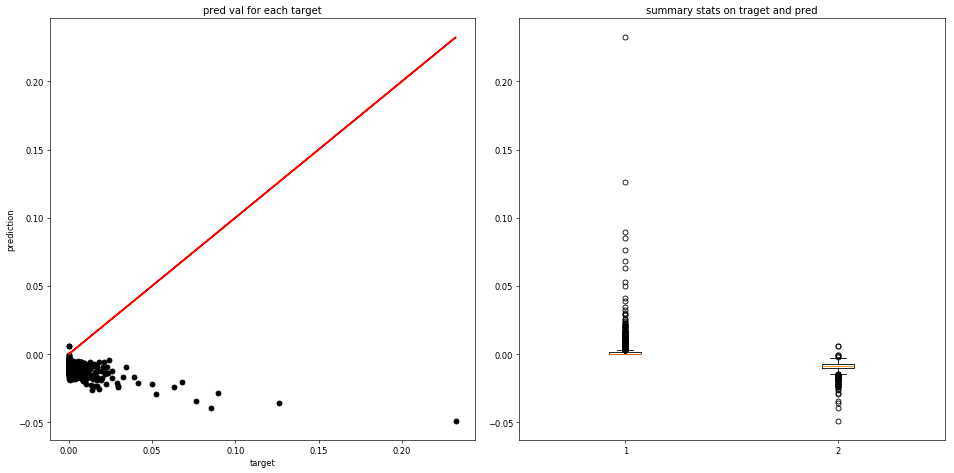

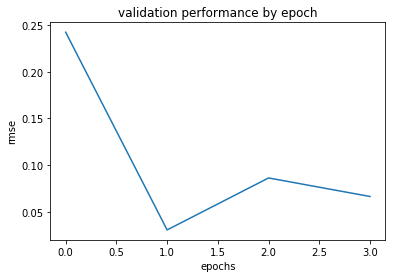

seed:  90
Val Loss: 0.0110, Test Accuracy: 0.000 ± nan, Duration: 0.025


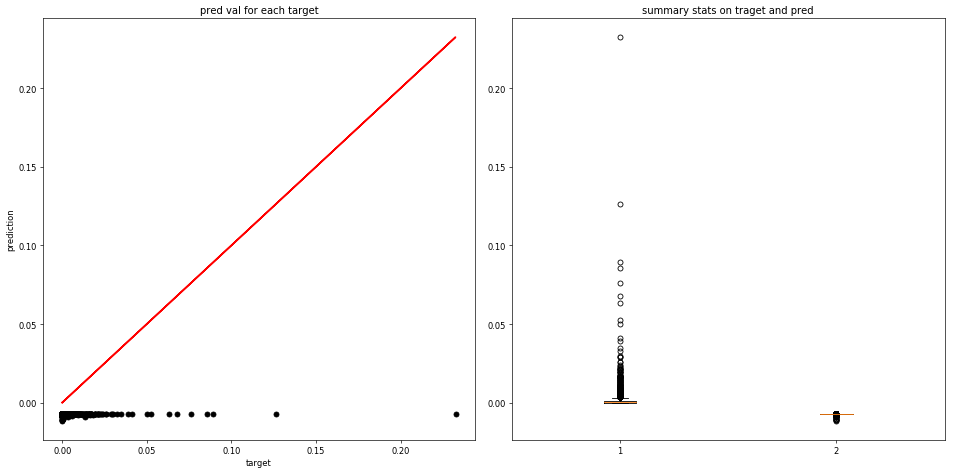

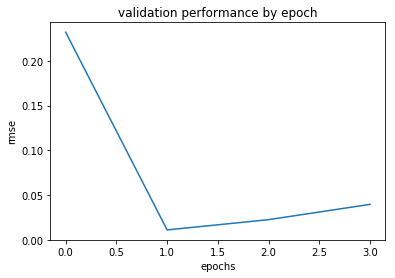

seed:  91
Val Loss: 0.0165, Test Accuracy: 0.000 ± nan, Duration: 0.024


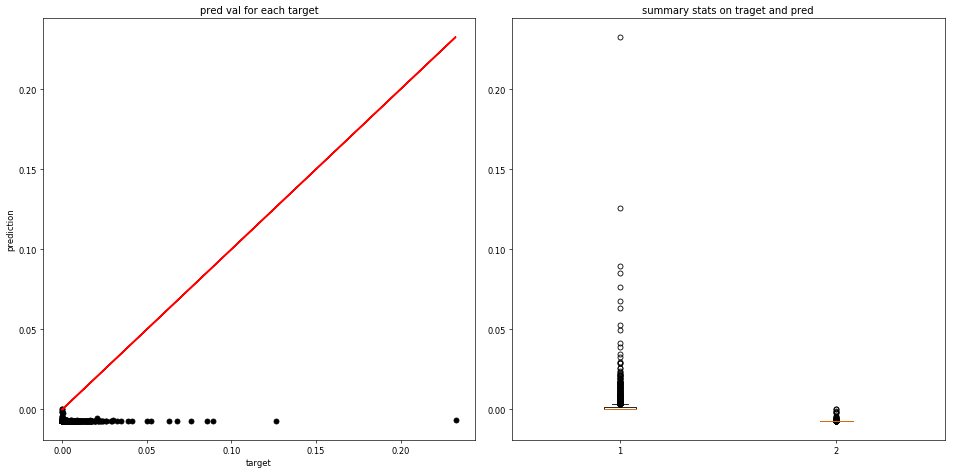

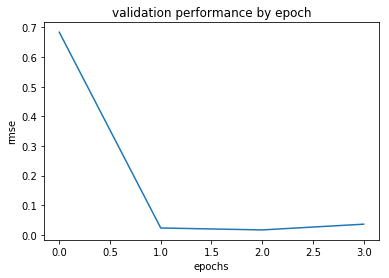

seed:  92
Val Loss: 0.0152, Test Accuracy: 0.000 ± nan, Duration: 0.024


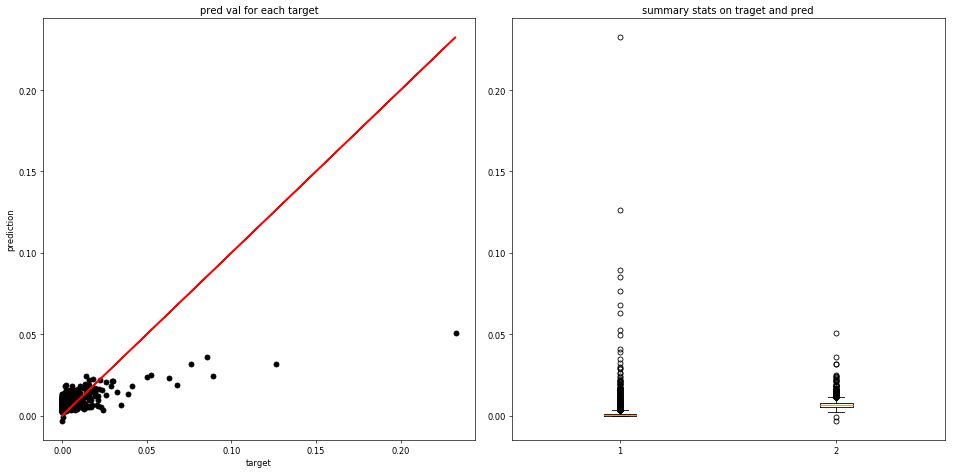

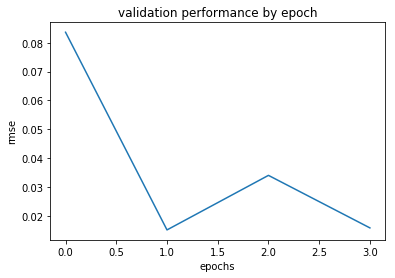

seed:  93
Val Loss: 0.0193, Test Accuracy: 0.000 ± nan, Duration: 0.030


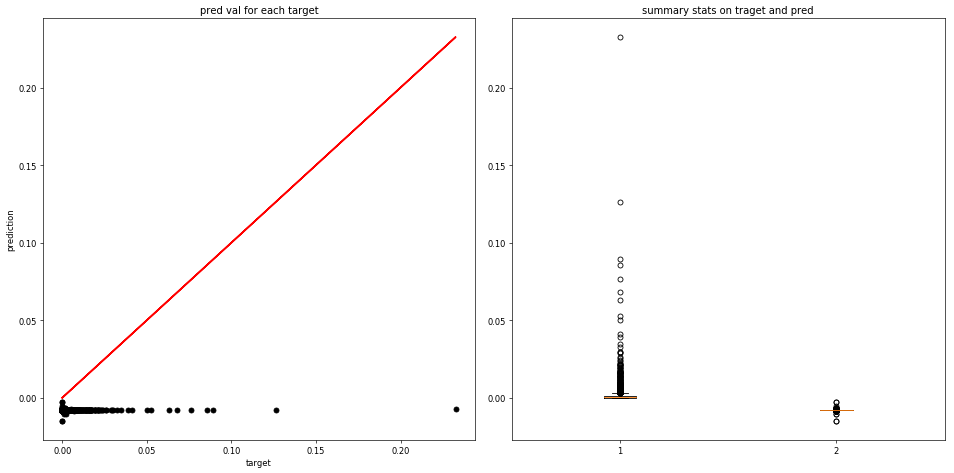

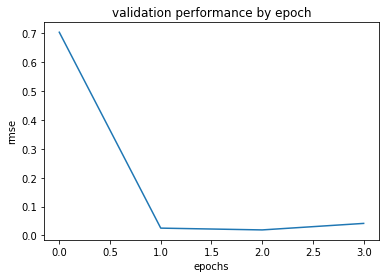

seed:  94
Val Loss: 0.0168, Test Accuracy: 0.000 ± nan, Duration: 0.029


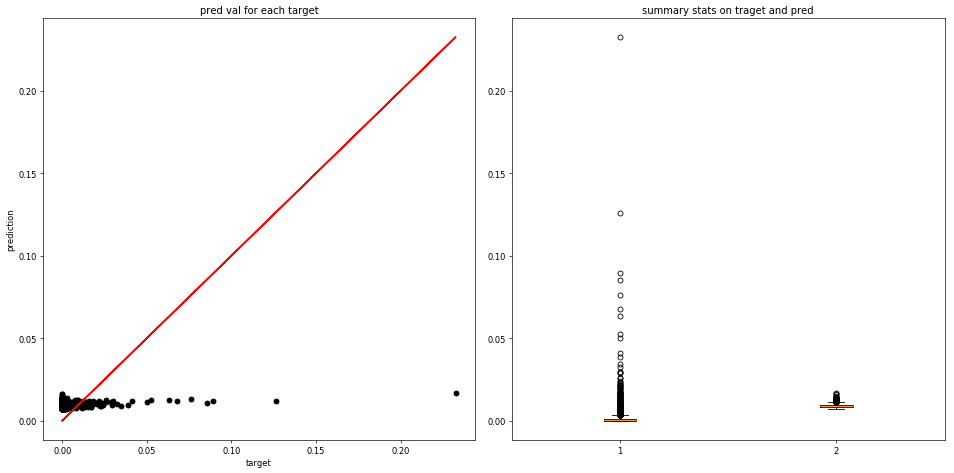

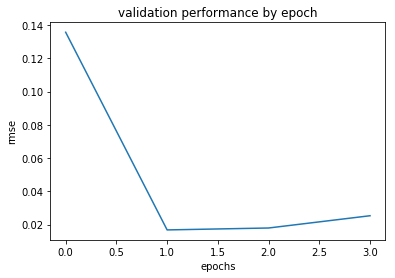

seed:  95
Val Loss: 0.0202, Test Accuracy: 0.000 ± nan, Duration: 0.031


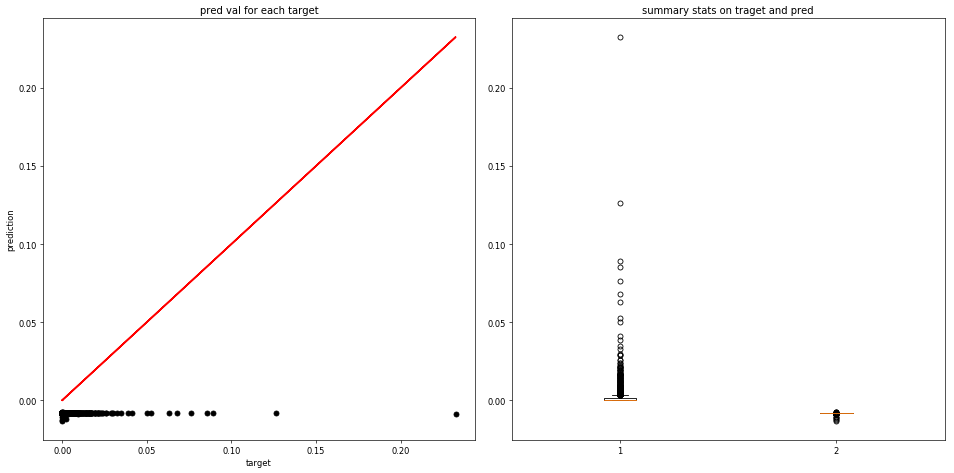

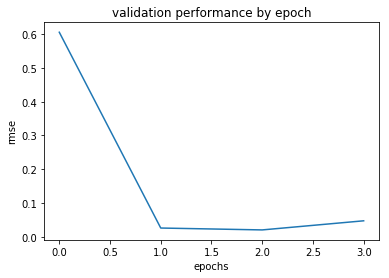

seed:  96
Val Loss: 0.0094, Test Accuracy: 0.000 ± nan, Duration: 0.032


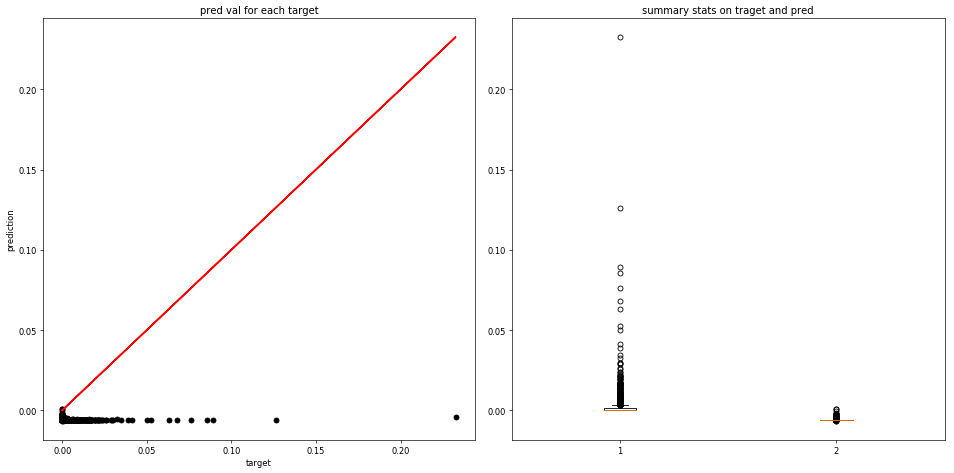

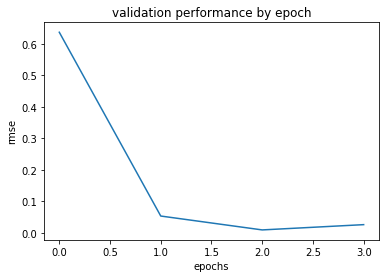

seed:  97
Val Loss: 0.0176, Test Accuracy: 0.000 ± nan, Duration: 0.039


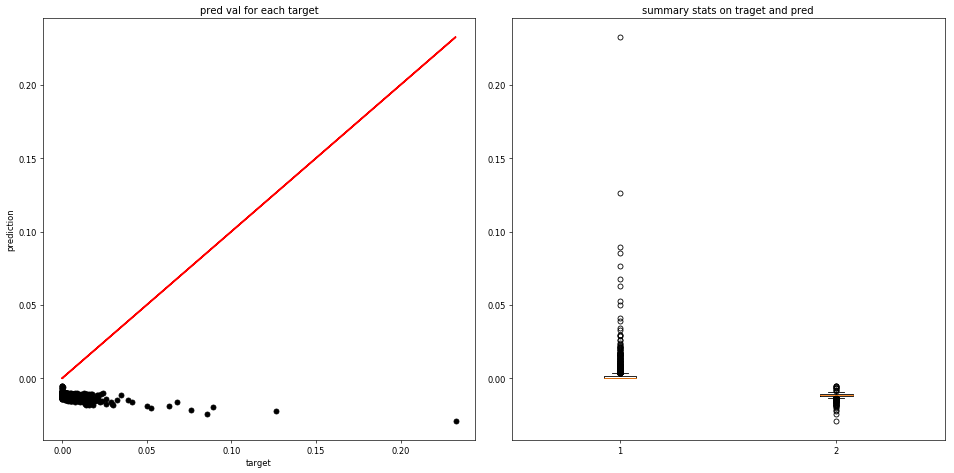

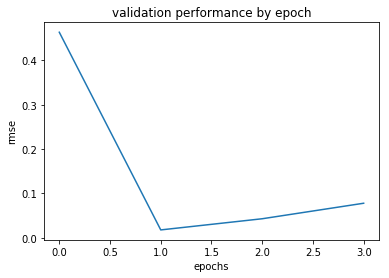

seed:  98
Val Loss: 0.0184, Test Accuracy: 0.000 ± nan, Duration: 0.027


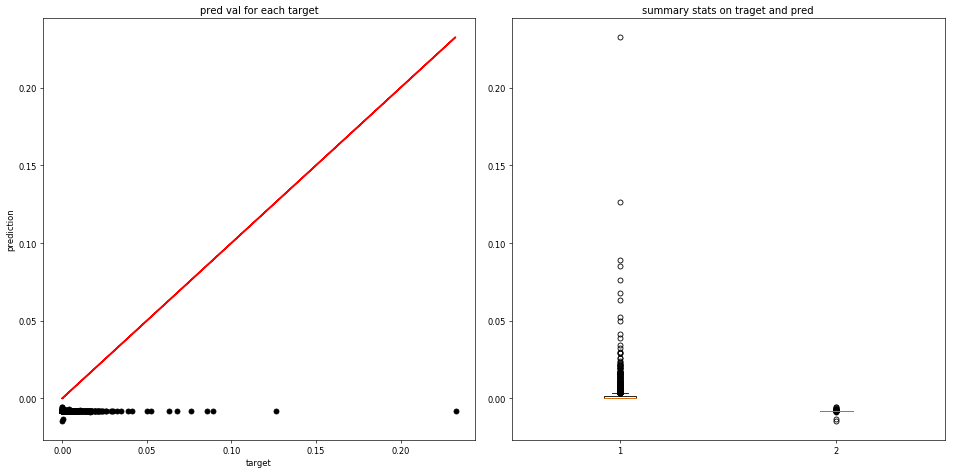

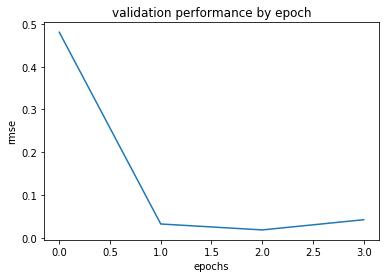

seed:  99
Val Loss: 0.0195, Test Accuracy: 0.000 ± nan, Duration: 0.035


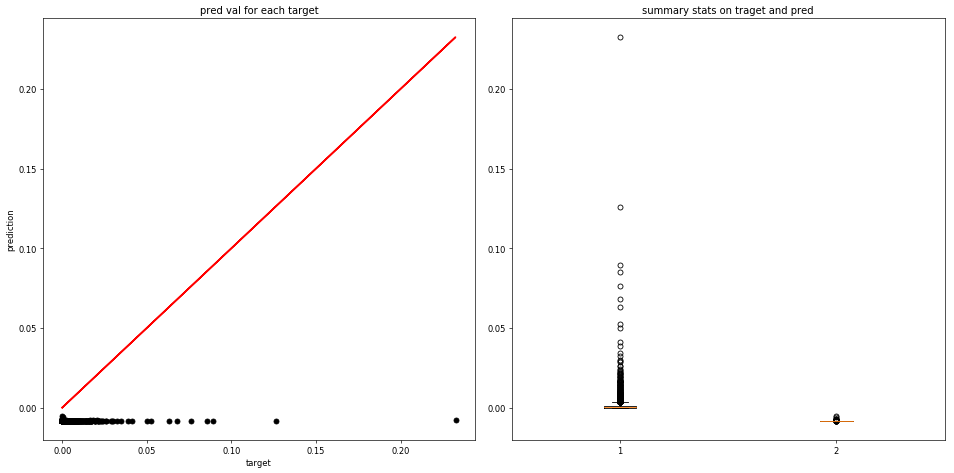

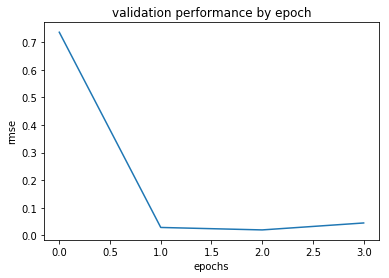

seed:  100
Val Loss: 0.0132, Test Accuracy: 0.000 ± nan, Duration: 0.035


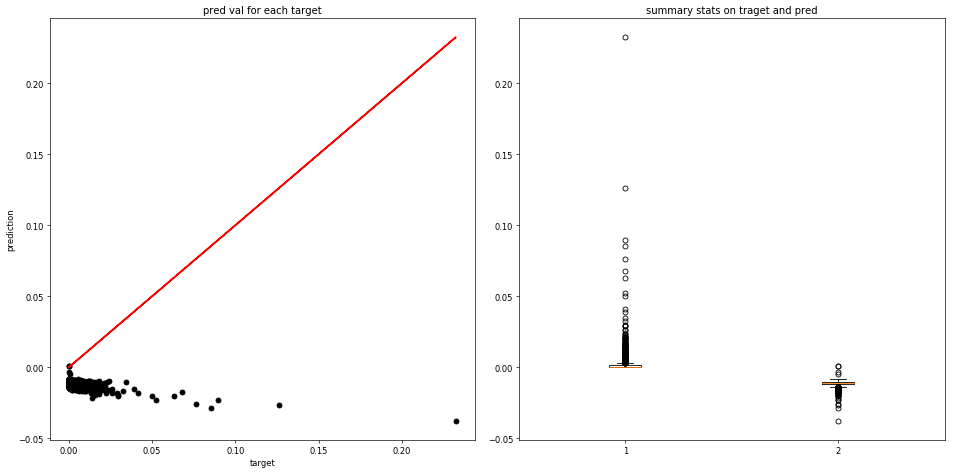

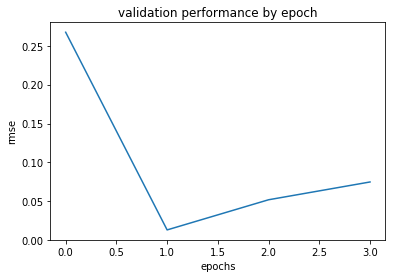

seed:  101
Val Loss: 0.0161, Test Accuracy: 0.000 ± nan, Duration: 0.030


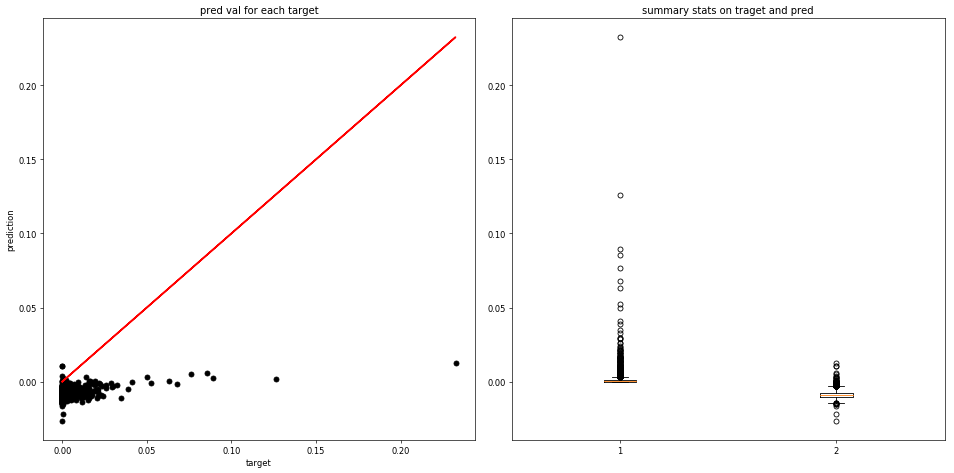

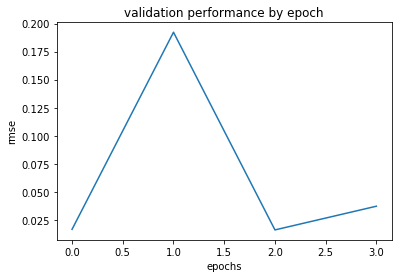

seed:  102
Val Loss: 0.0116, Test Accuracy: 0.000 ± nan, Duration: 0.035


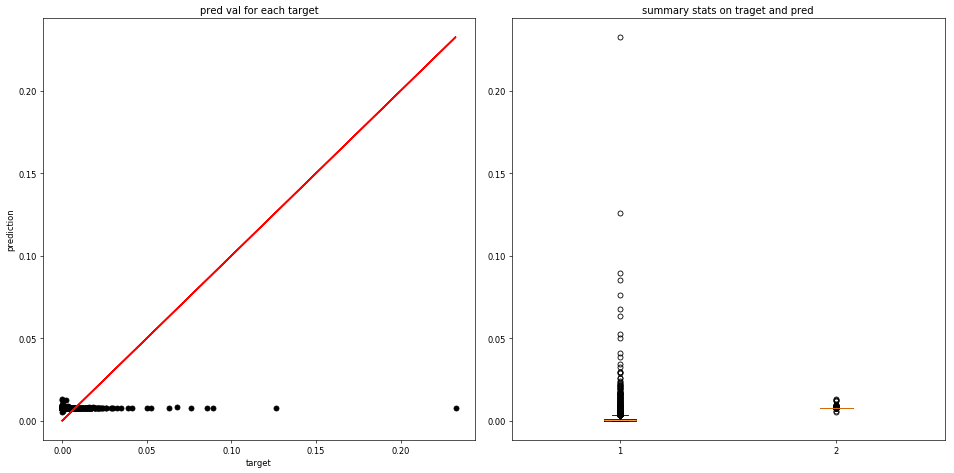

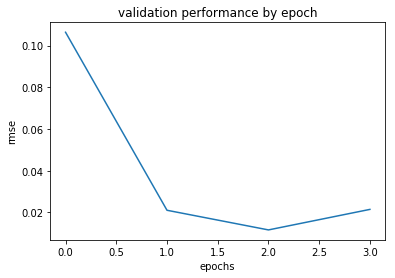

seed:  103
Val Loss: 0.0077, Test Accuracy: 0.000 ± nan, Duration: 0.038


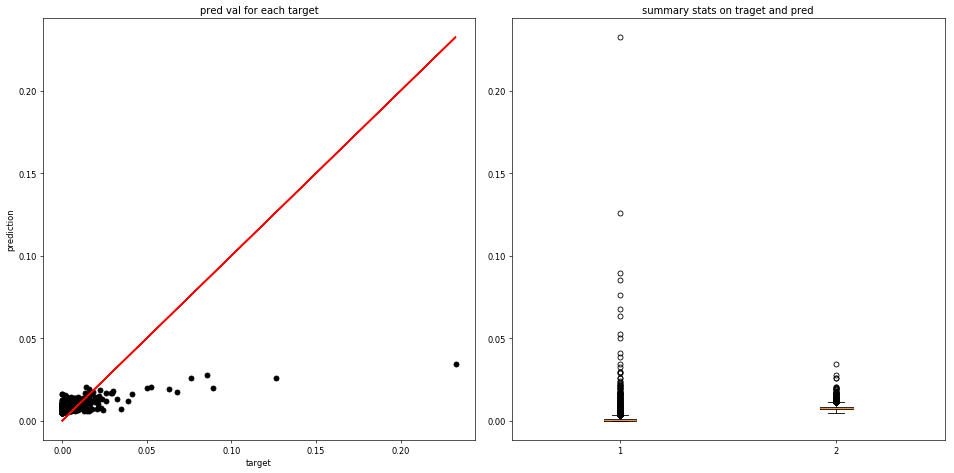

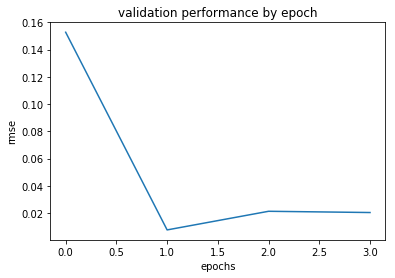

seed:  104
Val Loss: 0.0163, Test Accuracy: 0.000 ± nan, Duration: 0.043


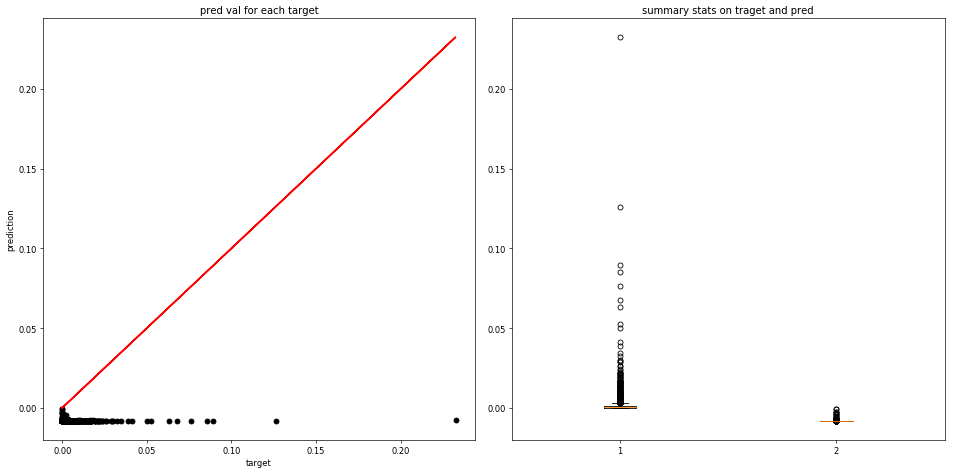

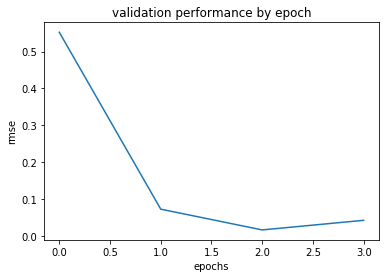

seed:  105
Val Loss: 0.0179, Test Accuracy: 0.000 ± nan, Duration: 0.030


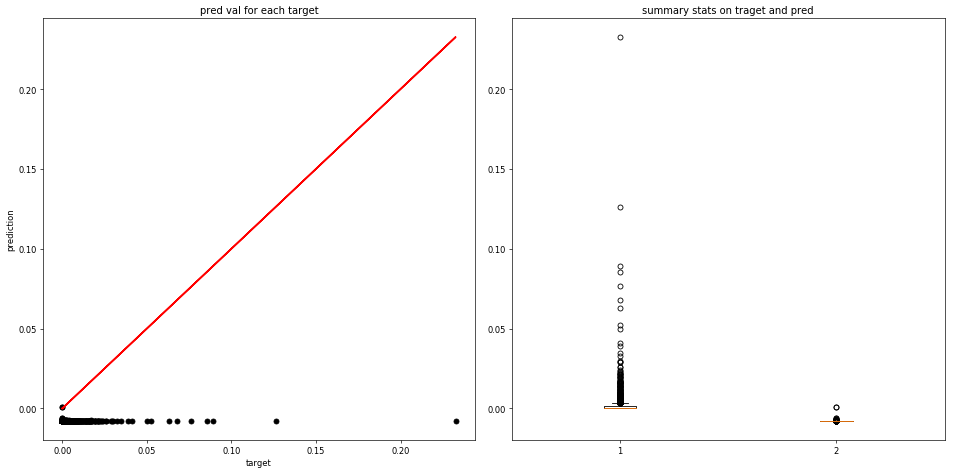

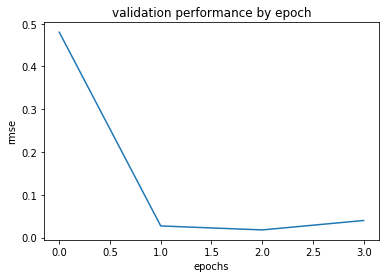

seed:  106
Val Loss: 0.0115, Test Accuracy: 0.000 ± nan, Duration: 0.035


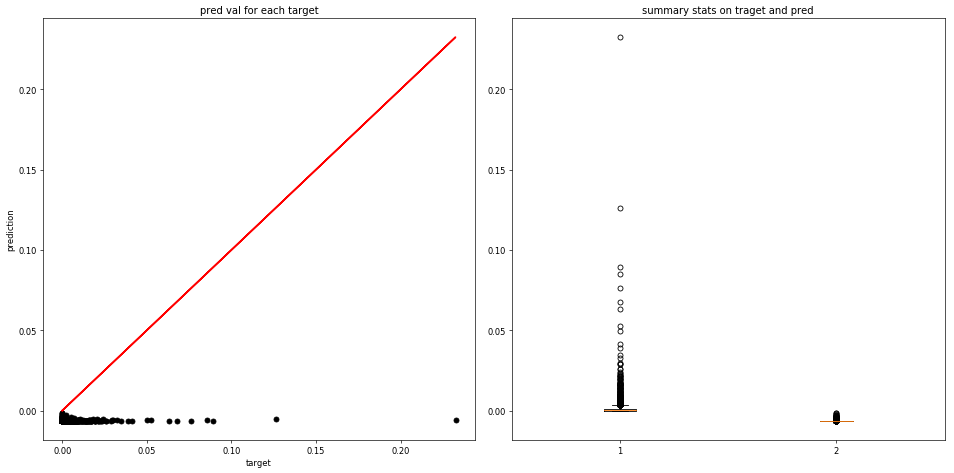

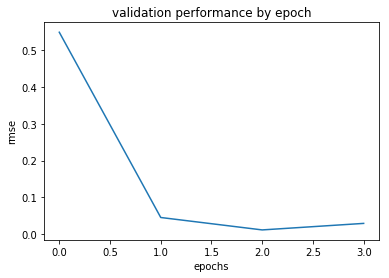

seed:  107
Val Loss: 0.0157, Test Accuracy: 0.000 ± nan, Duration: 0.038


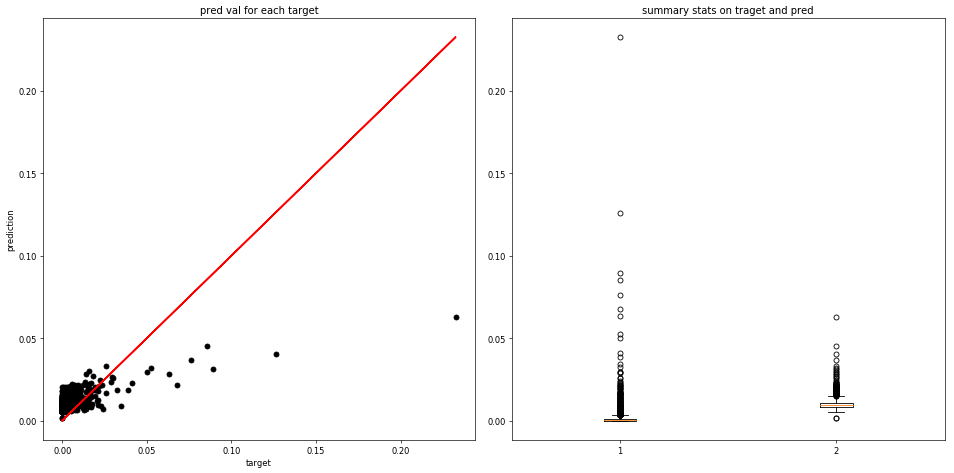

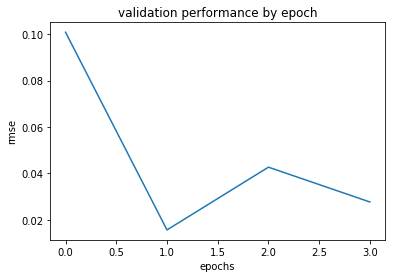

seed:  108
Val Loss: 0.0117, Test Accuracy: 0.000 ± nan, Duration: 0.044


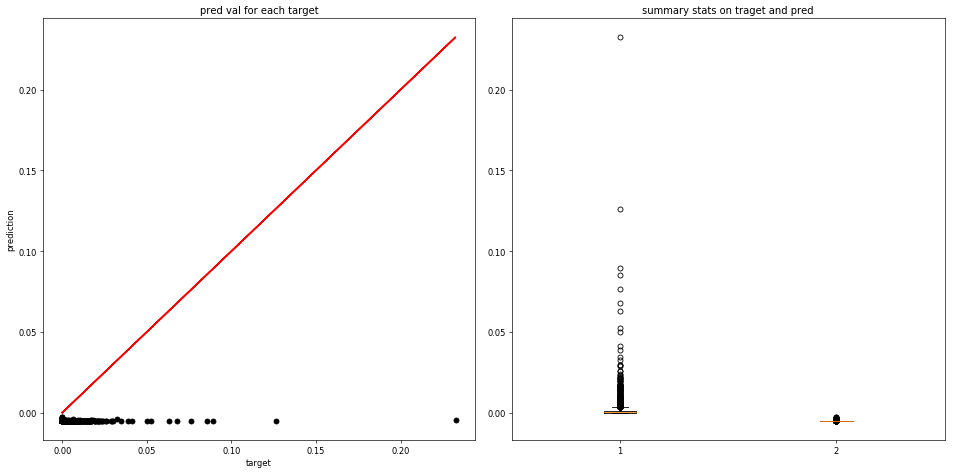

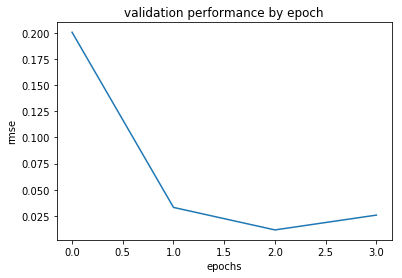

seed:  109
Val Loss: 0.0131, Test Accuracy: 0.000 ± nan, Duration: 0.031


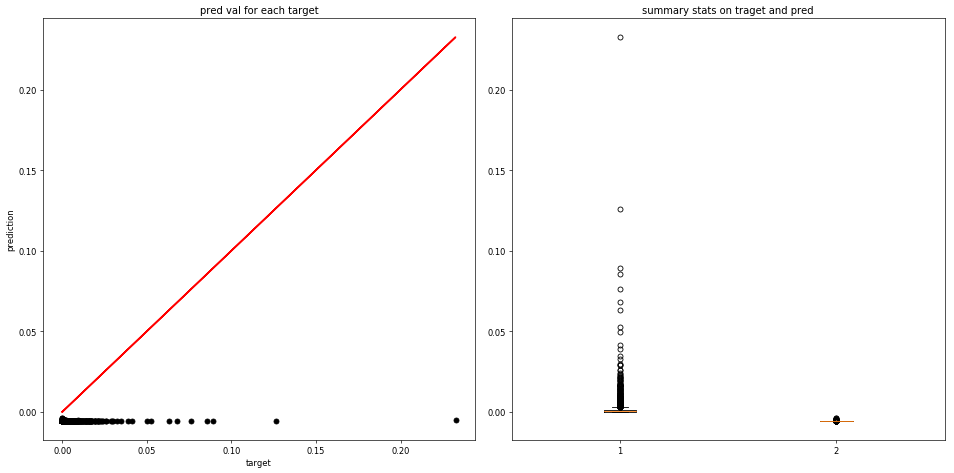

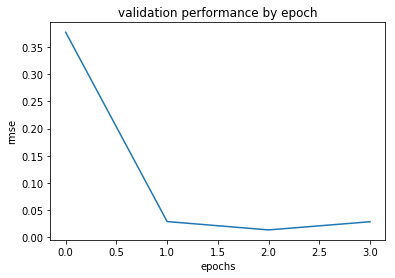

seed:  110
Val Loss: 0.0107, Test Accuracy: 0.000 ± nan, Duration: 0.031


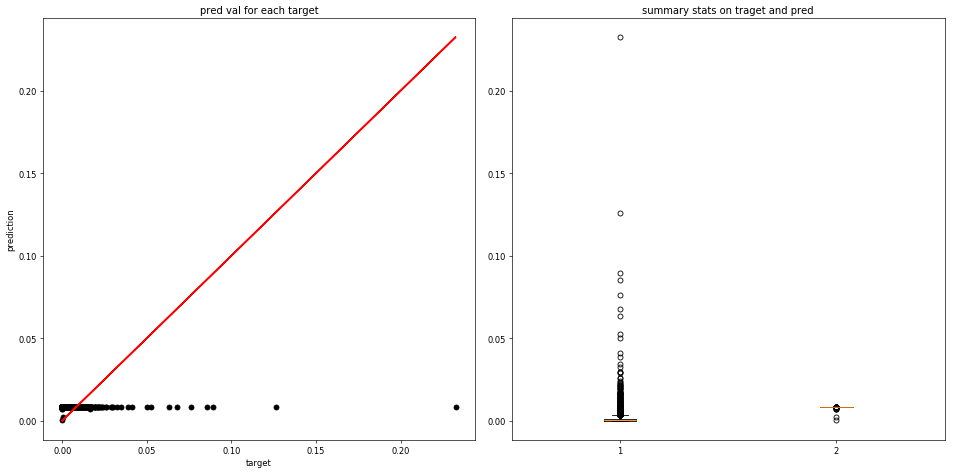

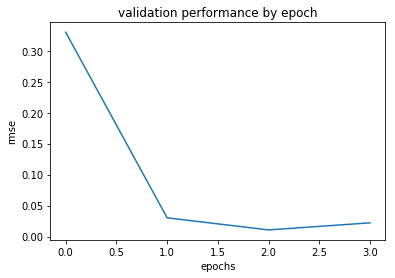

seed:  111
Val Loss: 0.0168, Test Accuracy: 0.000 ± nan, Duration: 0.030


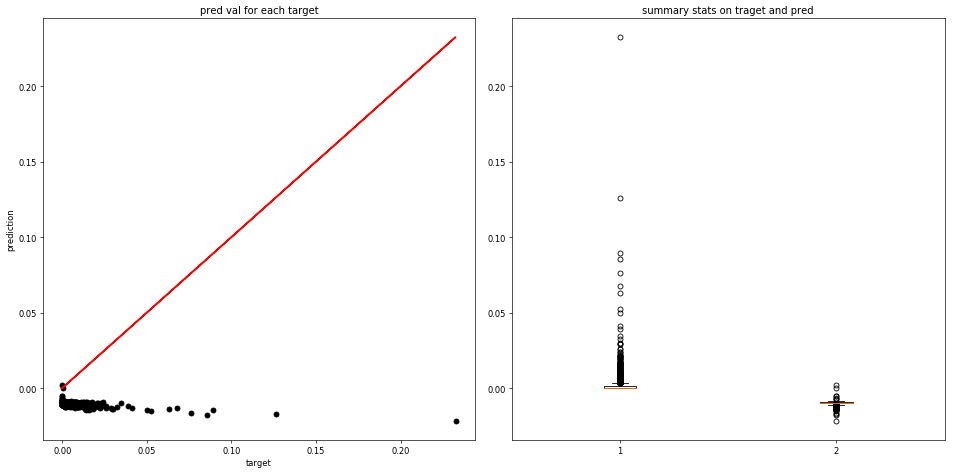

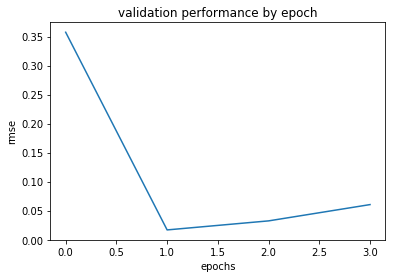

seed:  112
Val Loss: 0.0209, Test Accuracy: 0.000 ± nan, Duration: 0.035


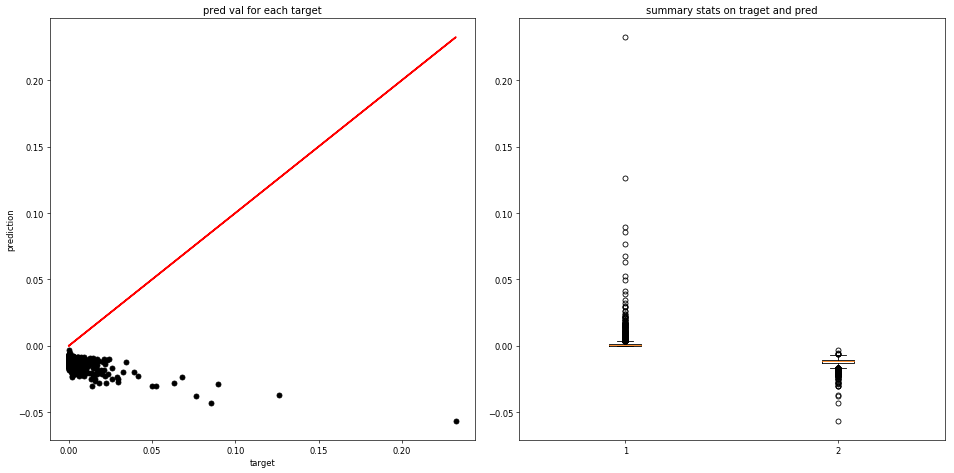

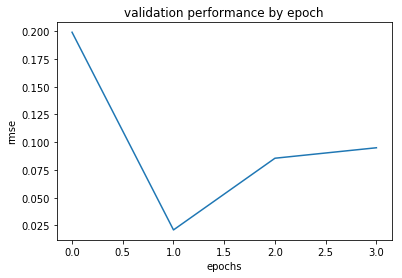

seed:  113
Val Loss: 0.0125, Test Accuracy: 0.000 ± nan, Duration: 0.039


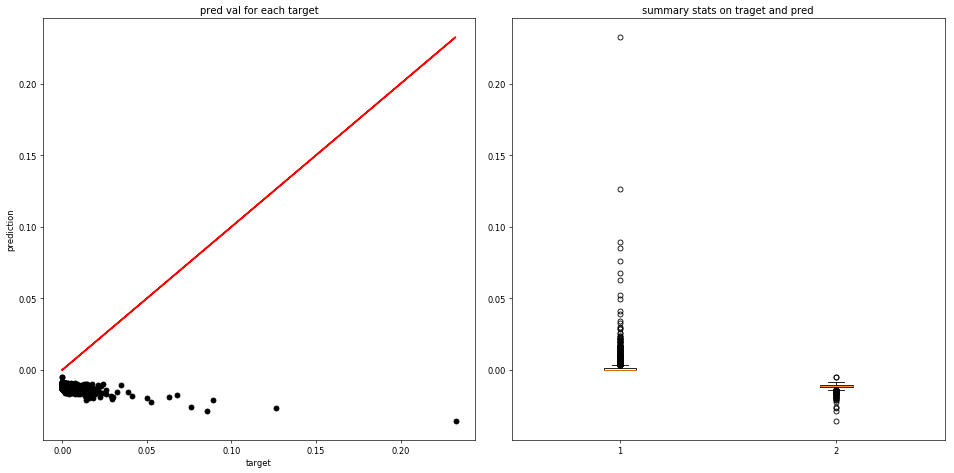

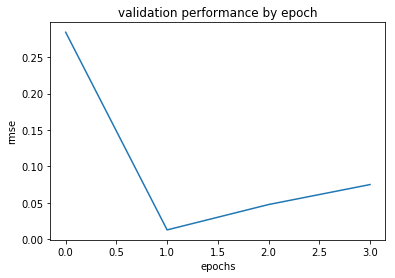

seed:  114
Val Loss: 0.0162, Test Accuracy: 0.000 ± nan, Duration: 0.036


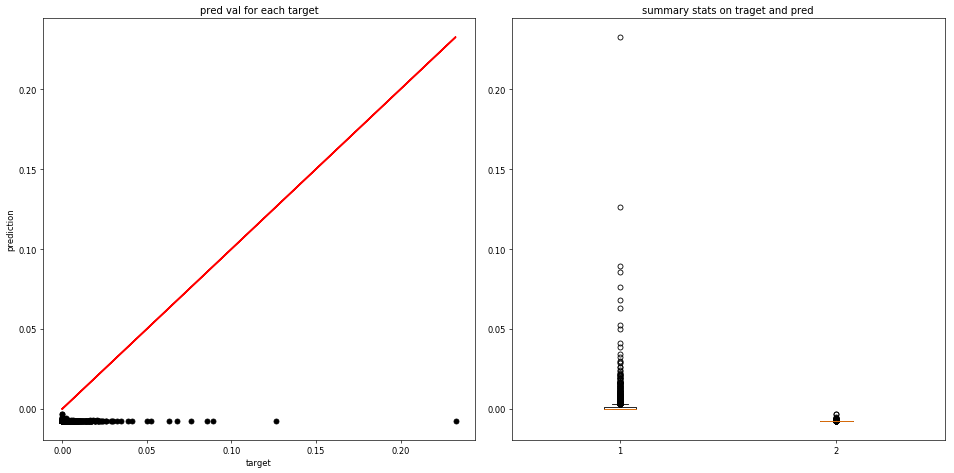

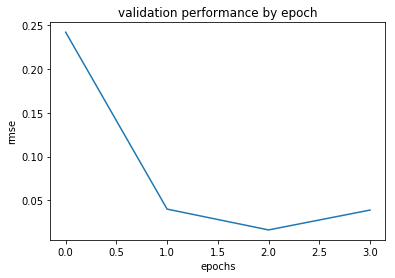

seed:  115
Val Loss: 0.0121, Test Accuracy: 0.000 ± nan, Duration: 0.040


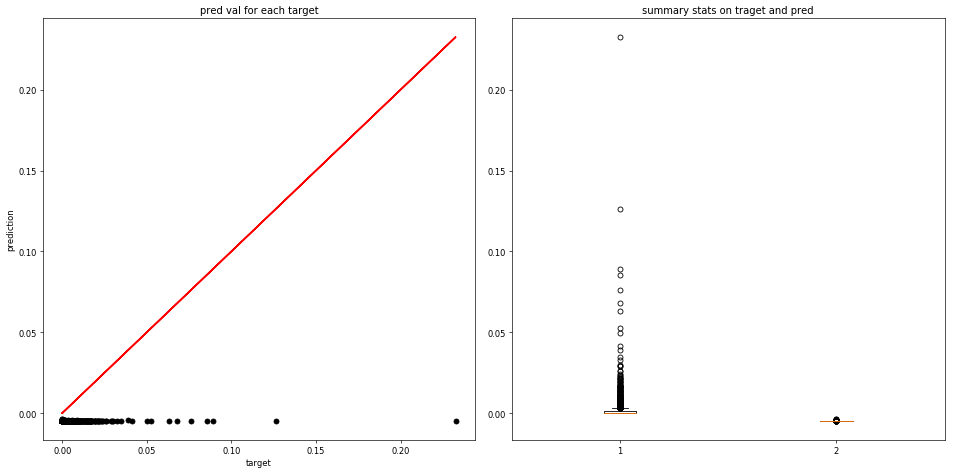

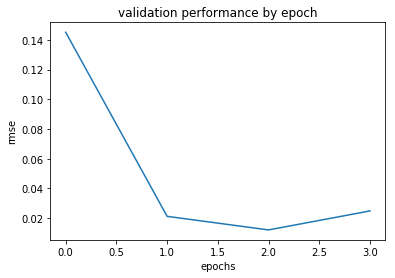

seed:  116
Val Loss: 0.0170, Test Accuracy: 0.000 ± nan, Duration: 0.043


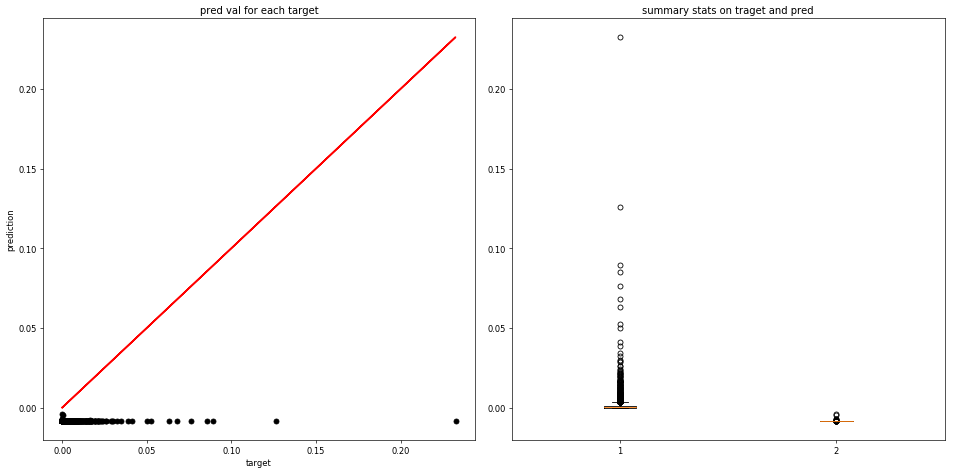

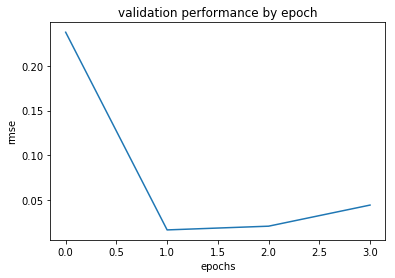

seed:  117
Val Loss: 0.0123, Test Accuracy: 0.000 ± nan, Duration: 0.031


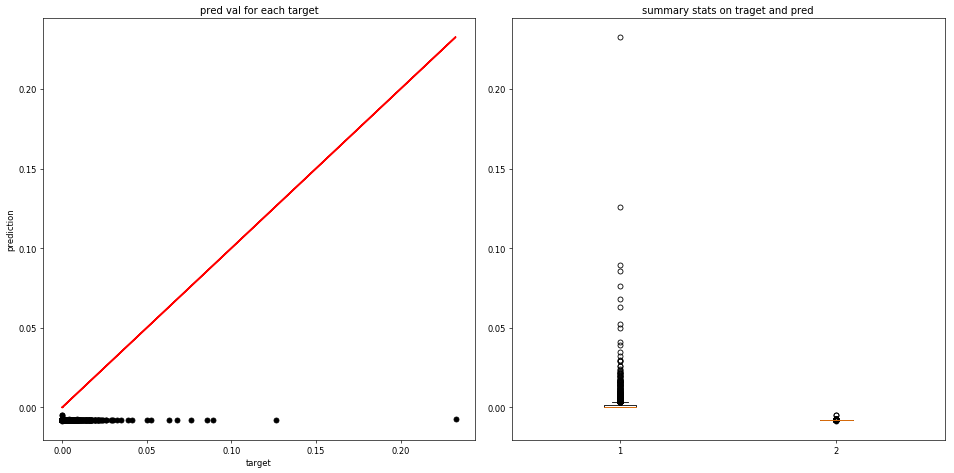

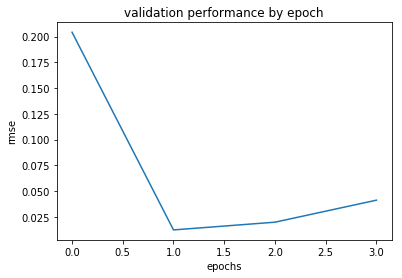

seed:  118
Val Loss: 0.0197, Test Accuracy: 0.000 ± nan, Duration: 0.029


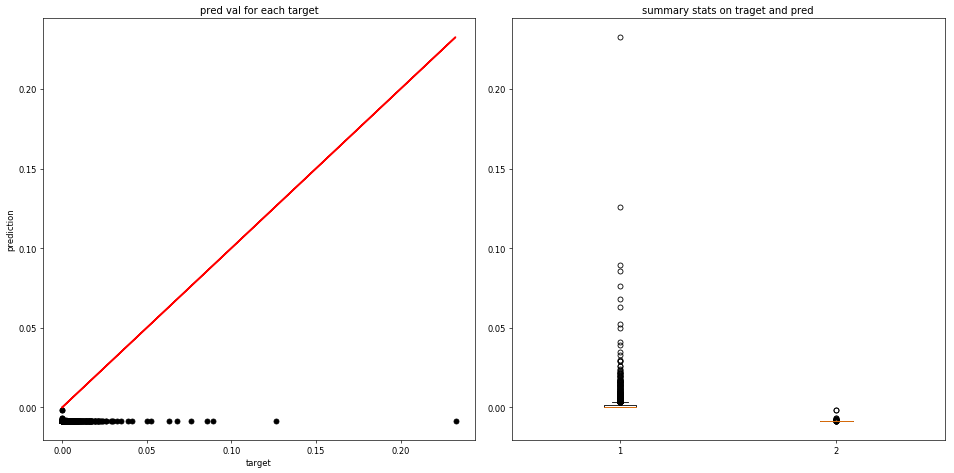

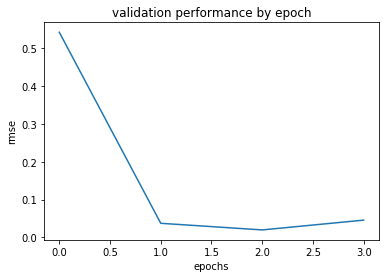

seed:  119
Val Loss: 0.0153, Test Accuracy: 0.000 ± nan, Duration: 0.032


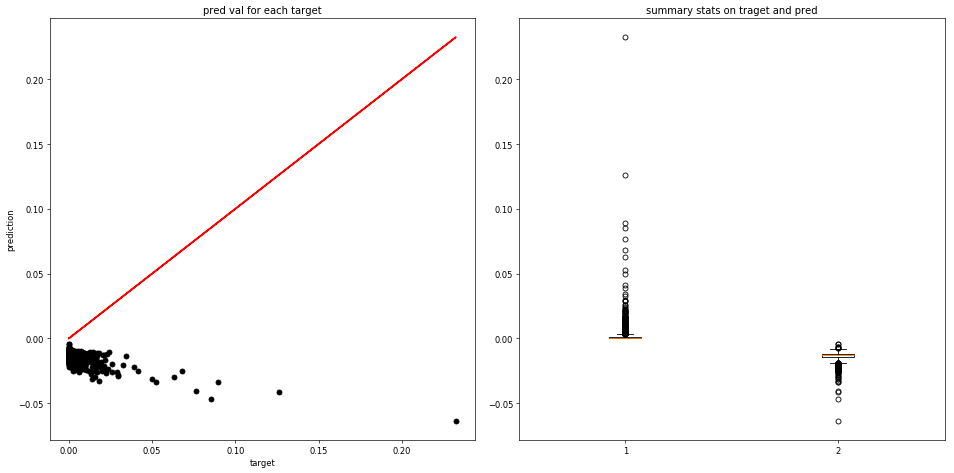

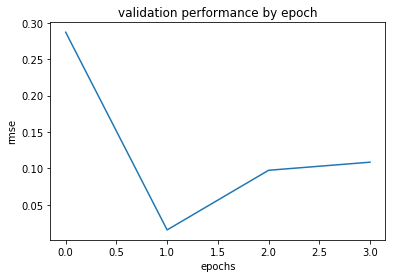

seed:  120
Val Loss: 0.0105, Test Accuracy: 0.000 ± nan, Duration: 0.037


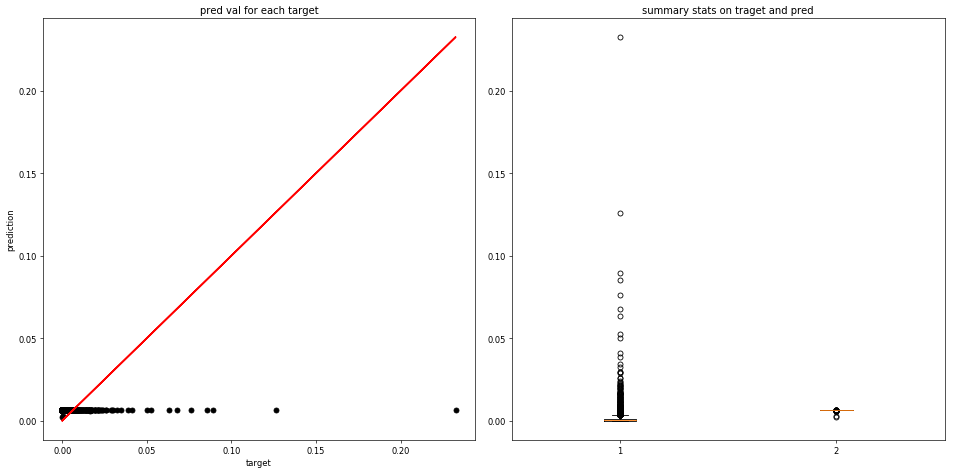

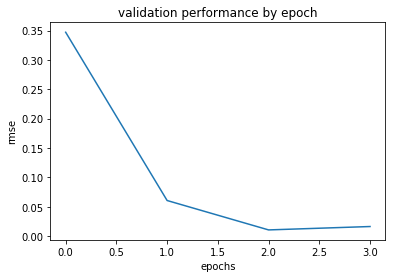

seed:  121
Val Loss: 0.0091, Test Accuracy: 0.000 ± nan, Duration: 0.036


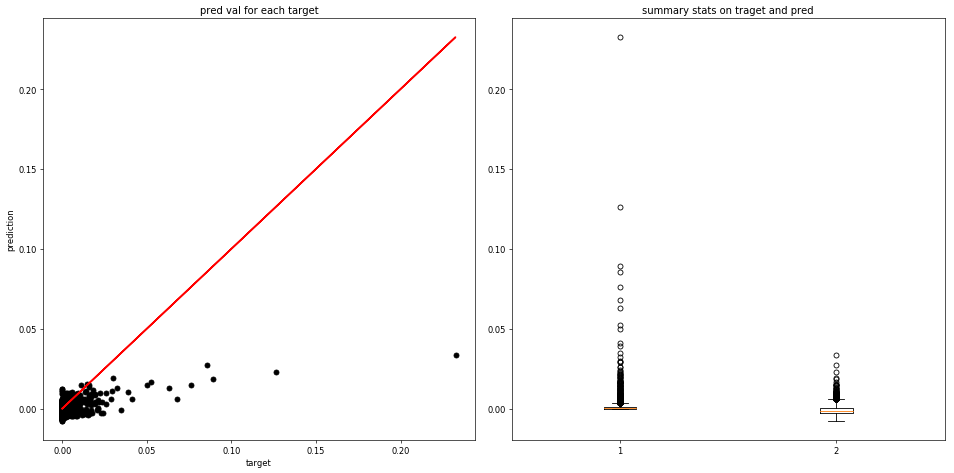

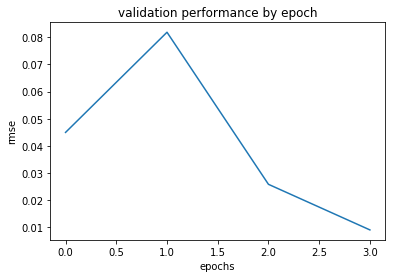

seed:  122
Val Loss: 0.0111, Test Accuracy: 0.000 ± nan, Duration: 0.033


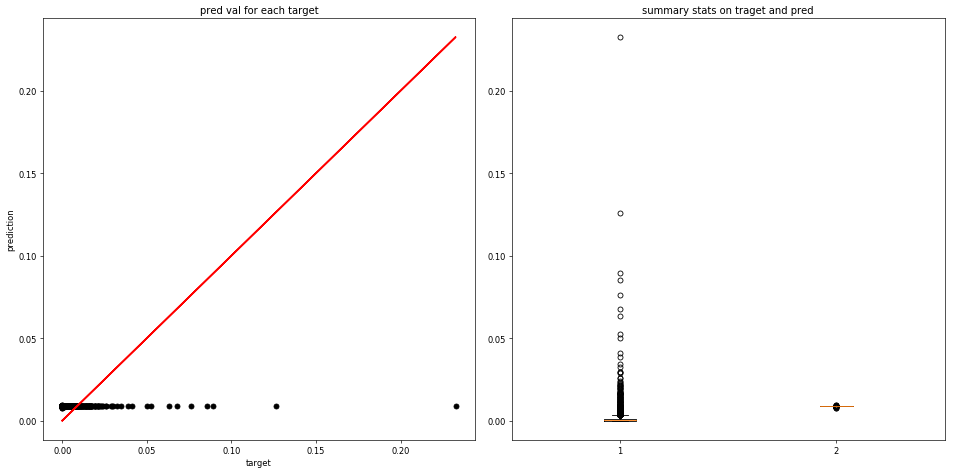

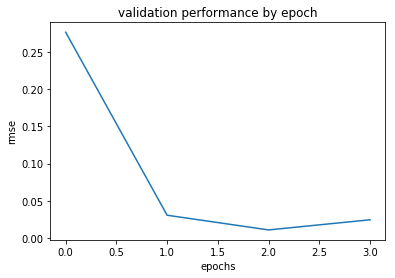

seed:  123
Val Loss: 0.0185, Test Accuracy: 0.000 ± nan, Duration: 0.038


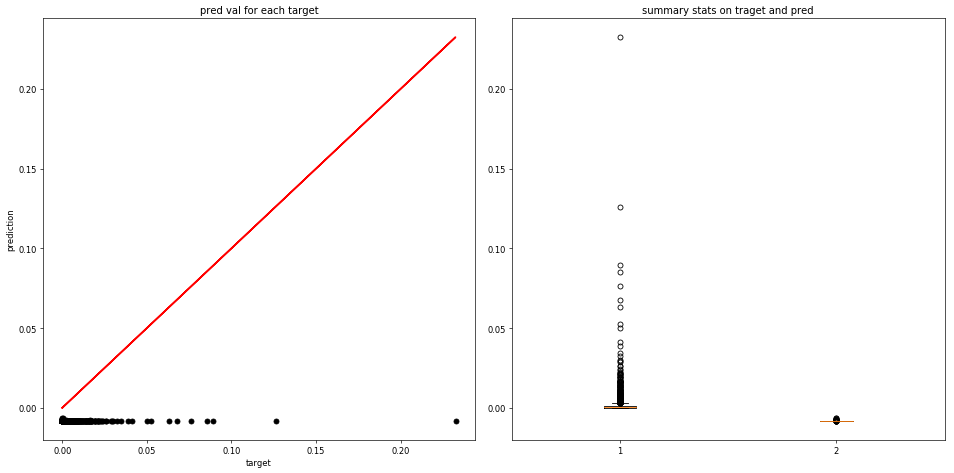

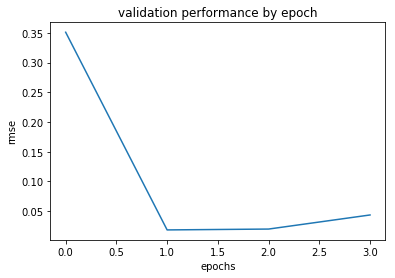

seed:  124
Val Loss: 0.0159, Test Accuracy: 0.000 ± nan, Duration: 0.042


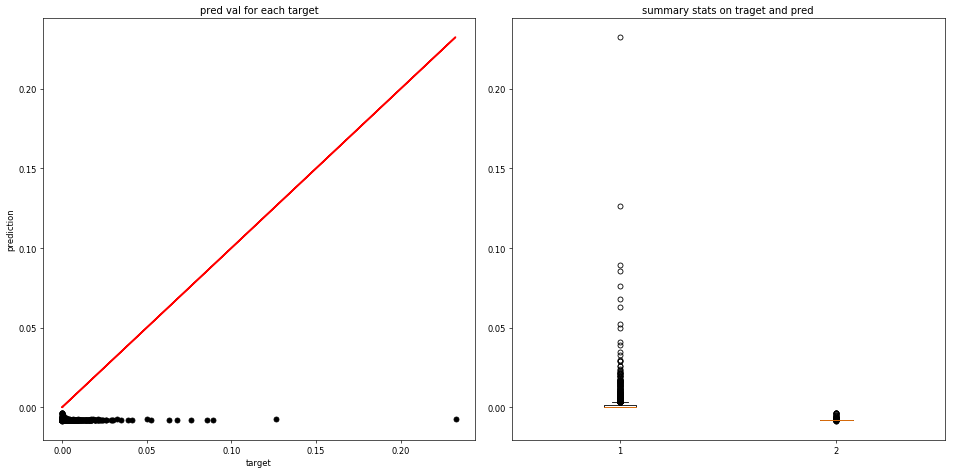

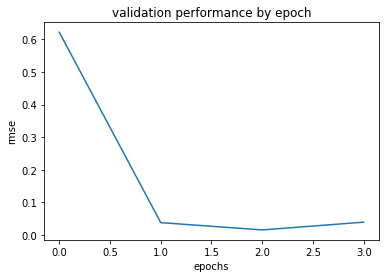

seed:  125
Val Loss: 0.0145, Test Accuracy: 0.000 ± nan, Duration: 0.040


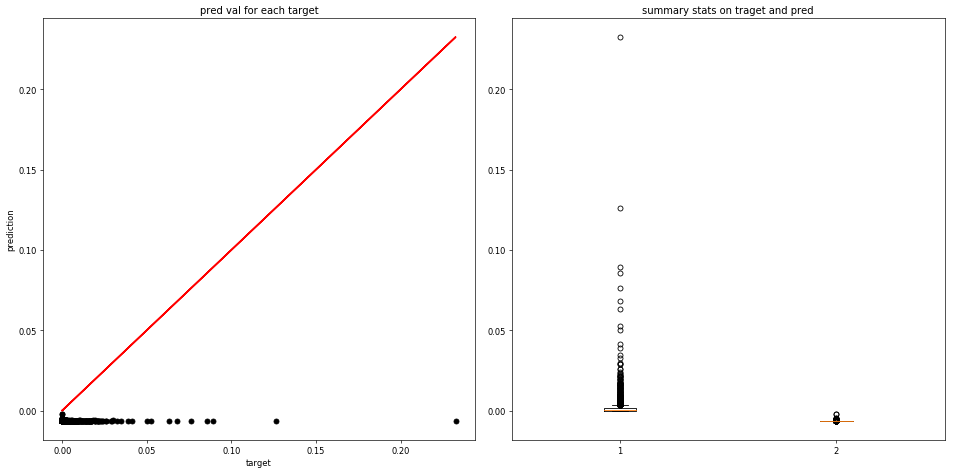

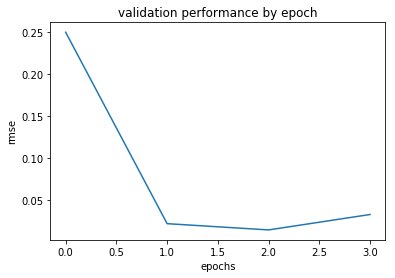

seed:  126
Val Loss: 0.0298, Test Accuracy: 0.000 ± nan, Duration: 0.026


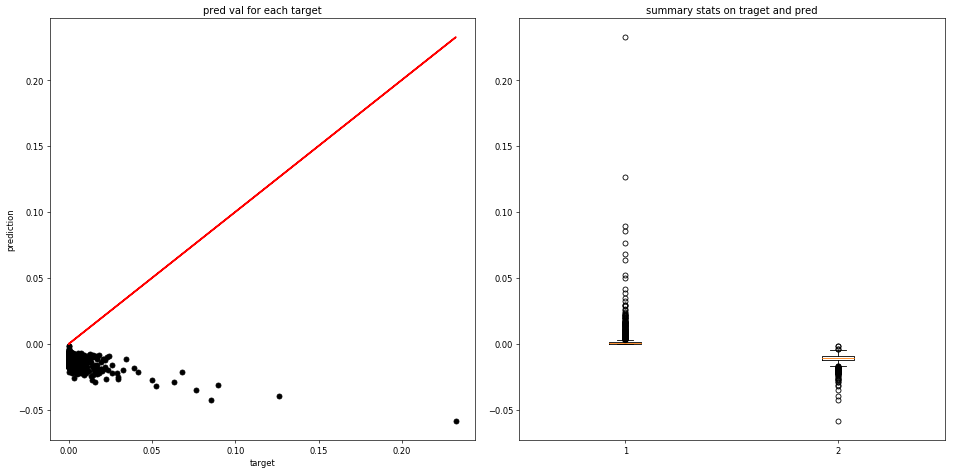

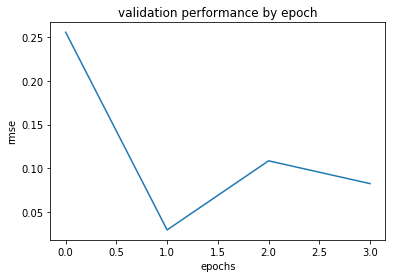

seed:  127
Val Loss: 0.0170, Test Accuracy: 0.000 ± nan, Duration: 0.027


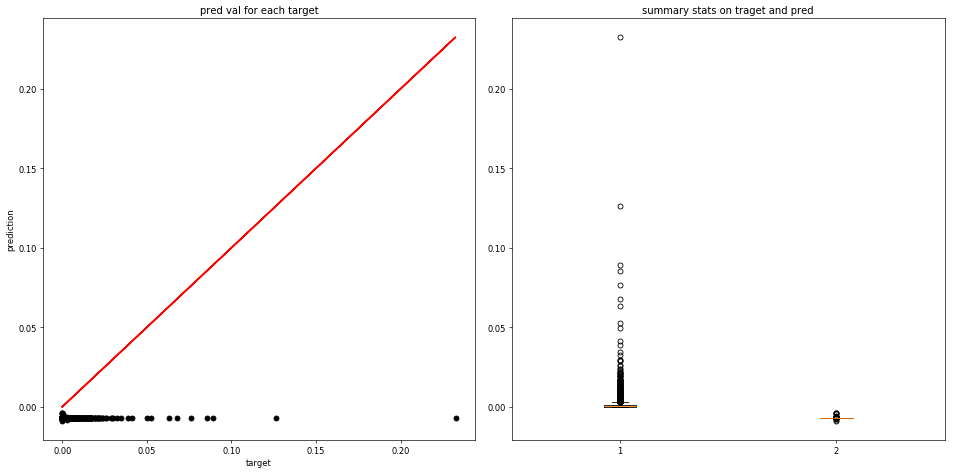

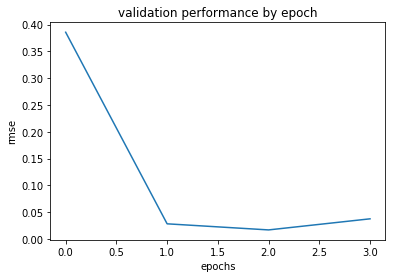

seed:  128
Val Loss: 0.0121, Test Accuracy: 0.000 ± nan, Duration: 0.041


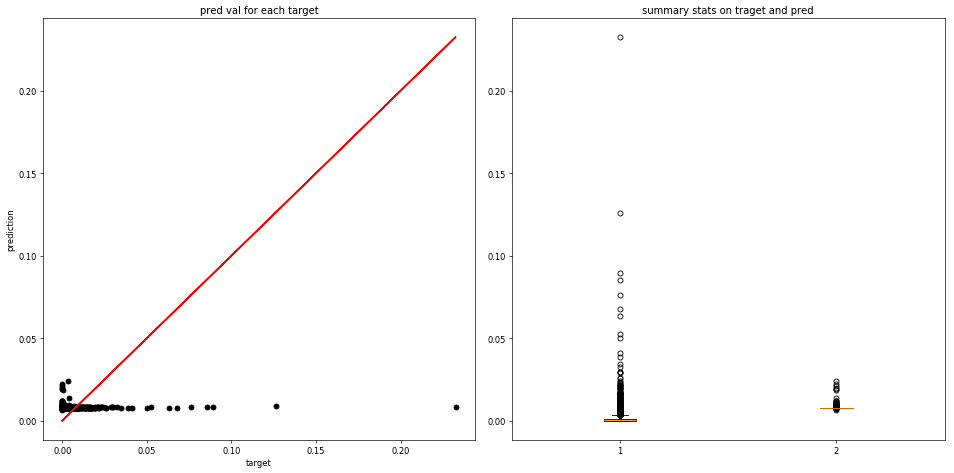

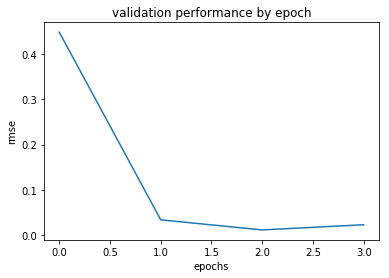

seed:  129
Val Loss: 0.0156, Test Accuracy: 0.000 ± nan, Duration: 0.037


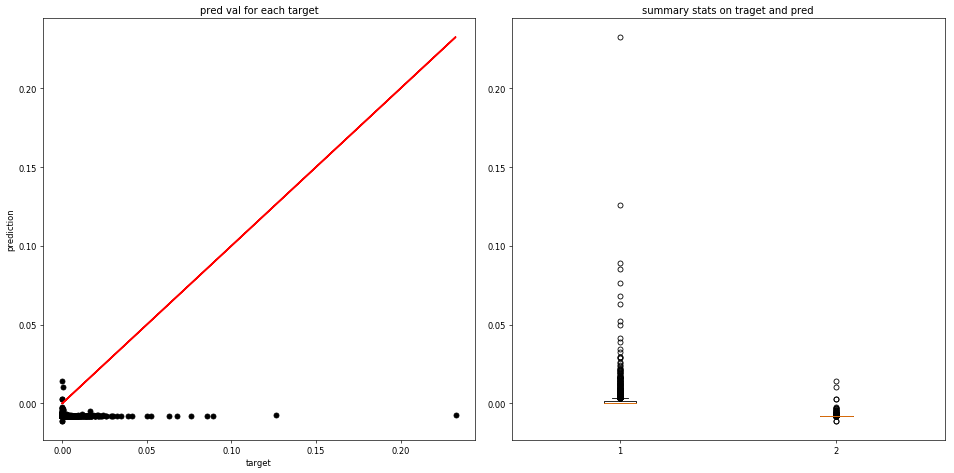

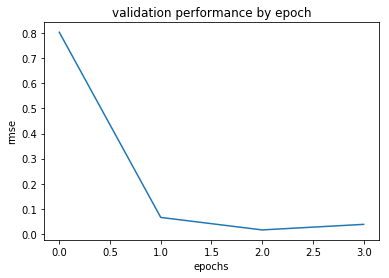

seed:  130
Val Loss: 0.0185, Test Accuracy: 0.000 ± nan, Duration: 0.035


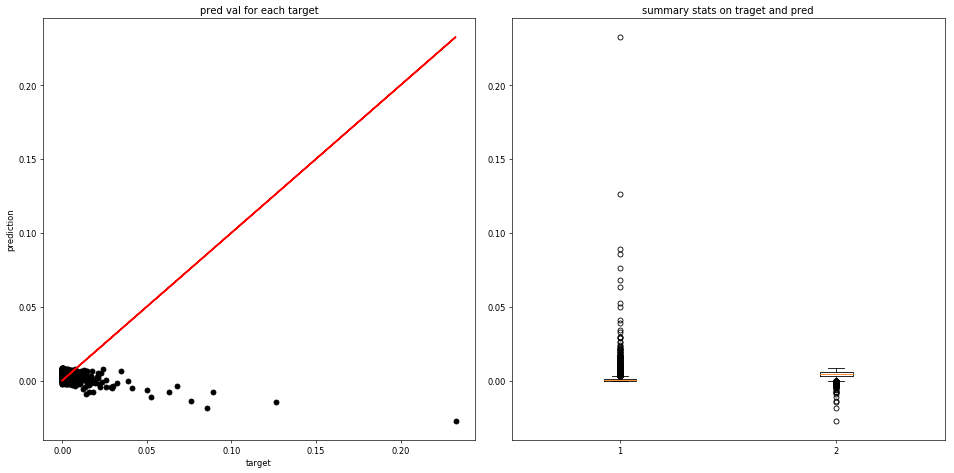

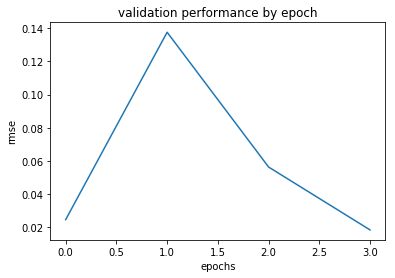

seed:  131
Val Loss: 0.0134, Test Accuracy: 0.000 ± nan, Duration: 0.034


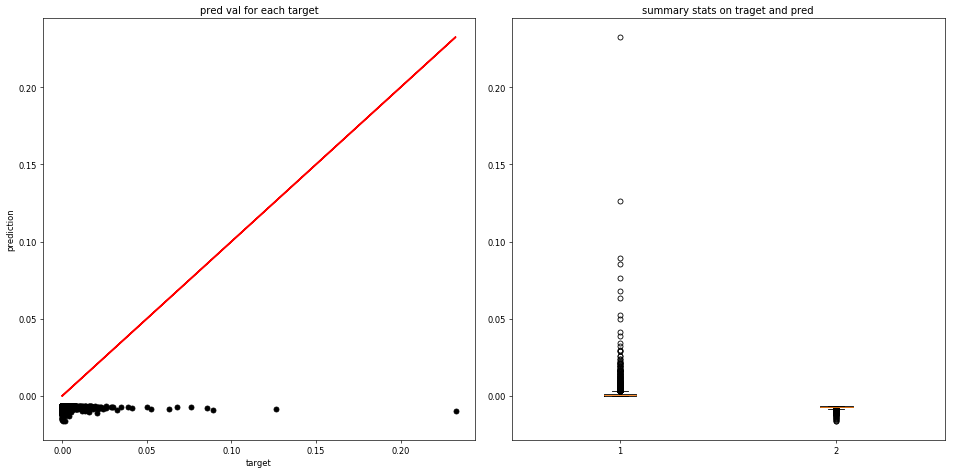

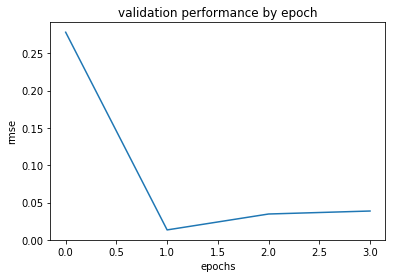

seed:  132
Val Loss: 0.0139, Test Accuracy: 0.000 ± nan, Duration: 0.037


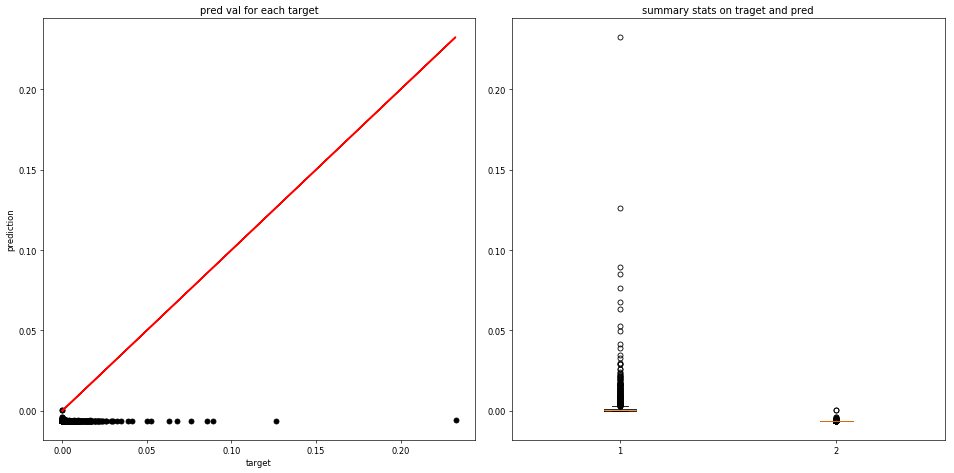

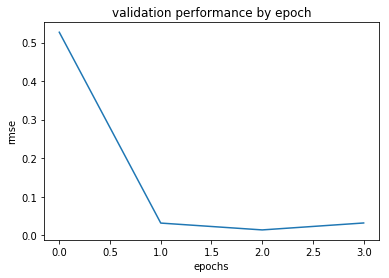

seed:  133
Val Loss: 0.0194, Test Accuracy: 0.000 ± nan, Duration: 0.026


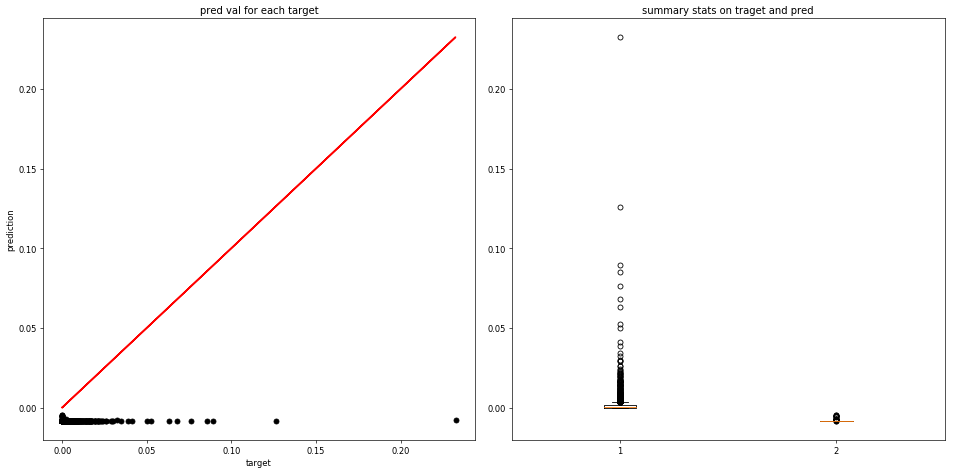

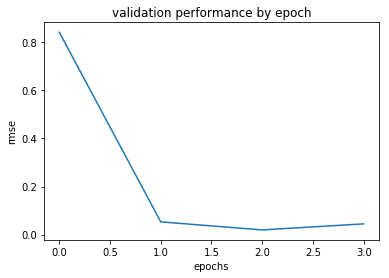

seed:  134
Val Loss: 0.0172, Test Accuracy: 0.000 ± nan, Duration: 0.042


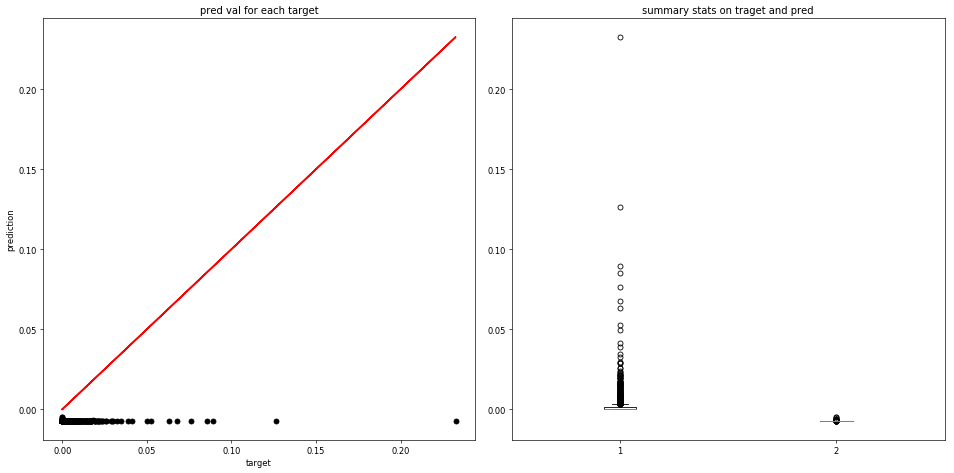

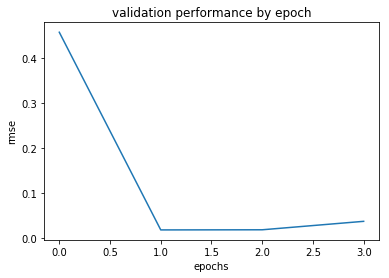

seed:  135
Val Loss: 0.0106, Test Accuracy: 0.000 ± nan, Duration: 0.037


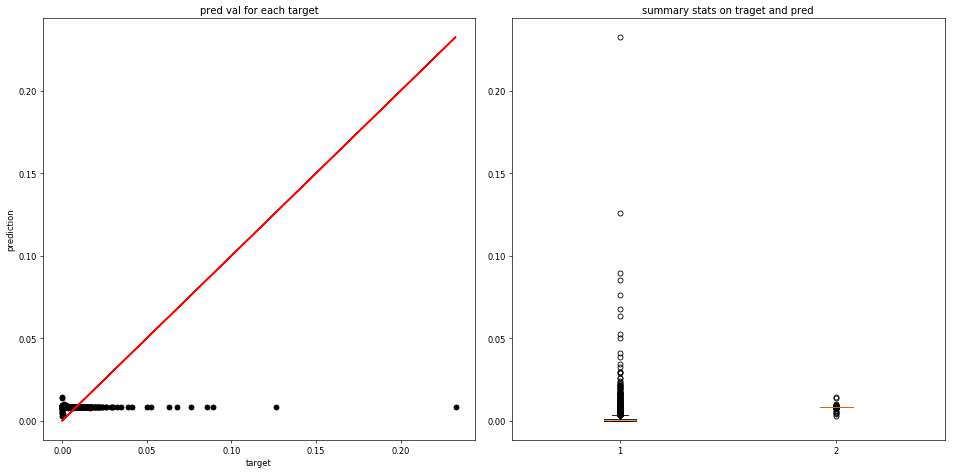

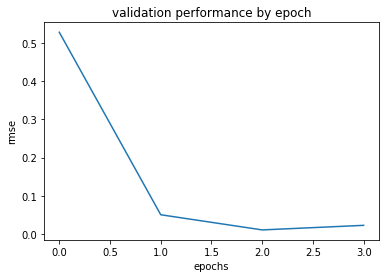

seed:  136
Val Loss: 0.0107, Test Accuracy: 0.000 ± nan, Duration: 0.044


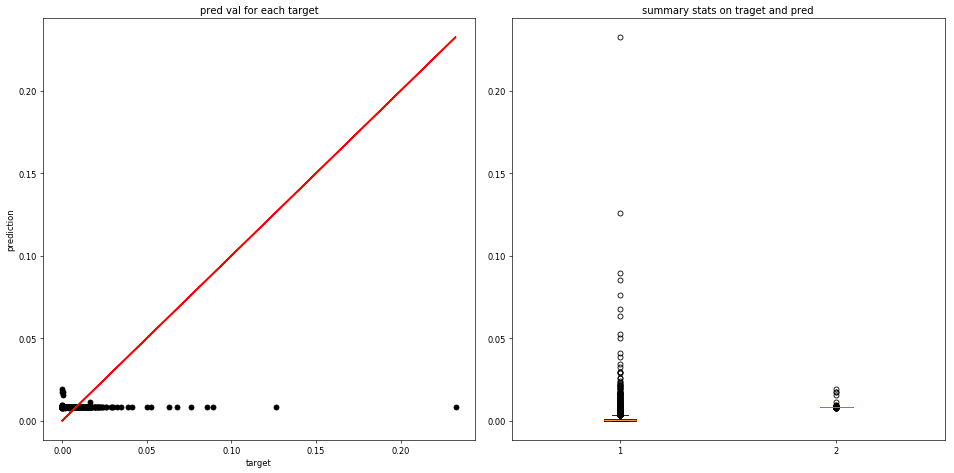

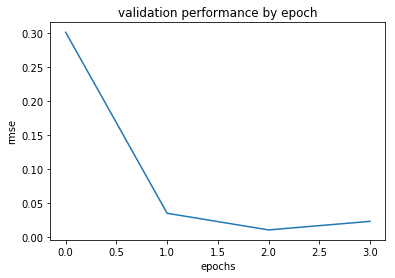

seed:  137
Val Loss: 0.0207, Test Accuracy: 0.000 ± nan, Duration: 0.033


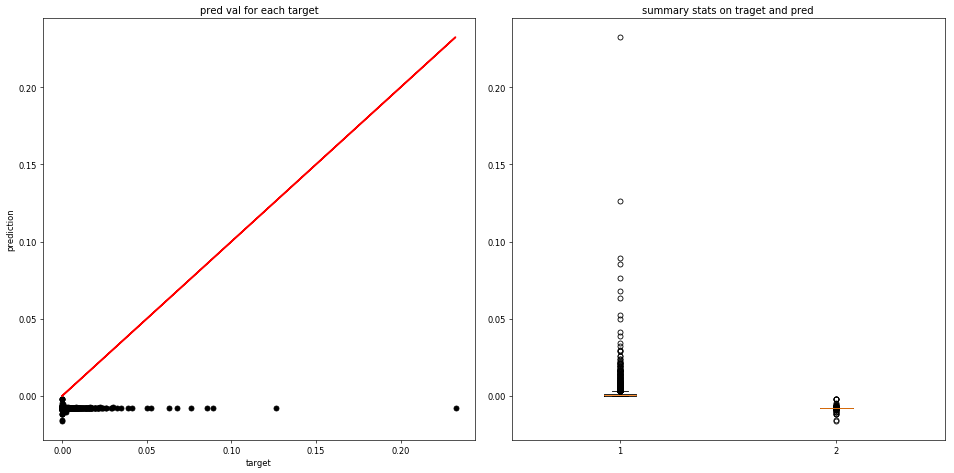

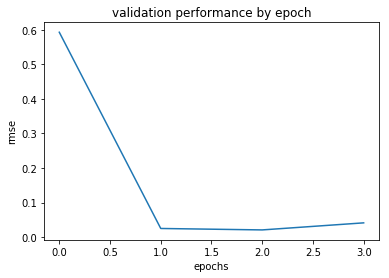

seed:  138
Val Loss: 0.0219, Test Accuracy: 0.000 ± nan, Duration: 0.031


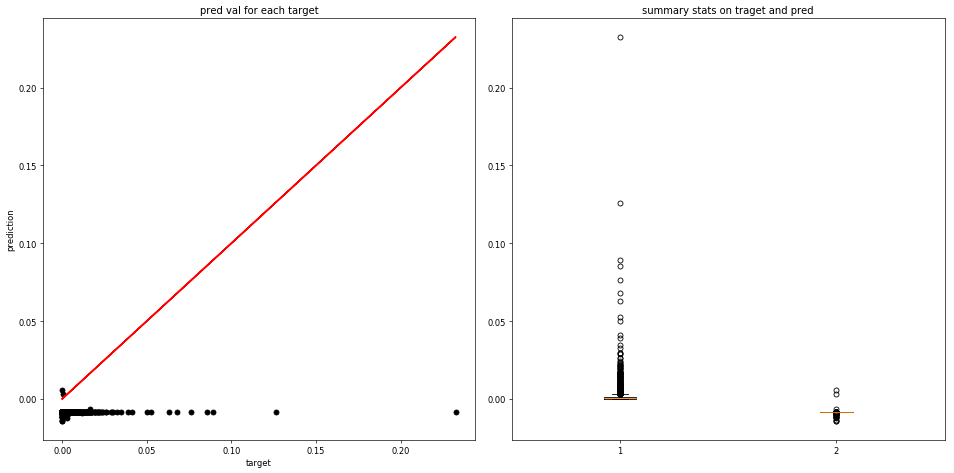

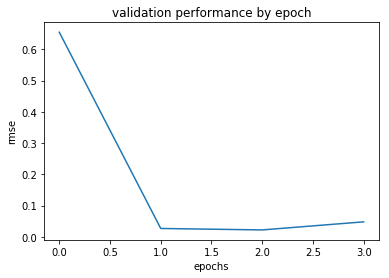

seed:  139
Val Loss: 0.0151, Test Accuracy: 0.000 ± nan, Duration: 0.037


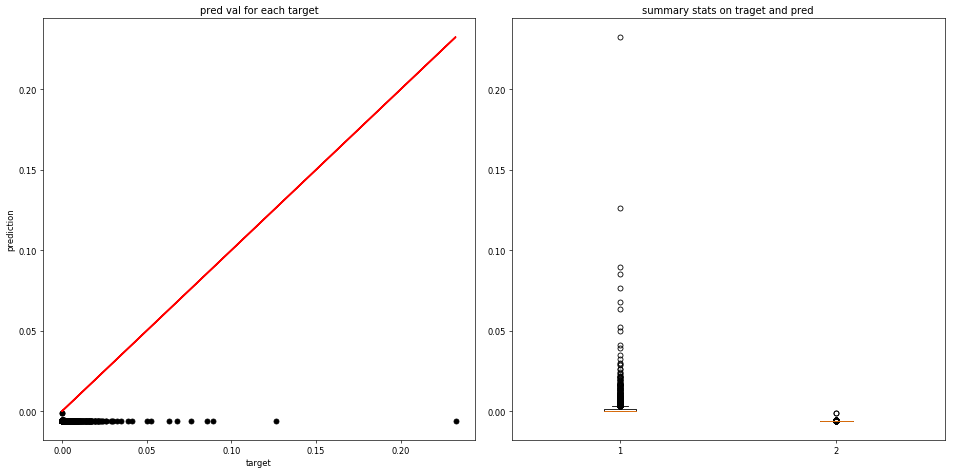

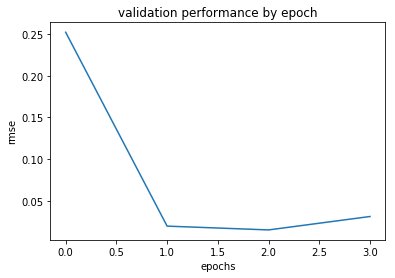

seed:  140
Val Loss: 0.0091, Test Accuracy: 0.000 ± nan, Duration: 0.025


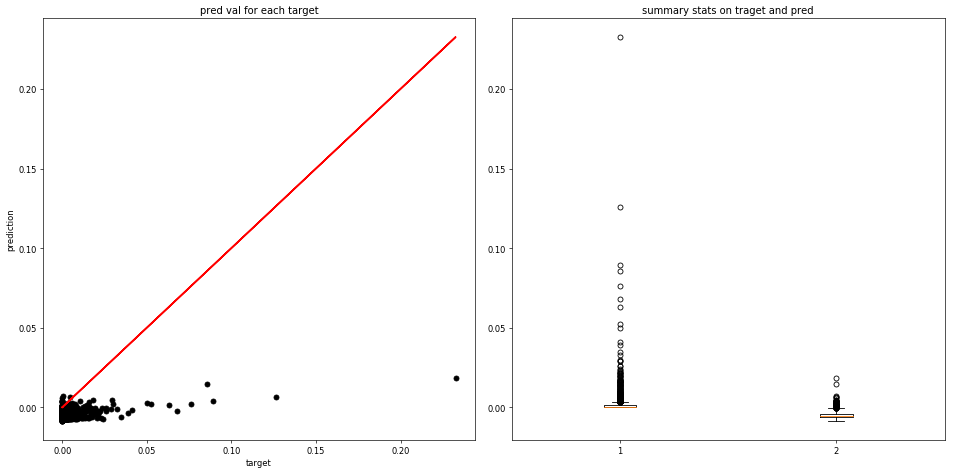

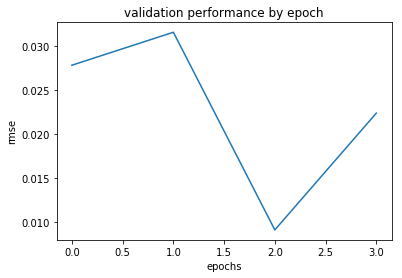

seed:  141
Val Loss: 0.0125, Test Accuracy: 0.000 ± nan, Duration: 0.027


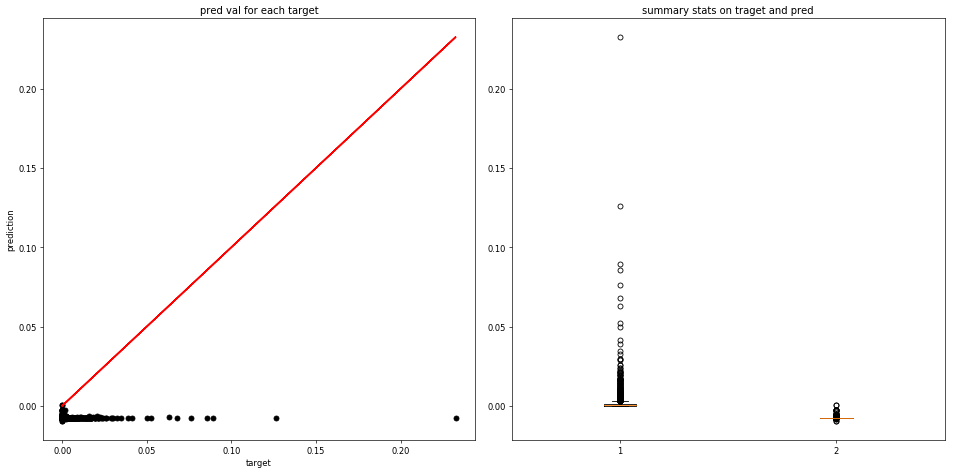

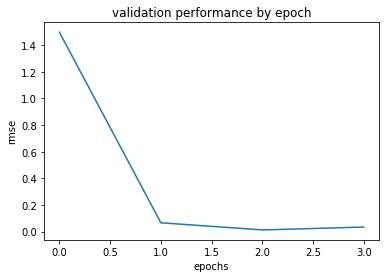

seed:  142
Val Loss: 0.0164, Test Accuracy: 0.000 ± nan, Duration: 0.027


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-157-9036c2d47101>", line 41, in <module>
    reporting_quick(pred,data.y, val_loss_history)
  File "<ipython-input-148-9eddf87c9112>", line 214, in reporting_quick
    plt.show()
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/matplotlib/pyplot.py", line 254, in show
    return _show(*args, **kw)
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/IPython/core/display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
 

KeyboardInterrupt: 

In [157]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
  c

#pprint(accs)
print()
#pprint(val_losses)

Val Loss: 0.0090, Test Accuracy: 0.000 ± 0.000, Duration: 0.557


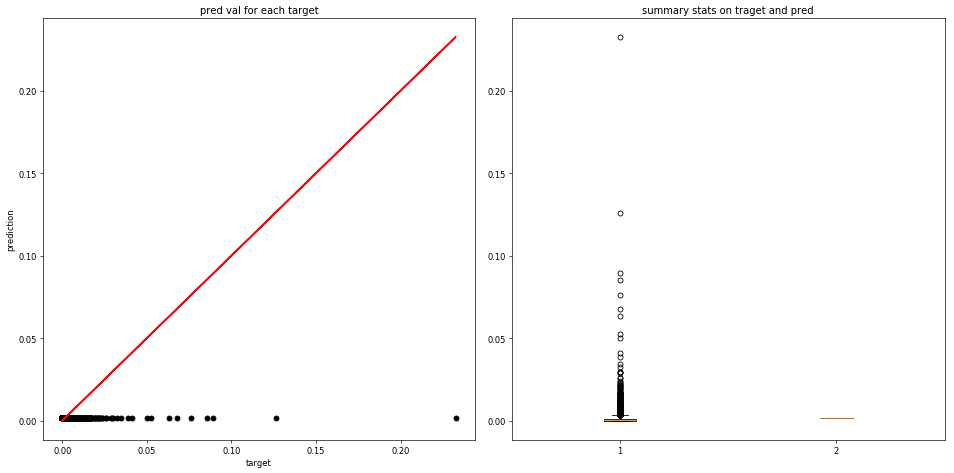

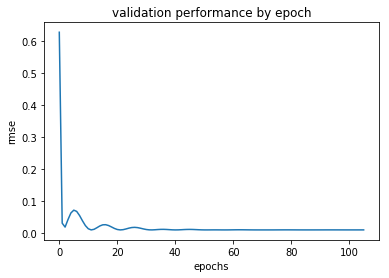

In [159]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 1)
        

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.float()  

#pprint(data.y)

permute_masks = random_planetoid_splits 
torch.manual_seed(65)# we can perfectly control results with this
pred, val_loss_history, accs, val_losses  = run(dataset,data.y, Net(dataset), 100, 200, 0.01, 0.0005,
    10, permute_masks)
reporting_quick(pred,data.y, val_loss_history)

# with seed 65 a single split is ok,many more are as if we didn't fix the seed almost.
# so it seems that a lot of splits don't favor the algorithm

#pprint(accs)
print()
#pprint(val_losses)

Val Loss: 0.0055, Test Accuracy: 0.000 ± nan, Duration: 2.493


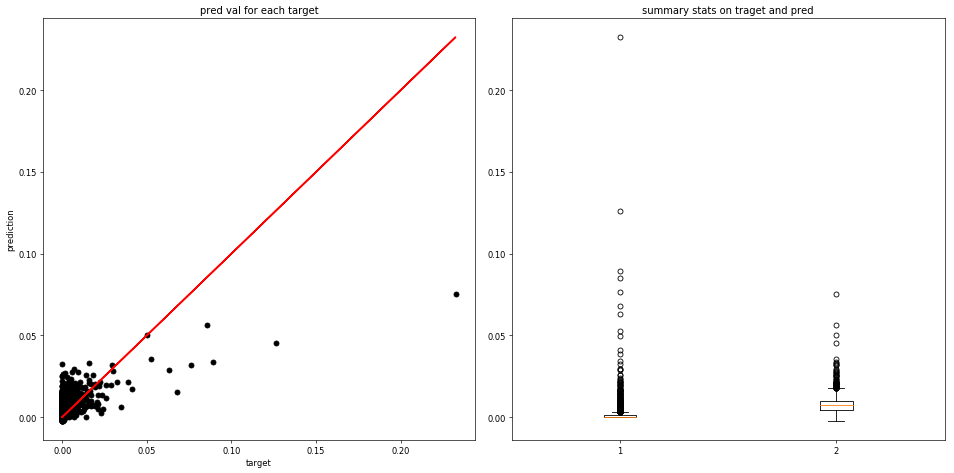

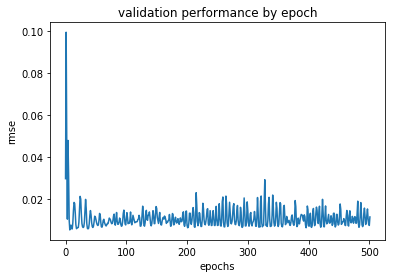

In [163]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 1)
        

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.float()  

#pprint(data.y)

permute_masks = random_planetoid_splits 
torch.manual_seed(65)# we can perfectly control results with this
pred, val_loss_history, accs, val_losses  = run(dataset,data.y, Net(dataset), 1, 1000, 0.01, 0.0005,
    10, permute_masks)
reporting_quick(pred,data.y, val_loss_history)

# this split is ok, if only 1 run -> it works! with few epochs

#pprint(accs)
print()
#pprint(val_losses)

Val Loss: 0.0055, Test Accuracy: 0.000 ± nan, Duration: 0.363


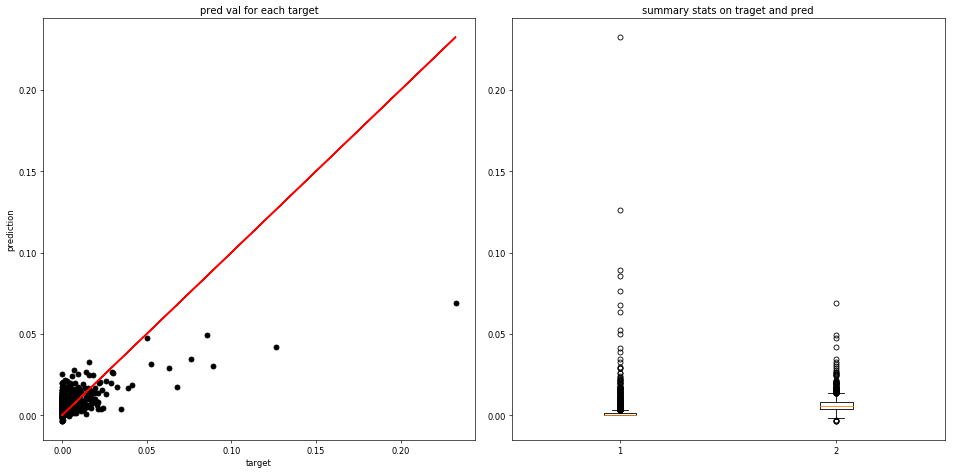

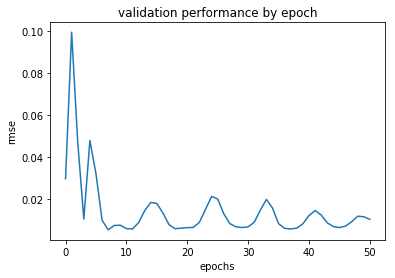

In [170]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 1)
        

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.float()  

#pprint(data.y)

permute_masks = random_planetoid_splits 
torch.manual_seed(65)# we can perfectly control results with this
pred, val_loss_history, accs, val_losses  = run(dataset,data.y, Net(dataset), 1, 100, 0.01, 0.0005,
    10, permute_masks)
reporting_quick(pred,data.y, val_loss_history)

# this split is ok, if only 1 run -> it works! with few epochs

#pprint(accs)
print()
#pprint(val_losses)

Val Loss: 0.0165, Test Accuracy: 0.000 ± 0.000, Duration: 0.028


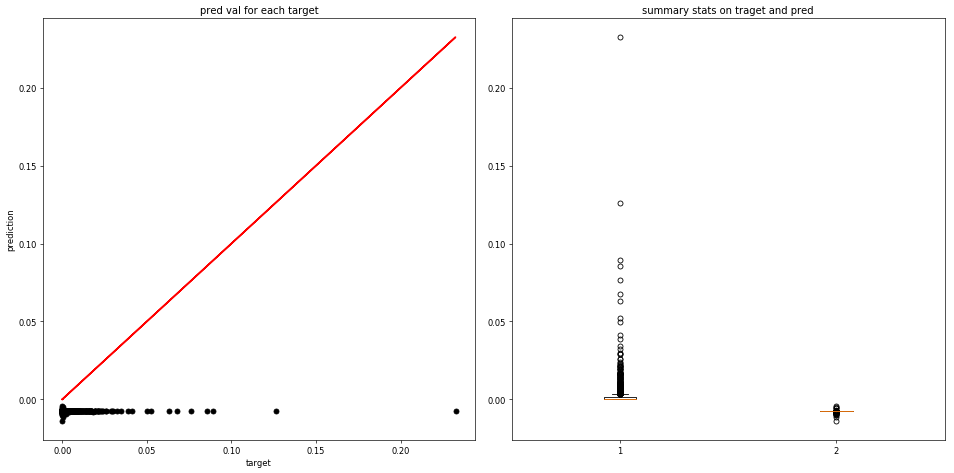

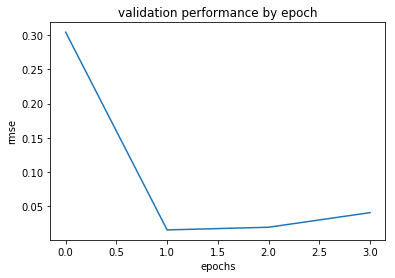

In [174]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 1)
        

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.float()  

#pprint(data.y)

permute_masks = random_planetoid_splits 
torch.manual_seed(65)# we can perfectly control results with this
pred, val_loss_history, accs, val_losses  = run(dataset,data.y, Net(dataset), 200, 4, 0.01, 0.0005,
    10, permute_masks)
reporting_quick(pred,data.y, val_loss_history)

# this split is ok, if only 1 run -> it works! with few epochs

#pprint(accs)
print()
#pprint(val_losses)

## 7. Using discrete ranges

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *

In [2]:
import os.path as osp

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T


def get_planetoid_dataset(root,name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Planetoid(root, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset

#dataset1 = TUDataset(root='temp/'+thename, name='REDDIT-BINARY')
dataset = get_planetoid_dataset(root='temp/planetoid',name='Cora', normalize_features=True)
#inspectGraphDataset(dataset, thename)

In [3]:
dataset.num_classes

7

In [4]:
# get dataset, see data.y is classess
data = dataset[0]
#data.y

# transform to nx
#g = pyTorchGeometricDatasetToNx(data)
g = pytorch_geometric_dataset_to_Nx2(data)

# compute node betweenness
#eb = nx.edge_betweenness_centrality(g,normalized=True)
nb = nx.betweenness_centrality(g,normalized=True)
#pr = nx.pagerank(g)


# modify data.y with node betweenness
# how to make sure that each data[i] corresponds to the node_betweenness?
# maybe that was the problem in the other dataset?

# train model, remove softmax

In [5]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [6]:
nb


{0: 9.76615354875872e-07,
 633: 0.0002693989045288987,
 1862: 0.0011993778752248804,
 2582: 0.0001559457789812771,
 1: 0.0010804767055205456,
 2: 0.004050816272459742,
 652: 0.00014618801144164465,
 654: 0.0,
 332: 0.0018375836036892694,
 1454: 0.0,
 1666: 0.001395900033677452,
 1986: 0.12610085690638276,
 3: 0.0,
 2544: 0.0,
 4: 0.0005511761538211194,
 1016: 0.0006780300868797721,
 1256: 0.001888451863504897,
 1761: 0.00494783711120103,
 2175: 0.0005511761538211173,
 2176: 0.0016241906184409547,
 5: 7.501561061887952e-06,
 1629: 0.000972124782066507,
 1659: 0.0,
 2546: 0.0011402633255662526,
 6: 0.0006987223189870195,
 373: 2.619285296909853e-05,
 1042: 0.013314980942513915,
 1416: 0.014367443938934224,
 1602: 0.002907496089650532,
 7: 0.0,
 208: 0.0,
 8: 0.002698394441118153,
 269: 0.0021664438898384383,
 281: 0.006243450242569817,
 1996: 0.005024090889563333,
 9: 0.0,
 723: 0.0,
 2614: 0.0020426566851337374,
 10: 0.0006779390761298553,
 476: 0.005713005205151189,
 2545: 0.0,
 11: 0.

In [7]:
data.y=torch.ones(len(list(nb.keys())))
for k,v in nb.items():
    data.y[int(k)]=v

In [8]:
data.y = data.y.float()
data.y = torch.FloatTensor(data.y)
#data.y = data.y.reshape(-1,1)
data.y

tensor([9.7662e-07, 1.0805e-03, 4.0508e-03,  ..., 0.0000e+00, 3.9635e-05,
        1.6776e-04])

[3 5 6 ... 2 3 3]


(array([792.,   0., 497.,   0.,   0., 479.,   0., 465.,   0., 475.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <a list of 10 Patch objects>)

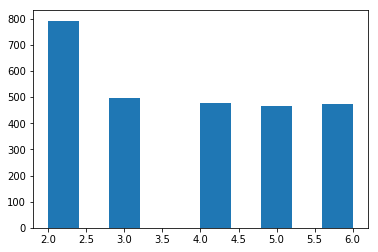

In [9]:
# digitize
bins = np.array([0.0, 1e-10000000, 2e-7, 2e-4, 7e-4, 2e-3, ])
y_discrete= np.digitize(data.y.numpy(), bins)
print(y_discrete)
plt.hist(y_discrete)

In [10]:
y_discrete = y_discrete.flatten()

In [11]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[2, 3, 4, 5, 6]

In [12]:
y_list = y_discrete.tolist()
for j in range(len(y_list)):
    if y_list[j] == 2:
        y_list[j]=0
    elif y_list[j] == 3:
        y_list[j]=1
    elif y_list[j] == 4:
        y_list[j]=2
    elif y_list[j] == 5:
        y_list[j]=3
    elif y_list[j] == 6:
        y_list[j]=4
        
set(y_list)
y_discrete = np.array(y_list)

In [13]:
y_discrete

array([1, 3, 4, ..., 0, 1, 1])

In [20]:
dataset.num_features

1433

In [26]:
from __future__ import division

import time
from pprint import pprint

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)

    return data


def run(dataset,
        y,
        num_classes,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data, num_classes)
        data = data.to(device)
        y = y.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data, y)
            eval_info = evaluate(model, data, y)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)
        
        

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            

def train(model, optimizer, data, y):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], y[data.train_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data, y):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(y[mask]).sum().item() / mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,torch.LongTensor(y_discrete), num_classes, Net( dataset.num_features, num_classes), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5844, Test Accuracy: 0.270 ± 0.046, Duration: 0.562


In [29]:
class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,torch.LongTensor(y_discrete), num_classes, Net( dataset.num_features, num_classes), 150, 500, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5825, Test Accuracy: 0.277 ± 0.041, Duration: 1.513


In [32]:
class NetCheb(torch.nn.Module):
    def __init__(self, d1=90,d2=80,d3=50,num_features=1, num_classes=1, num_layers=4,K=20):
        super(NetCheb, self).__init__()
        self.conv1 = ChebConv(num_features, d1 ,K)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(ChebConv(d1, d1 ,K))
        self.fc1 = nn.Linear(d1, d2)
        self.fc2 = nn.Linear(d2, d3)
        self.fc3 = nn.Linear(d3, num_features)
        self.num_layers = num_layers
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.K = K

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for i in range(self.num_layers - 1):
            self.convs[i].reset_parameters()
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, training=self.training)
        # 3 fc layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  
    
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=3), 100, 20, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.4650, Test Accuracy: 0.364 ± 0.047, Duration: 0.986


In [33]:

run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=10), 100, 20, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5691, Test Accuracy: 0.304 ± 0.064, Duration: 4.536


In [34]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=3), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.4974, Test Accuracy: 0.344 ± 0.047, Duration: 7.630


In [35]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=3), 100, 500, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.4824, Test Accuracy: 0.346 ± 0.055, Duration: 18.491


In [36]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=3), 100, 1000, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5419, Test Accuracy: 0.324 ± 0.059, Duration: 36.643


In [37]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=10), 100, 20, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5968, Test Accuracy: 0.278 ± 0.071, Duration: 4.037


In [38]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=10), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.4845, Test Accuracy: 0.343 ± 0.067, Duration: 27.537


In [39]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=10), 100, 500, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.4575, Test Accuracy: 0.372 ± 0.060, Duration: 68.974


In [40]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=10), 100, 1000, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.4873, Test Accuracy: 0.352 ± 0.067, Duration: 135.301


In [41]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=20), 100, 20, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5442, Test Accuracy: 0.320 ± 0.082, Duration: 9.264


In [42]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=20), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5028, Test Accuracy: 0.337 ± 0.078, Duration: 56.060


In [43]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=20), 100, 500, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.6014, Test Accuracy: 0.295 ± 0.081, Duration: 139.746


In [ ]:
run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=20), 100, 1000, 0.01, 0.0005,
    10, permute_masks)

In [45]:
for K in range(1,10):
    print(K)
    run(dataset,torch.LongTensor(y_discrete), num_classes, NetCheb( 
    num_features=dataset.num_features, num_classes=num_classes, K=K), 100, 20, 0.01, 0.0005,
    10, permute_masks)

1
Val Loss: 1.5976, Test Accuracy: 0.284 ± 0.038, Duration: 0.324
2
Val Loss: 1.5365, Test Accuracy: 0.328 ± 0.057, Duration: 0.630
3
Val Loss: 1.4734, Test Accuracy: 0.359 ± 0.048, Duration: 0.962
4
Val Loss: 1.5143, Test Accuracy: 0.336 ± 0.067, Duration: 1.396
5
Val Loss: 1.5478, Test Accuracy: 0.306 ± 0.068, Duration: 1.938
6
Val Loss: 1.5571, Test Accuracy: 0.321 ± 0.054, Duration: 2.469
7
Val Loss: 1.5817, Test Accuracy: 0.288 ± 0.065, Duration: 2.978
8
Val Loss: 1.5739, Test Accuracy: 0.302 ± 0.069, Duration: 3.317
9
Val Loss: 1.5902, Test Accuracy: 0.273 ± 0.072, Duration: 3.543


## 8. Edge betweenness training

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *

In [2]:
import os.path as osp

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T


def get_planetoid_dataset(root,name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Planetoid(root, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset

#dataset1 = TUDataset(root='temp/'+thename, name='REDDIT-BINARY')
dataset = get_planetoid_dataset(root='temp/planetoid',name='Cora', normalize_features=True)
#inspectGraphDataset(dataset, thename)

In [3]:
dataset.num_classes

7

In [4]:
# get dataset, see data.y is classess
data = dataset[0]
#data.y

# transform to nx
#g = pyTorchGeometricDatasetToNx(data)
g = pytorch_geometric_dataset_to_Nx2(data)

# compute node betweenness
eb = nx.edge_betweenness_centrality(g,normalized=True)
#nb = nx.betweenness_centrality(g,normalized=True)
#pr = nx.pagerank(g)


# modify data.y with node betweenness
# how to make sure that each data[i] corresponds to the node_betweenness?
# maybe that was the problem in the other dataset?

# train model, remove softmax

In [5]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [6]:
eb


{(0, 633): 0.0002702912617158406,
 (0, 1862): 0.00026958819824373205,
 (0, 2582): 0.00013978354136088962,
 (633, 1701): 0.000945116766608787,
 (633, 1866): 7.030634721085485e-07,
 (1862, 926): 0.0006777112131740075,
 (1862, 1701): 0.0018607872483201247,
 (1862, 2582): 0.0002666086969801172,
 (2582, 1166): 0.0005829801845252704,
 (1, 2): 0.001655209355512029,
 (1, 652): 0.0005041480781206088,
 (1, 654): 0.0006777112131740074,
 (2, 332): 0.0010192602497925555,
 (2, 1454): 0.0006777112131740075,
 (2, 1666): 0.0010189042546367587,
 (2, 1986): 0.004402275204516611,
 (652, 470): 0.0004657232229124021,
 (332, 665): 0.0003631974195162088,
 (332, 2003): 0.0009722706010605893,
 (332, 2122): 0.0006405590813391926,
 (332, 2615): 0.0013548767651457815,
 (1666, 48): 0.00050497662963574,
 (1666, 49): 0.0006235637602452093,
 (1666, 606): 0.0008484900717771218,
 (1666, 1662): 0.00025163009640431154,
 (1666, 2381): 0.000219884577085797,
 (1986, 45): 0.005286896739089212,
 (1986, 68): 0.01292305301814329

In [42]:
# match edge_index with index of eb
from pprint import pprint
data.edge_attr = torch.zeros(len(data.edge_index[0]),1)
#pprint(data.edge_attr)
data.y = torch.ones(len(data.edge_index[0]),1)
for j in range(len(data.edge_index[0])):
    t = (data.edge_index[0][j].item(), data.edge_index[1][j].item()) 
    t2 = (data.edge_index[1][j].item(), data.edge_index[0][j].item())
        
    if t in eb.keys():
        #print(t, eb[t])
        data.y[j]=eb[t]
        
    elif t2 in eb.keys():
        #print(t2, eb[t2])
        data.y[j]=eb[t2]
    else:
        # if edge was redundant it may not be captured by nx
        # but since it appeared in the original dataset we add it with value 0
        eb[t]=0.0
        #print(t, eb[t])
        data.y[j]=eb[t]
        
    #print(t,t2,data.edge_attr[j])
    #print(data.y[j])
    #print()
    
data.y = data.y.reshape(-1,1)
data.x = data.x.reshape(-1,1)

In [43]:
data.y = data.y.float()
data.y = torch.FloatTensor(data.y)
#data.y = data.y.reshape(-1,1)
data.y

tensor([[2.7029e-04],
        [2.6959e-04],
        [1.3978e-04],
        ...,
        [8.4398e-04],
        [2.7283e-07],
        [1.6845e-04]])

In [44]:
data.edge_attr = data.edge_attr.float()

[[4]
 [4]
 [3]
 ...
 [6]
 [3]
 [3]]


(array([2672.,    0., 2008.,    0.,    0., 2190.,    0., 1988.,    0.,
        1698.]),
 array([3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8, 6.2, 6.6, 7. ]),
 <a list of 10 Patch objects>)

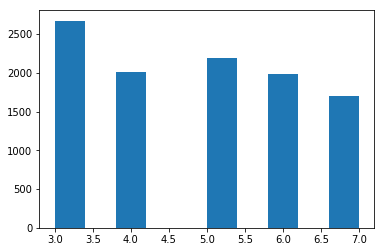

In [45]:
# digitize
bins = np.array([0.0, 1e-10000000, 2e-7, 2e-4,5e-4, 7e-4, 15e-4, ])
y_discrete= np.digitize(data.y.numpy(), bins)
print(y_discrete)
plt.hist(y_discrete)

In [46]:
y_discrete = y_discrete.flatten()

In [47]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[3, 4, 5, 6, 7]

In [48]:
y_list = y_discrete.tolist()
for j in range(len(y_list)):
    if y_list[j] == 3:
        y_list[j]=0
    elif y_list[j] == 4:
        y_list[j]=1
    elif y_list[j] == 5:
        y_list[j]=2
    elif y_list[j] == 6:
        y_list[j]=3
    elif y_list[j] == 7:
        y_list[j]=4
    elif y_list[j] == 8:
        y_list[j]=5
        
set(y_list)
y_discrete = np.array(y_list)

In [49]:
y_discrete

array([1, 1, 0, ..., 3, 0, 0])

In [50]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[0, 1, 2, 3, 4]

In [51]:
dataset.num_features

1433

In [52]:
len(data.y)

10556

In [53]:
from __future__ import division

import time
from pprint import pprint

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, y, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    indices = []
    for i in range(num_classes):
        index = (data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    data.val_mask = index_to_mask(rest_index[:500], size=data.num_nodes)
    data.test_mask = index_to_mask(rest_index[500:1500], size=data.num_nodes)
    
    # they should be correspondent, so train_edge_mask & co should be derived...
    # too lazy , just remove mask for nodes for now
    
    indices = []
    for i in range(num_classes):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:20] for i in indices], dim=0)

    rest_index = torch.cat([i[20:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    
    data.train_edge_mask = index_to_mask(train_index, size=len(y))
    data.val_edge_mask = index_to_mask(rest_index[:500], size=len(y))
    data.test_edge_mask = index_to_mask(rest_index[500:1433], size=len(y))

    return data


def run(dataset,
        y,
        num_classes,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data,y, num_classes)
        data = data.to(device)
        y = y.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data, y)
            eval_info = evaluate(model, data, y)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)
        
        

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            

def train(model, optimizer, data, y):
    model.train()
    optimizer.zero_grad()
    # so the model uses all the nodes and edges
    out = model(data)
    # but only tests loss on masked edges...
    loss = F.nll_loss(out[data.train_edge_mask], y[data.train_edge_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data, y):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        edge_mask = data['{}_edge_mask'.format(key)]
        loss = F.nll_loss(logits[edge_mask], y[edge_mask]).item()
        pred = logits[edge_mask].max(1)[1]
        acc = pred.eq(y[edge_mask]).sum().item() / edge_mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
#from torch_geometric.nn import LinkGCNConv
from torch_geometric.nn import SAGEConv
import torch.nn as nn

from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
import importlib
from torch_geometric.data import Data


from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

from TFM_node_betweenness_training import *

class EdgeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges):
        super(EdgeModel, self).__init__()
        #self.edge_mlp = Seq(Lin(2 * 10 + 5 + 20, 5), ReLU(), Lin(5, 5))
        self.edge_mlp = Seq(Lin(2*num_features + num_edge_features +1 ,10), ReLU(), Lin(10, 19))

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #print(src.shape, dest.shape, edge_attr.shape, u[batch].shape)
        out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges):
        super(NodeModel, self).__init__()
        #self.node_mlp_1 = Seq(Lin(15, 10), ReLU(), Lin(10, 10))
        edgemodel_output_size=19
        self.node_mlp_1 = Seq(Lin(num_features+edgemodel_output_size, 10), ReLU(), Lin(10, 16))
        #self.node_mlp_2 = Seq(Lin(2 * 10 + 20, 10), ReLU(), Lin(10, 10))
        self.node_mlp_2 = Seq(Lin(num_features+1+16, 10), ReLU(), Lin(10, 15))


    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(20 + 10, 20), ReLU(), Lin(20, 20))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
        #return self.global_mlp(out)
        return u


class META1(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433, 
                 edge_attr=None, 
                 d1=0, d2=0, d3=0, d4 =19,d5=16,
                 num_edges=6):
        super(META1, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges), 
            NodeModel(num_edge_features, num_features, num_edges),  
            GlobalModel())
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 


permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    torch.LongTensor(y_discrete), 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks)

# need to change train,val, mask to edges instead of nodes!


Val Loss: 1.7367, Test Accuracy: 0.297 ± 0.028, Duration: 0.428


In [66]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    torch.LongTensor(y_discrete), 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks)

# need to change train,val, mask to edges instead of nodes!


Val Loss: 2.7704, Test Accuracy: 0.278 ± 0.018, Duration: 3.277


## 9. Improving MetaLayer Edge betweenness approximation

- play with train splits
- play with mlp num units

In [83]:
len(data.edge_attr)

10556

In [84]:
data.edge_attr

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [85]:
data.y

tensor([[2.7029e-04],
        [2.6959e-04],
        [1.3978e-04],
        ...,
        [8.4398e-04],
        [2.7283e-07],
        [1.6845e-04]])

In [28]:
import argparse 

#parser = argparse.ArgumentParser()
#parser.add_argument('--random_splits', type=bool, default=False)
#parser.add_argument('--runs', type=int, default=100)
#parser.add_argument('--epochs', type=int, default=200)
#parser.add_argument('--lr', type=float, default=0.01)
#parser.add_argument('--weight_decay', type=float, default=0.0005)
#parser.add_argument('--early_stopping', type=int, default=10)
#parser.add_argument('--hidden', type=int, default=16)
#parser.add_argument('--dropout', type=float, default=0.5)
#parser.add_argument('--normalize_features', type=bool, default=True)
#args = parser.parse_args()    
    
class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  

permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,torch.LongTensor(y_discrete), num_classes, Net( dataset.num_features, num_classes), 100, 200, 0.01, 0.0005,
    10, permute_masks)

Val Loss: 1.5844, Test Accuracy: 0.270 ± 0.046, Duration: 0.562
